# Imports and plot properties


In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Feb  6 15:24:06 2020

@author: Shiva
"""
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlt
import pandas as pd
from pandas import read_excel
from matplotlib.font_manager import FontProperties
from scipy.ndimage.interpolation import shift
import os
import glob
import timeit
from scipy import stats
import statsmodels.stats.api as sms
from matplotlib.collections import LineCollection
from tempfile import TemporaryFile
import matplotlib.gridspec as gridspec
import seaborn as sns
from statannot import add_stat_annotation
# import numpy_indexed as npi
#print(os.path.dirname(__file__))
import itertools
flatten = itertools.chain.from_iterable

#############################   Plot properties   ########################################################


font = FontProperties()
font.set_family('serif')
font.set_name('Times New Roman')
font.set_style('italic')
font.set_size('30')
font.set_weight('bold')

font_label = FontProperties()
font_label.set_family('serif')
font_label.set_name('Times New Roman')
font_label.set_style('italic')
font_label.set_size('25')
font_label.set_weight('bold')
def set_ticks(ax):
    ax.get_xaxis().set_tick_params(direction='out',labelsize = 20)
    ax.xaxis.set_ticks_position('bottom')
    ax.get_yaxis().set_tick_params(direction='out',labelsize = 20)
    ax.yaxis.set_ticks_position('left')


# Rat Functions

In [124]:
def read_DLC_csv(file_name_pos,fp_trial):
    ''' Read DeepLab Cut Data and remove the <half-trial> at the end'''
    
    df = pd.read_csv(file_name_pos, delimiter=",", header=[1,2])#*scale_pix_to_cm # scale to cm
    remainer = len(df.index)%fp_trial
    df = df.drop(np.arange(len(df.index)-remainer,len(df.index)))
    return df


def read_LED_csv(file_name_LED,DLC_end):
    ''' Read LED states from file and cut the <half-trial> at the end according to the DLC file size'''
    df = pd.read_csv(file_name_LED, delimiter=",")
    df = df.drop(np.arange(DLC_end,len(df.index)))
    return df

def list_all_files(path,extension):
    '''get all the files with extention in the path where you want to search return full path'''
    files = [x for x in os.listdir(path) if not x.startswith('.')]
    files.sort()
    files_list = list(filter(lambda x: extension in x, files))
    return list(map(path.__add__,files_list)) # join paths to file names and return

def convert_csv_to_xlsx(path):
    '''check if the directory has all the files in this format, if not convert to this format
        and remove the csv to save space'''
    files = [x for x in os.listdir(path) if not x.startswith('.')]
    files.sort()
    csv_files = list(filter(lambda x: ".csv" in x, files))
    csv_file_names = [x.replace(".csv","") for x in csv_files] # remove extensions to be able to compare lists
    xlsx_files = list(filter(lambda x: extension in x, files))
    xlsx_file_names = [x.replace(".xlsx","") for x in xlsx_files]
    if not set(csv_file_names) < set(xlsx_file_names): # if most files are in csv convert them to xlsx

        for filepath_in in csv_files:
            name = path+"/"+filepath_in

            try:
                pd.read_csv(name, delimiter=",").to_excel(path+"/"+filepath_in.replace(".csv",".xlsx"), header = True,index = False)
            except pd.errors.ParserError: # it must be a laser file
                pd.read_csv(name, delimiter=",",skiprows= 4).to_excel(path+"/"+filepath_in.replace(".csv",".xlsx"), startrow=4, header = True, index = False)

            os.remove(name) # remove the csv file.
            
        
def save_npz(mouse_type,exp_par,folder,pulse_inten, window,n_timebin,file_name_ext,
             epochs_all_mice, epochs_mean_each_mouse, epochs_spont_all_mice):
    '''save the trial epochs in npz
        1: all of laser sessions one mouse type
        2: average for each mouse in mouse type
        3: eauivalent number of laser sessions derived from spontaneous '''
    file_name = mouse_type+'_'+exp_par+'_'+pulse_inten+file_name_ext+"_mov_aver="+str(window)+"_n_t="+str(n_timebin)
    np.savez( os.path.join(pre_direct+'data_npz/'+folder+'/'+exp_par, file_name),
             epochs_all_mice=epochs_all_mice,
             epochs_mean_each_mouse=epochs_mean_each_mouse, 
             epochs_spont_all_mice=epochs_spont_all_mice)
#     dat = npzfile = np.load(pre_direct+'data_npz/'+file_name+'.npz')
#     dat.files

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)
def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)
    
def moving_average_array(X, n):
    ''' function to return the moving average with same dimentions'''
    z2= np.cumsum(np.pad(X, (n,0), 'constant', constant_values=0))
    z1 = np.cumsum(np.pad(X, (0,n), 'constant', constant_values=X[-1]))
    return (z1-z2)[(n-1):-1]/n



def derivative(x,delta_t):
    ''' take the derivative with delta_t '''
    derivative_out = (x - shift(x, delta_t, cval= x[0]))/ (delta_t/fps)
    return shift(derivative_out,-int(delta_t/2),cval= derivative_out[len(derivative_out)-1])

def derivative_mov_ave(x,delta_t,window):
    ''' take the derivative with delta_t and do a moving average over the window'''
    derivative_out = (x - shift(x, delta_t, cval= x[0]))/ (delta_t/fps)
    dx_dt = shift(derivative_out,-int(delta_t/2),cval= derivative_out[len(derivative_out)-1])
    return moving_average_array(dx_dt, window_veloc) # return the moving average
#     return dx_dt # if you don't want to do a moving average 





def input_plot(df, laser_t):
    ''' get the specifics of the plot as input and call the corresponding plot function '''
    
    print("Select what you want to see: \n")
    print(" 1. Tail \n 2. Nose \n 3. Fore Limb \n 4. Hind Limb")
    where_plot = [int(x)-1 for x in input().split()] # ask what body part to plot
    
    print(" 1. Position \n 2. Velocity \n 3. Acceleration")
    what_plot = int(input())-1 # ask what body part to plot
    
    print(" 1. X \n 2. Y ")
    which_plot = int(input())-1 # ask what body part to plot
    
    print(" 1. Right & Left \n 2. Average")
    Average_sep_plot = int(input()) # ask what body part to plot
    
    if Average_sep_plot == 2:
        print(Average_sep_plot)
        plot_what_which_where(df, laser_t, np.array(which_plot),np.array(what_plot),np.array(where_plot))
    else:
        plot_what_which_where_r_l(df, laser_t, np.array(which_plot),np.array(what_plot),np.array(where_plot))
        
def get_input_cor_body_part():
    ''' ask for the body part and coordinate from user'''
    
    print("Select for which parts you want to see the trial: \n")
    print(" 1. finger 0 \n 2. finger 1 joint \n 3. finger 1 base \n 4. finger 2 joint \n 5. finger 2 base")
    where_plot = [int(x)-1 for x in input().split()] # ask what body part to plot
#     print(" 1. X \n 2. Y ")
#     which_plot = int(input())-1 # ask what body part to plot
    print(" 1. Position \n 2. Velocity \n ")
    what_plot = int(input())-1 # ask what body part to plot
    return where_plot,what_plot

def run_one_folder(rat_no, folder_list):
    ''' run data over all mice of one group and one intensity and 
    save data of epochs and individal rats to a npz file'''
    plt.figure(2)
    fig = plt.figure(figsize=(20,15))
    nrows=2;ncols=3
    direct = pre_direct +'/Rat_' +str(rat_no)+ '/'  # directory to the folder for each mouse
    count = 0
    for day in folder_list: # Run over all the mice
        print(day)
        count +=1
        start = timeit.default_timer()
        
        folder = day
        path = direct + folder
        files_list_DLC = list_all_files(path + '/DLC','.csv')
        files_list_LED = list_all_files(path + '/LED','.csv')

        body_part,what_plot = [0],0
        all_sessions = extract_epochs_over_sessions(files_list_DLC, files_list_LED, direct, folder, fp_trial)
        all_sessions.discard_unacceptable_trials()

        failed = Failed(all_sessions)
        successful = Successful(all_sessions)
        print(" succeeded = ", successful.n_trials,"\n failed = ", failed.n_trials, "\n pad miss detections = ", session.n_pad_miss_detection)
        print(" max trial time = ", successful.max_time/fps*1000 ," ms", "\n min trial time = ", successful.min_time/fps*1000 ," ms")


        if len(files_list_DLC)==0 :
            print("No files for ",day)
            continue
        elif len(files_list_LED)==0 :
            print("No LED detection")
            continue
        else:

            ax = fig.add_subplot(nrows,ncols,count)
            plot_mean_trajectory(all_sessions,folder)
            stop = timeit.default_timer()
            print('run time = ',stop-start)

    plt.tight_layout()

    plt.savefig(pre_direct+'/Subplots'+'/All_days_'+'Rat_'+str(rat_no)+'.png',bbox_inches='tight',orientation='landscape',dpi=200)
    plt.show()

#     save_npz(mouse_type,exp_par,folder,folder, window,n_timebin,"",
#              epochs_all_mice, epochs_mean_each_mouse, epochs_spont_all_mice)

def plot_trajectory(epochs_x,epochs_y,day):
#     epochs_mean_x = np.average(epochs_x, axis = 0)
#     epochs_mean_y = np.average(epochs_y, axis = 0)
    rand_epochs = np.random.randint(0,epochs_x.shape[0],50)
    for j in rand_epochs:
        ind, = np.where(epochs_x[j,:] != -1) 
        plt.plot(epochs_x[j,ind],epochs_y[j,ind], color = 'lightskyblue', linestyle='-',linewidth=1, alpha=.5)#, marker='o',markersize=1)
    #     plt.plot(np.arange(len(epochs_x[j])),epochs_x[j], color = 'lightskyblue', linestyle='-',linewidth=2, alpha=.8, marker='o',markersize=1)
    #     plt.scatter(np.arange(len(epochs_x[j])),epochs_x[j], color = 'lightskyblue')

#     plt.plot(epochs_mean_x,epochs_mean_y, color = 'k', linestyle='-',linewidth=3, alpha=1,label = "mean trajectory")#, marker='o',markersize=1)
    plt.title("Rat #"+str(rat_no)+"\n"+day).set_fontproperties(font)
    plt.ylabel("Y cm").set_fontproperties(font_label)
    plt.ylabel("X cm").set_fontproperties(font_label)
    plt.xlim(1,6)
    plt.ylim(1.5,5.5)

def correct_labeling_jitter(epochs_x, epochs_y, likelihood, max_d_per_frame,t_s):
    ''' correct the single point jitters in detections exceeding the max speed of the mouse with
        the average of before and after time stamps 
        '''
    n_trials = epochs_x.shape[0]
    
    xx = np.concatenate((np.repeat(epochs_x[:,0].reshape(-1,1),t_s+1,axis = 1),epochs_x,
                         np.repeat(epochs_x[:,-1].reshape(-1,1),t_s+1,axis = 1)),axis = 1) # repeat boundaries to avoid boundary condition
    yy = np.concatenate((np.repeat(epochs_y[:,0].reshape(-1,1),t_s+1,axis = 1),epochs_y,
                         np.repeat(epochs_y[:,-1].reshape(-1,1),t_s+1,axis = 1)),axis = 1) # repeat boundaries to avoid boundary condition
    likelihood = np.concatenate((np.full((n_trials,t_s+1),1),likelihood,
                         np.full((n_trials,t_s+1),1)),axis = 1) # repeat boundaries to avoid boundary condition

    for i in range(xx.shape[0]): # go over trials
#     for i in range(m,m+1): # go over single trial
        ind_h_lik, = np.where(likelihood[i] > p_cutoff)
        x = np.copy(xx[i,ind_h_lik]) 
        y = np.copy(yy[i,ind_h_lik])
        
        shifted_x = shift(x, -1, cval=0) #  shifts in a periodic manner, hence the next line
        shifted_x[-1] = shifted_x[-2] # set the shifted value 
        deltas_after_x = x - shifted_x
        
        shifted_y = shift(y, -1, cval=0) # np.roll shifts in a periodic manner, hence the next line
        shifted_y[-1] = shifted_y[-2] # set the shifted value 
        deltas_after_y =  y - shifted_y 
        
        shifted_x = shift(x, 1, cval=0) #  shifts in a periodic manner, hence the next line
        shifted_x[0] = shifted_x[1] # set the shifted value 
        deltas_before_x = x - shifted_x

        shifted_y = shift(y, 1, cval=0) # np.roll shifts in a periodic manner, hence the next line
        shifted_y[0] = shifted_y[1] # set the shifted value 
        deltas_before_y =  y - shifted_y

        deltas_after = np.sqrt(np.power(deltas_after_x,2)+np.power(deltas_after_y,2))
        deltas_before = np.sqrt(np.power(deltas_before_x,2)+np.power(deltas_before_y,2))
        for j in range(1,len(ind_h_lik)-1):
            jitter_thresh_before = max_d_per_frame * (ind_h_lik[j] - ind_h_lik[j-1])
            jitter_thresh_after = max_d_per_frame * (ind_h_lik[j+1] - ind_h_lik[j])
            
            if deltas_before[j] > jitter_thresh_before and deltas_after[j] > jitter_thresh_after:
#                 plt.plot(x[ind_h_lik[j]],y[ind_h_lik[j]],'ro')
#                 plt.plot(x,y,'-o',c = 'g')
#                 print(ind_h_lik[j] - ind_h_lik[j-1])
#                 print(ind_h_lik[j+1] - ind_h_lik[j])
#                 xx[i,ind_h_lik[j]] = (np.average(x[j-t_s-1:j-1])+np.average(x[j+1:j+t_s+1]))/2
#                 yy[i,ind_h_lik[j]] = (np.average(y[j-t_s-1:j-1])+np.average(y[j+1:j+t_s+1]))/2
                xx[i,ind_h_lik[j]] = (x[j-1]+x[j+1])/2
                yy[i,ind_h_lik[j]] = (y[j-1]+y[j+1])/2


#             print("# jitter in DLC  = ", len(ind_row))                                     

    return xx[:,t_s+1:-(t_s+1)],yy[:,t_s+1:-(t_s+1)]

def set_points_around_the_pad(x,y,delta_x,delta_y,t):
    ''' concatenate t elements before pad off  '''

    x = np.hstack((np.repeat(x[0],t),x)) 
    y = np.hstack((np.repeat(y[0],t),y)) 
    delta_x = np.hstack((np.zeros((t)),delta_x)) 
    delta_y = np.hstack((np.zeros((t)),delta_y)) 

    return x,y,delta_x,delta_y

def correct_lasting_labeling_jitter(epochs_x, epochs_y,likelihood,to_keep, jitter_threshold,t,fp_trial,cor_t_prox_thresh):
    ''' correct the detections exceeding the max speed of the mouse (chekcing for r) with
        extrapolation with a straight line. Thus enforcing corrections to be dependent on early detections.
        for early jitters t extra points are provided before time zero by 
        <set_points_around_the_pad> function.
        '''
    count = 0
    for i in range(epochs_x.shape[0]): # go over trials
#     for i in range(m,m+1): # go over single trial
        ind_h_lik, = np.where(likelihood[i] > p_cutoff)
        x_copy = np.copy(epochs_x[i,ind_h_lik]) 
        y_copy = np.copy(epochs_y[i,ind_h_lik]) 
        shifted_x = shift((x_copy), 1, cval=0) #  shifts in a periodic manner, hence the next line
        shifted_x[0] = shifted_x[1] # set the shifted value 
        deltas_before_x = np.copy(shifted_x - x_copy)

        shifted_y = shift((y_copy), 1, cval=0) # np.roll shifts in a periodic manner, hence the next line
        shifted_y[0] = shifted_y[1] # set the shifted value 
        deltas_before_y =  np.copy(shifted_y - y_copy)
        
        x,y,deltas_x,deltas_y = set_points_around_the_pad(x_copy,y_copy,
                                                        deltas_before_x, deltas_before_y,t)

        rho,phi = cart2pol(deltas_x,deltas_y) # we have the displacement vector in polar coordinates
        ind, = np.where(rho > jitter_threshold) # find the jumps
        ind = ind[ind > t] # leave room for having reference before the jump
#         print(x[ind[0]:ind[-1]+1])
        if len(ind) >= 2: # since we're checking for back and forths we need couples            
            for j in range (0,len(ind)-1):
#                 print("ind",ind[j],ind[j+1])
                if ind[j+1] - ind[j] > cor_t_prox_thresh: # if the points are too far apart
                    continue
#                 print("phi", abs(abs(phi[ind[j]] - phi[ind[j+1]])-np.pi),jitter_proximity_thresh_phi)
#                 print("rho", abs(rho[ind[j]] - rho[ind[j+1]]),jitter_proximity_thresh_rho)
                if abs(rho[ind[j]] - rho[ind[j+1]]) < jitter_proximity_thresh_rho and abs(abs(phi[ind[j]] - phi[ind[j+1]])-np.pi) < jitter_proximity_thresh_phi: 
                ## check to see if there is an approximatly same size backward jump to the correct path from this jump
#                     print("in")
                    # referece provided by average of t points before the jump
                    ref_av_x = np.sum(x[ind[j]-t:ind[j]-1])/ len((x[ind[j]-t:ind[j]-1])) 
                    ref_av_y = np.sum(y[ind[j]-t:ind[j]-1])/ len((y[ind[j]-t:ind[j]-1]))
                    n_points_to_correct = len((x[ind[j]:ind[j+1]])) # number of points included in the jump
                    # average of jumped points provided by average of points included in the jump
                    av_x = np.sum(x[ind[j]:ind[j+1]])/ n_points_to_correct
                    av_y = np.sum(y[ind[j]:ind[j+1]])/n_points_to_correct
                    
                    r_ref,theta_ref = cart2pol(ref_av_x,ref_av_y)# get a vector pointing to reference average  
                    r_av,theta_av = cart2pol(av_x,av_y)# get a vector pointing to jump average 
#                     print("Rs",r_av,r_ref)
#                     print("thetas",theta_av,theta_ref)
#                     print((n_points_to_correct*jitter_proximity_thresh_rho*thresh_adjust))
#                     print((n_points_to_correct*jitter_proximity_thresh_phi*thresh_adjust/2))

                    # since points are corrected as we go. If this is not a forth and back, the reference and jump vectors would be almost the same
                    if abs(r_av - r_ref) <  (n_points_to_correct
                    *jitter_proximity_thresh_rho*thresh_adjust) and abs(theta_av - theta_ref) < (n_points_to_correct
                    *jitter_proximity_thresh_phi*thresh_adjust/2):
                        continue # if these criteria aren't met this not a forth and back of a jump but the back and forth of two consecutive jumps
                    
                    p1 = np.array([x[ind[j]-1],y[ind[j]-1]])
                    p2 = np.array([x[ind[j+1]],y[ind[j+1]]])
                    correction_x,correction_y = equidistant_points_between(p1, p2, n_p_between = ind[j+1]- ind[j])# extrapolate the correction for jumped points using
                     
                    count += 1
                    ind = ind - t
#                     print("before",x_copy[ind[j]:ind[j+1]])
                    x_copy[ind[j]:ind[j+1]] = correction_x
                    y_copy[ind[j]:ind[j+1]] = correction_y
#                     print("after",x_copy[ind[j]:ind[j+1]])
        epochs_x[i,likelihood[i] > p_cutoff] = x_copy
        epochs_y[i,likelihood[i] > p_cutoff] = y_copy
    print("# second order jitter :", count)
    return epochs_x, epochs_y, to_keep

def filter_by_likelihood(df,body_part,r_or_l,p_cutoff):
    ''' return the indices of frames with likelihood of more than p_cutoff'''
    likelihood = np.copy(df[(r_or_l+body_part,'likelihood')].values).reshape(-1,1)
    ind_high_certainty, = np.where(likelihood > p_cutoff)
    return ind_high_certainty

def position(df,body_part,r_or_l,scale_pix_to_cm):
    ''' read selected body part's x,y and likelihood from the data frame '''
    
    x = np.copy(df[(r_or_l+body_part[0],'x')].values).reshape(-1,1)*scale_pix_to_cm
    y = np.copy(df[(r_or_l+body_part[0],'y')].values).reshape(-1,1)*scale_pix_to_cm
    likelihood = np.copy(df[(r_or_l+body_part[0],'likelihood')].values).reshape(-1,1)

    return   x,y,likelihood #moving_average_array(averaged_position, window)

# def average_position(df,body_part,r_or_l,fp_trial,scale_pix_to_cm):
#     ''' average over the selected body parts '''
    
#     body_part_list = body_part_list[body_part]
#     averaged_position_x = np.zeros((len(df.index),1))
#     averaged_position_y = np.zeros((len(df.index),1))

#     for param in body_part_list : # average over body parts
#         x = np.copy(df[(r_or_l+param,'x')].values).reshape(-1,1)*scale_pix_to_cm

#         y = np.copy(df[(r_or_l+param,'y')].values).reshape(-1,1)*scale_pix_to_cm

#         x, y = correct_labeling_jitter(x,y,jitter_threshold,n_iter_jitter, t_s,fp_trial)
#         averaged_position_x += x ; averaged_position_y += y
#     averaged_position_x = averaged_position_x/len(body_part_list)
#     averaged_position_y = averaged_position_y/len(body_part_list)
#     return   averaged_position_x,averaged_position_y #moving_average_array(averaged_position, window)

def set_pix_scale(df_LED,pad_length_cm):
    pad_length_pix = abs(df_LED['x'][df_LED['point']=='pad_right'].values.copy()-
                                df_LED['x'][df_LED['point']=='pad_left'].values.copy())
    scale_pix_to_cm = pad_length_cm /  pad_length_pix
    return scale_pix_to_cm

def extract_opto_epochs(df,df_LED, r_or_l,path,folder,fp_trial,body_part,frame_height,n_timebin,
                        velocity_mask,p_cutoff,pad_thresh,max_allowed_v,pad_length_cm,t_s,jitter_threshold,
                       laser_protocol, laser_pulse, laser_intensity):
    '''extract epochs of one session 
        return the session class containing all the info for the session'''

    scale_pix_to_cm = set_pix_scale(df_LED,pad_length_cm)
#     variable_x , variable_y = average_position(df,body_part,r_or_l,fp_trial,scale_pix_to_cm)
    x , y, likelihood = position(df,body_part,r_or_l,scale_pix_to_cm)
    y = frame_height*scale_pix_to_cm - y # image has decreasing y instead of increasing

    session = Session(folder)
    session.set_epochs(x, y,likelihood, fp_trial) # reshapes to separate trials  
    session.set_properties(path,df_LED, r_or_l, fp_trial,pad_thresh)
    session.apply_pad_constraint(p_cutoff,r_or_l)
    session.discard_unreasonable_n_acc_likelihood(p_cutoff,n_good_points_ratio)
    session.epochs_x, session.epochs_y = correct_labeling_jitter(session.epochs_x, session.epochs_y,
                                                session.likelihood,max_v_per_frame, t_s)
    session.epochs_x, session.epochs_y,session.to_keep = correct_lasting_labeling_jitter(session.epochs_x, session.epochs_y,
                                                session.likelihood,session.to_keep,jitter_threshold, t_s,fp_trial,cor_t_prox_thresh)
    session.correct_small_likelihoods(p_cutoff,cor_t_prox_thresh)
    session.calculate_steps_traveled(max_allowed_v) # get the steps before masking 
    session.calculate_velocity(n_timebin)
    session.set_laser_properties(df_LED,fp_trial,laser_protocol, laser_pulse, laser_intensity)
    session.discard_unacceptable_trials()
#     session.refine_pad_LED_based_on_laser_protocol(laser_delay, laser_duration)
#     session.ave_LED_info_based_on_laser_protocol(laser_delay, laser_duration)

#     session.mask_beginnings_and_end_of_trials(velocity_mask,max_allowed_v)
    print("n trials = ",session.n_trials)
    return session

def extract_epochs(df,df_LED, r_or_l,path,folder,fp_trial,body_part,frame_height,n_timebin,velocity_mask,
                   p_cutoff,pad_thresh,max_allowed_v,pad_length_cm,t_s,jitter_threshold):
    '''extract epochs of one session 
        return the session class containing all the info for the session'''

    scale_pix_to_cm = set_pix_scale(df_LED,pad_length_cm)
#     variable_x , variable_y = average_position(df,body_part,r_or_l,fp_trial,scale_pix_to_cm)
    x , y, likelihood = position(df,body_part,r_or_l,scale_pix_to_cm)
    y = frame_height*scale_pix_to_cm - y # image has decreasing y instead of increasing

    session = Session(folder)
    session.set_epochs(x, y,likelihood, fp_trial) # reshapes to separate trials  
    session.set_properties(path,df_LED, r_or_l, fp_trial,pad_thresh)
    session.apply_pad_constraint(p_cutoff,r_or_l)
    session.discard_unreasonable_n_acc_likelihood(p_cutoff,n_good_points_ratio)
#     session.epochs_x, session.epochs_y = correct_labeling_jitter(session.epochs_x, session.epochs_y,
#                                                 session.likelihood,max_v_per_frame, t_s)
    session.epochs_x, session.epochs_y,session.to_keep = correct_lasting_labeling_jitter(session.epochs_x, session.epochs_y,
                                                session.likelihood,session.to_keep,jitter_threshold, t_s,fp_trial)
    session.correct_small_likelihoods(p_cutoff)
    session.calculate_steps_traveled(max_allowed_v) # get the steps before masking 
    session.calculate_velocity(n_timebin)
    session.discard_unacceptable_trials()
    session.mask_beginnings_and_end_of_trials(velocity_mask,max_allowed_v)
    print("n trials = ",session.n_trials)
    return session
def extract_epochs_over_sessions(R_or_L_list, files_list_DLC, files_list_LED, folder, fp_trial,
                                 laser_protocol, laser_pulse, laser_intensity,contain_laser,body_part,frame_height,n_timebin,
                        velocity_mask,p_cutoff,pad_thresh,max_allowed_v,pad_length_cm,t_s,jitter_threshold):
    '''return all the epochs of all trials for one animal '''
    trials_each = 45 # estimated number of trials per session
    all_sessions = All_Session(len(files_list_DLC)* trials_each,contain_laser)
    trial_count = 0
    for i in range(0,len(files_list_DLC)):
#         print(' number of session = {} out of {}'.format(i+1,len(files_list_DLC)))
#         print(files_list_DLC[i])
        df = read_DLC_csv(files_list_DLC[i],fp_trial)
        df_LED = read_LED_csv(files_list_LED[i],len(df.index))
        r_or_l = R_or_L_list[i]
        path = files_list_LED[i]
        if contain_laser == True:
            session = extract_opto_epochs(df,df_LED, r_or_l,path,folder,fp_trial,body_part,frame_height,n_timebin,
                        velocity_mask,p_cutoff,pad_thresh,max_allowed_v,pad_length_cm,t_s,jitter_threshold,
                       laser_protocol, laser_pulse, laser_intensity)
        elif contain_laser == False:
            session = extract_epochs(df,df_LED, r_or_l,path,folder,fp_trial,body_part,frame_height,n_timebin,velocity_mask,
                   p_cutoff,pad_thresh,max_allowed_v,pad_length_cm,t_s,jitter_threshold)
#         print(np.max(session.velocity_r,axis = 1))
        all_sessions.add_session(trial_count, session.n_trials, session,contain_laser)
        trial_count += session.n_trials
    all_sessions.remove_extra_nans(contain_laser)
    return all_sessions

def find_mean_trajectory(n_grid, all_sessions):
    ''' finds the mean trajectory by averaging within a 
    each x-grid window and return the mean and stats in class <trials>'''
    epochs_x, epochs_y = all_sessions.epochs_x,all_sessions.epochs_y
    x_grid = np.linspace(min(epochs_x[epochs_x > 0]), max(epochs_x[epochs_x > 0]), n_grid)

    trials = Trials(n_grid-1)

    for i in range(len(x_grid[:-1])):
    #     plt.axvline(x=x_grid[i], ls='-', c='y',linewidth = 1)
        xs = epochs_x[np.logical_and(epochs_x < x_grid[i+1], epochs_x > x_grid[i])]
        ys = epochs_y[np.logical_and(epochs_x < x_grid[i+1], epochs_x > x_grid[i])]
        if len(xs) !=0 : # if there are actual observations for this grid window
            trials.x[i] = np.average(xs)
            trials.y[i] = np.average(ys)
            temp_x = sms.DescrStatsW(xs).tconfint_mean(alpha=0.05, alternative='two-sided')
            trials.conf_inter_x [i,:] = temp_x[1] - trials.x[i], trials.x[i]-temp_x[0]
            temp_y = sms.DescrStatsW(xs).tconfint_mean(alpha=0.05, alternative='two-sided')
            trials.conf_inter_y [i,:] = temp_y[1] - trials.y[i], trials.y[i]-temp_y[0]

            trials.err_y[i] = np.std(ys)
            trials.err_x[i] = np.std(xs)

#             trials.err_y[i] = stats.sem(ys)
#             trials.err_x[i] = stats.sem(xs)

    trials.remove_nans()
    return trials

def find_all_files_same_protocol(pre_direct, protocol_name):
    ''' gets folder as input and finds all sessions of a certain protocol among different animals.
        returns an array specifying L or R handedness together with DLC and LED file paths '''
    files_list_DLC = []
    files_list_LED = []
    R_or_L_list = []
    for dirpath, dirnames, filenames in os.walk(pre_direct):
        for dirname in dirnames:
            if dirname == protocol_name:
                path = os.path.join(dirpath) +'/' + protocol_name
                R_L_folder = [ f.name for f in os.scandir(path) if f.is_dir() ][0] # gives the Right or Left
                files = list_all_files(path +'/'+R_L_folder+'/DLC/','.csv')
                R_or_L_list += [R_L_folder[0]]* len(files)
                files_list_DLC += files
                files_list_LED += (list_all_files(path +'/'+R_L_folder+'/LED/','.csv'))
#     print("number of sessionsf for "+ protocol_name + "protocol " , len(files_list_DLC))
    return R_or_L_list, files_list_DLC, files_list_LED

def equidistant_points_between(p1, p2, n_p_between):
    x = np.linspace(p1[0], p2[0], n_p_between+1, endpoint=False)
    y = np.linspace(p1[1], p2[1], n_p_between+1, endpoint=False)
    return x[1:],y[1:]

def issubset(a, b):
    """Return whether sequence `a` is a subset of sequence `b`"""
    return len(np.setdiff1d(a, b)) == 0

In [12]:
a = np.arange(10,15)
print(a)
b= np.arange(4)
issubset(b,a)

[10 11 12 13 14]


False

# Classes

In [208]:
class Trials:
    ''' stores the mean and errors of the trajectory for any number of trials'''
    
    def __init__(self,n_grid):
        self.x = np.zeros((n_grid)) * np.nan
        self.y = np.zeros((n_grid)) * np.nan
        self.err_x = np.zeros((n_grid)) * np.nan
        self.conf_inter_x = np.zeros((n_grid, 2)) * np.nan
        self.conf_inter_y = np.zeros((n_grid, 2)) * np.nan
        self.err_y = np.zeros((n_grid)) * np.nan
        self.max_time = None
        self.min_time = None
        
    def remove_nans(self):
        ''' if the grid is too fine some windows wouldn't have any data, here we discard them'''
        ind = ~np.isnan(self.x) 
        self.x = self.x[ind]
        self.y = self.y[ind]
        self.err_x = self.err_x[ind]
        self.err_y = self.err_y[ind]
        self.conf_inter_x = self.conf_inter_x[ind]
        self.conf_inter_y = self.conf_inter_y[ind]
        

class Session:
    ''' class storing information for each video session'''
    
    def __init__(self,folder):
        self.rat_no = None
        self.path = None
        self.folder = folder
        self.fp_trial = None
        self.pad_left_x = None
        self.pad_right_x = None
        self.pad_y = None
        self.lever_x = None
        self.lever_y = None
        self.n_pad_miss_detection = None
        self.n_trials = None
        self.n_failed = None
        self.n_succeeded = None
        self.epochs_x = None
        self.epochs_y = None
        self.likelihood = None # likelihood reported by DLC
        self.pad_off_t = None # stores times when paw left the pad relative to start of trial (-1 if didn't)
        self.got_reward_t = None # stores times of lever press in each trial (-1 for failed)
        self.pad_miss_detection = None # set true for mis detected pad trials
        self.starts = None # start of each trial in the session time line
        self.ends = None # stop of each trial in the session time line
        self.failure = None # True for trials where either paw didn't leave the pad or didn't press the lever
        self.to_keep = None # False for trials to be discarded
        self.laser_trial = None # True for trials that contain laser stimulation
        self.laser_ind = None # stores the indices for laser-on time points 
        self.n_laser_trials = None
        self.laser_duration = None
        self.laser_start = None
        self.laser_pulse = None # Square continous or beta wave 
        self.laser_intensity = None
        self.laser_protocol = None # all-RT, all-MT, partial-MT 
        self.velocity_r = None # velocity 
        self.MT = None # movement time
        self.steps = None # the length of steps taken throughout the trial
        self.scale_pix_to_cm = None
        
    def set_epochs(self, x, y , likelihood,fp_trial):
         # set the epochs provided by csv files
        n_trials = int(len(x)/fp_trial)
        self.epochs_x = x.reshape(n_trials,fp_trial)
        self.epochs_y = y.reshape(n_trials,fp_trial)
        self.likelihood = likelihood.reshape(n_trials,fp_trial)

        
    def set_properties(self,path, df, r_or_l, fp_trial,pad_thresh):
        ''' find when the paw left the pad and when reached the lever
            determine failed and successful trials and trials to be discarded due to errors'''
        self.fp_trial = fp_trial
        # read LEDs from the LED df 
        pad = np.copy(df[r_or_l+'_pad'].values).reshape(int(len(df.index)/fp_trial),fp_trial)
        reward = np.copy(df['reward'].values).reshape(int(len(df.index)/fp_trial),fp_trial)
#         print(r_or_l)
        self.scale_pix_to_cm = pad_length_cm / abs(df['x'][df['point']=='pad_right'].values.copy()-
                                df['x'][df['point']=='pad_left'].values.copy()) # coef to change pix to cm
        
#         self.epochs_x = self.epochs_x*self.scale_pix_to_cm # scale into cm
#         self.epochs_y = self.epochs_y*self.scale_pix_to_cm
        
        self.n_trials = pad.shape[0]
        self.pad_off_t = np.zeros((self.n_trials),dtype = int)
        self.MT = np.zeros((self.n_trials),dtype = int)

        self.pad_left_x = np.full((self.n_trials),df['x'][df['point']=='pad_left'].values.copy())*self.scale_pix_to_cm
        self.pad_right_x = np.full((self.n_trials),df['x'][df['point']=='pad_right'].values.copy())*self.scale_pix_to_cm
        self.pad_y = np.full((self.n_trials),frame_height - df['y'][df['point']=='pad_left'].copy())*self.scale_pix_to_cm
        self.lever_x = np.full((self.n_trials),df['x'][df['point']=='lever'].copy())*self.scale_pix_to_cm
        self.lever_y = np.full((self.n_trials),frame_height - df['y'][df['point']=='lever'].copy())*self.scale_pix_to_cm
        self.got_reward_t = np.zeros((self.n_trials),dtype = int)
        self.starts = np.arange(0,len(df.index),fp_trial)
        self.ends = np.arange(0,len(df.index),fp_trial)
        self.pad_miss_detection = np.array([False]* self.n_trials)
        self.failure = np.array([False]* self.n_trials)
        self.path = np.array([path]* self.n_trials, dtype='object')
        for i in range (self.n_trials):

            temp_reward, = np.where(reward[i,:] == 1) # times where reward LED is on
            temp_pad_on, = np.where(pad[i,:] == 1) # times where reward corresponding pad LED is on
            temp_pad_off, = np.where(pad[i,:] == 0) # times where reward corresponding pad LED is off
            
            if len(temp_reward) == 0: #----------------------# failed trial
                if len(temp_pad_on) == 0: #-------------------------# hand already left the paw
                    self.pad_off_t[i] = int(0)
                else:
                    if len(temp_pad_off) != 0:
                        self.pad_off_t[i] = int(np.min(temp_pad_off)) # first time hand left pad
                    else: self.pad_off_t[i] = int(0)
                self.got_reward_t[i]  = -1 #-----------------# coding the failures
                self.failure[i] = True
                
            else: #------------------------------------------# successful trial
                self.got_reward_t[i]  = int(np.min(temp_reward)) # earliest time paw pressed lever
                if len(temp_pad_on) == 0: #-------------------------# hand already left the paw
                    self.pad_off_t[i] = int(0)
                else:
#                     print("pad ",temp_pad)
#                     print("reward", temp_reward)
#                     print(self.starts[i])
#                     print("reward after pad ",temp_pad[temp_pad < self.got_reward_t[i]])
                    if len(temp_pad_on[temp_pad_on < self.got_reward_t[i]]) == 0:
                        self.pad_off_t[i] = int(0)
                    elif len(temp_pad_off[temp_pad_off < self.got_reward_t[i]]) == 0:#--------------------------------------# store last frame before pressing the lever the paw was on the pad
                        self.pad_off_t[i] = -1 #-----------------# code pad was wrongly activated
                        self.pad_miss_detection[i] = True
                    else:
                        self.pad_off_t[i] = int(np.min(temp_pad_off[temp_pad_off < self.got_reward_t[i]]))

#                     print("reward ", self.got_reward_t[i])
#                     print("pad left at:" , self.pad_off_t[i])
                ## -------------- if MT is less than a threshold there was pad miss detection (or lever)
                if self.got_reward_t[i] - self.pad_off_t[i] < pad_thresh: ###################### to do
#                     print(self.got_reward_t[i],self.pad_off_t[i])
                    self.pad_off_t[i] = -1 #-----------------# code pad was wrongly activated
                    self.pad_miss_detection[i] = True
       
        self.to_keep = np.invert(self.pad_miss_detection) # so far the pad miss detection is the sole foreseen error
        self.n_failed = sum(self.failure)
        self.n_succeeded = self.n_trials - self.n_failed
        self.n_pad_miss_detection = sum(self.pad_miss_detection)
        self.MT = self.got_reward_t - self.pad_off_t # movement time
       
    def apply_pad_constraint(self,p_cutoff, r_or_l):
        ''' whatever the situation the paw starts from the pad. Here considering from the x of the first detection'''
        self.epochs_x = np.roll(self.epochs_x, 1, axis=1) # shift to add the pad constraint even for ones that are leaving at 0
        self.epochs_y = np.roll(self.epochs_y, 1, axis=1)
        self.epochs_y[:,0] = self.epochs_y[:,1]
        self.epochs_x[:,0] = self.epochs_x[:,1]
        self.likelihood = np.roll(self.likelihood, 1, axis=1) # shift to add the pad constraint even for ones that are leaving at 0
        self.likelihood[:,0] = 1
        discard = 0
        for i in range (self.n_trials):
            high_likelihood, = np.where(self.likelihood[i] > p_cutoff)
            if r_or_l == 'L':
                above_pad, = np.where((self.epochs_x[i] > self.pad_left_x[0]) & 
                                       (self.epochs_x[i] < self.pad_right_x[0]+self.pad_right_x[0]/3))
            else:
                above_pad, = np.where((self.epochs_x[i] > (self.pad_left_x[0] - self.pad_left_x[0]/3)) & 
                                       (self.epochs_x[i] < self.pad_right_x[0]))
#             print("above pad",above_pad)
#             print("h likelihood", high_likelihood[high_likelihood > self.pad_off_t[i]])
            supposed_x_on_pad_ind = np.intersect1d(high_likelihood[high_likelihood > self.pad_off_t[i]], above_pad)
#             print("intersect",supposed_x_on_pad_ind, i)
            if len(supposed_x_on_pad_ind != 0 ):
                supposed_x_on_pad = self.epochs_x[i,supposed_x_on_pad_ind[0]]
#                 print("join pad",supposed_x_on_pad)
                width  = (self.pad_right_x[0] - self.pad_left_x[0])
                if self.epochs_y[i,supposed_x_on_pad_ind[0]] < self.pad_y[0] -width or self.epochs_y[i,supposed_x_on_pad_ind[0]] > self.pad_y[0]+width:
                    discard +=1
                    self.to_keep[i] = False 
                self.epochs_x[i,:self.pad_off_t[i]+1] = supposed_x_on_pad
                self.epochs_y[i,:self.pad_off_t[i]+1] = self.pad_y[0]
                self.likelihood[i,:self.pad_off_t[i]+1] = 1
            else: # if there are no high probability detections above the pad, this trial better be discarded
                discard +=1
                self.to_keep[i] = False 
        print("to discard ", discard)

    def discard_unreasonable_n_acc_likelihood(self,p_cutoff,n_good_points_ratio):
        ''' mark trials that have less than n_good_points with likelihood above p_cutoff as unusable'''
        good = np.sum(self.likelihood > p_cutoff,axis = 1) 
        ind, = np.where(good < n_good_points_ratio*self.fp_trial)
        self.to_keep[ind] = False
        
    def correct_small_likelihoods(self,p_cutoff,cor_t_prox_thresh):
        ''' put equidistant points from ends instead of detections with likelihood less than p_cutoff'''
        for i in range (self.n_trials):
            low_p_ind, = np.where(self.likelihood[i] < p_cutoff)
            goods = (self.likelihood[i] > p_cutoff).astype(int)
            good_shift = shift(goods.copy(), -1 ,cval = 1)
            bounds_start, = np.where((goods - good_shift) == 1) 
            good_shift = shift(goods.copy(), 1 ,cval = 1)
            bounds_end, = np.where(( goods - good_shift) == 1) 
            ind = np.unique(np.concatenate((bounds_start,bounds_end),0))

            for j in range(len(ind)-1):
                this = ind[j] ; next_ = ind[j+1]
                if next_-this > cor_t_prox_thresh: # if the points are too far apart
                    continue
                p1 = np.array([self.epochs_x[i,this],self.epochs_y[i,this]])
                p2 = np.array([self.epochs_x[i,next_],self.epochs_y[i,next_]])
#                 if i == m: 
#                     print("low p", low_p_ind)
#                     print('end',bounds_end)
#                     print('start',bounds_start)
#                     print("edges",ind)
#                     print(this,next_,issubset(np.arange(ind[j]+1,ind[j+1]),low_p_ind))
                    
                if next_-this-1 > 0 and issubset(np.arange(ind[j]+1,ind[j+1]),low_p_ind):
                    x,y = equidistant_points_between(p1, p2, next_-this-1)
#                     print(points)
                    self.epochs_x[i,this+1:next_] = x
                    self.epochs_y[i,this+1:next_] = y
                    
    def mask_beginnings_and_end_of_trials(self, velocity_mask, max_allowed_v):
        ''' mask values for before leaving the pad and after lever press f'''
        
        
        successful_trials, = np.where(~self.failure)
        for i in successful_trials: # go over successfull trials
            #--------------------------------------------# before pad off is not important --> mask it
            self.epochs_x[i,self.got_reward_t[i]:] = -1 ; self.epochs_y[i,self.got_reward_t[i]:] = -1
            self.velocity_r[i,self.got_reward_t[i]:] = velocity_mask ; self.velocity_r[i,self.got_reward_t[i]:] = velocity_mask

            #--------------------------------------------# after reward delivary is not important --> mask it
            if self.pad_off_t[i] != 0 and self.pad_off_t[i] != -1:
                self.epochs_x[i,:self.pad_off_t[i]] = -1 ; self.epochs_y[i,:self.pad_off_t[i]] = -1
                self.velocity_r[i,:self.pad_off_t[i]] = velocity_mask ; self.velocity_r[i,:self.pad_off_t[i]] = velocity_mask
        
    def set_laser_properties(self, df,fp_trial, laser_protocol, laser_pulse, laser_intensity):
        ''' read laser onset and offsets from df and set the properties corresponding to laser stimulation'''
        
        laser = np.copy(df['laser'].values).reshape(int(len(df.index)/fp_trial),fp_trial)
        self.laser_trial = np.array([False]* self.n_trials)
        self.laser_duration = np.zeros((self.n_trials))
        self.laser_start = np.zeros((self.n_trials))
        
        self.laser_pulse = np.array([laser_pulse]* self.n_trials, dtype='object')        
        self.laser_intensity = np.array([laser_intensity]* self.n_trials, dtype='object')
        self.laser_protocol = np.array([laser_protocol]* self.n_trials, dtype='object')
        for i in range (self.n_trials):

            temp_laser, = np.where(laser[i,:] == 1) # times where laser was on
            
            if len(temp_laser) == 0: #-------------------------# not a laser trial
                continue
                
            else: #--------------------------------------------#  laser trial
                self.laser_trial[i] = True 
                laser_start = min(temp_laser) ; laser_end = max(temp_laser) 
#                 if self.got_reward_t[i] < laser_end: # if the detection of reward happens before laser end 
#                     # since we know the laser tends to turn off with lever press
#                     laser_end = self.got_reward_t[i]
#                 print("discontinuity = ", sum(laser[i,laser_start:laser_end] == 0))
                self.laser_duration[i] = laser_end - laser_start
                self.laser_start[i] = laser_start

        self.n_laser_trials = sum(self.laser_trial)
    
    def ave_LED_info_based_on_laser_protocol(self, laser_delay, laser_duration):
        ''' averages over laser and pad off detections based on protocol. This is for when you are 
            sure of all LED detections equally and want to increase accuracy by averaging.
            Note: to be called after discard function.'''
        
        if self.laser_protocol[0] == "partial-MT":

            start = (self.pad_off_t[self.laser_trial]+laser_delay+self.laser_start[self.laser_trial])/2
            self.pad_off_t[self.laser_trial] = (start-laser_delay).astype(int); self.laser_start[self.laser_trial] = start.astype(int)
            self.pad_off_t[self.pad_off_t < 0] = 0
            self.laser_duration[self.laser_trial] = start.astype(int) + laser_duration # assuming stimulation is applied in a specific duration
            ind = np.logical_and(self.got_reward_t < (self.laser_duration+self.laser_start),self.got_reward_t != -1) # if the detection of reward happens before laser end 
           # since we know the laser tends to turn off with lever press
            self.laser_duration[ind] = self.got_reward_t[ind]- self.laser_start[ind]
            self.MT = self.got_reward_t - self.pad_off_t
            
        if self.laser_protocol[0] == "all-MT": # laser onset aligned to pad off and laser off to reward delivery
            start = (self.pad_off_t[self.laser_trial]+ self.laser_start[self.laser_trial])/2
            end = (self.got_reward_t[self.laser_trial]+ self.laser_start[self.laser_trial]+
                            self.laser_duration[self.laser_trial])/2
            self.pad_off_t[self.laser_trial] = start.astype(int) ; self.laser_start[self.laser_trial] = start.astype(int)
            self.got_reward_t[self.laser_trial] = end.astype(int) ; self.laser_duration[self.laser_trial] = end.astype(int) - start.astype(int)
            self.MT = self.got_reward_t - self.pad_off_t
            
        if self.laser_protocol[0] == "all-RT": # leaving the pad is aligned with laser off
            pad_off = (self.pad_off_t[self.laser_trial]+ self.laser_start[self.laser_trial]+self.laser_duration[self.laser_trial])/2
            self.pad_off_t[self.laser_trial] =pad_off.astype(int); self.laser_duration[self.laser_trial] = pad_off.astype(int)-self.laser_start[self.laser_trial]
            self.MT = self.got_reward_t - self.pad_off_t
            
    def refine_pad_LED_based_on_laser_protocol(self, laser_delay, laser_duration):
        ''' since the pad detector LED is more prone to error, 
            it is corrected by the laser and reward LED and the knowlegde of the protocol. 
            Note: to be called after discard function to have no negatives for pad and reward times'''
        
        if self.laser_protocol[0] == "partial-MT":
            self.pad_off_t[self.laser_trial] = (self.laser_start[self.laser_trial]-laser_delay).astype(int)
            self.pad_off_t[self.pad_off_t < 0] = 0
            self.laser_duration[self.laser_trial] = self.laser_start[self.laser_trial] + laser_duration # assuming stimulation is applied in a specific duration
            ind = np.logical_and(self.got_reward_t < (self.laser_duration+self.laser_start),self.got_reward_t != -1) # if the detection of reward happens before laser end 
           # since we know the laser tends to turn off with lever press
            self.laser_duration[ind] = self.got_reward_t[ind]- self.laser_start[ind]
            self.MT = self.got_reward_t - self.pad_off_t
            
        if self.laser_protocol[0] == "all-MT": # laser onset aligned to pad off and laser off to reward delivery

            self.pad_off_t[self.laser_trial] = (self.laser_start[self.laser_trial]-laser_delay).astype(int)
            self.pad_off_t[self.pad_off_t < 0] = 0
            end = (self.got_reward_t[self.laser_trial]+ self.laser_start[self.laser_trial]+
                            self.laser_duration[self.laser_trial])/2
            self.got_reward_t[self.laser_trial] = end.astype(int) ; self.laser_duration[self.laser_trial] = end.astype(int) - start.astype(int)
            self.MT = self.got_reward_t - self.pad_off_t
            
        if self.laser_protocol[0] == "all-RT": # leaving the pad is aligned with laser off
            self.pad_off_t[self.laser_trial] = (self.laser_start[self.laser_trial]+self.laser_duration[self.laser_trial])
            self.MT = self.got_reward_t - self.pad_off_t
            
    def calculate_velocity(self,n_timebin):
        ''' calculate velocity over n_timebins. 
            Note: pads the epochs on both ends to be able to calculate 
            the velocity for the boundaries as well'''
        
        conc_t = int(n_timebin/2)
        xx = np.sqrt(np.power(self.epochs_x,2) + np.power(self.epochs_x,2))
        shifted_forward_x = np.concatenate((np.repeat(xx[:,0].reshape(-1,1),conc_t,axis = 1),xx[:,:-conc_t]),axis = 1) # repeat boundaries to avoid boundary condition
        shifted_back_x = np.concatenate((xx[:,conc_t:],np.repeat(xx[:,-1].reshape(-1,1),conc_t,axis = 1)),axis = 1) # repeat boundaries to avoid boundary condition
        self.velocity_r = (shifted_back_x - shifted_forward_x)/ (2*conc_t/fps)
        
    def calculate_steps_traveled(self, max_allowed_v):
        ''' clculate the d^2 = delta(x)^2+ delta(y)^2 and replace the unacceptable jumps with the mean'''
        x = self.epochs_x.copy()
        y = self.epochs_y.copy()
        conc_t = 1
        shifted_forward_x = np.concatenate((np.repeat(x[:,0].reshape(-1,1),conc_t,axis = 1),x),axis = 1) # repeat boundaries to avoid boundary condition
        shifted_back_x = np.concatenate((x,np.repeat(x[:,-1].reshape(-1,1),conc_t,axis = 1)),axis = 1) # repeat boundaries to avoid boundary condition
        delta_x_pw_2 = np.power((shifted_back_x - shifted_forward_x)[:,:-1],2)
        shifted_forward_y = np.concatenate((np.repeat(y[:,0].reshape(-1,1),conc_t,axis = 1),y),axis = 1) # repeat boundaries to avoid boundary condition
        shifted_back_y = np.concatenate((y,np.repeat(y[:,-1].reshape(-1,1),conc_t,axis = 1)),axis = 1) # repeat boundaries to avoid boundary condition
        delta_y_pw_2 = np.power((shifted_back_y - shifted_forward_y)[:,:-1],2)   
        self.steps = np.sqrt(delta_x_pw_2 + delta_y_pw_2)
        
        for i in range(self.steps.shape[0]):
            ind, = np.where(self.steps[i] != 0)
            
            mean_distance = np.average(self.steps[i,ind])# average over timebins where there was movement
            ind, = np.where(self.steps[i] > max_allowed_v)
#             if self.failure[i] == False and self.laser_trial[i] == False: to see where jitters are detected in laser sessions
#                 print("jitter ", ind-self.pad_off_t[i])
            self.steps[i,ind] = mean_distance # replace with mean in case of crazy jumps

    def discard_unacceptable_trials(self):
        ''' adjust all of the session object variables after discarding the unacceptable trials'''
        
        self.epochs_x = self.epochs_x[self.to_keep]
        self.epochs_y = self.epochs_y[self.to_keep]
        self.likelihood =self.likelihood[self.to_keep]
        self.velocity_r = self.velocity_r[self.to_keep]
        self.pad_off_t = self.pad_off_t[self.to_keep]
        self.got_reward_t = self.got_reward_t[self.to_keep]
        self.pad_miss_detection = self.pad_miss_detection[self.to_keep]
        self.starts = self.starts[self.to_keep]
        self.ends = self.ends[self.to_keep]
        self.failure = self.failure[self.to_keep]
        self.MT = self.MT[self.to_keep]
        self.path = self.path[self.to_keep]
        self.steps = self.steps[self.to_keep]
        self.n_trials = len(self.starts)
        self.n_failed = sum(self.failure)
        self.n_succeeded = self.n_trials - self.n_failed
        self.n_pad_miss_detection = sum(self.pad_miss_detection)
        self.pad_left_x = self.pad_left_x[self.to_keep]
        self.pad_right_x = self.pad_right_x[self.to_keep]
        self.pad_y = self.pad_y[self.to_keep]
        self.lever_x = self.lever_x[self.to_keep]
        self.lever_y = self.lever_y[self.to_keep]
        if self.n_laser_trials != None : # if this concerns optogenetic manipulation        
            self.laser_trial = self.laser_trial[self.to_keep] 
            self.laser_duration = self.laser_duration[self.to_keep] 
            self.laser_start = self.laser_start[self.to_keep]
            self.laser_pulse = self.laser_pulse[self.to_keep] 
            self.laser_intensity = self.laser_intensity[self.to_keep]
            self.laser_protocol = self.laser_protocol[self.to_keep]
            self.n_laser_trials = sum(self.laser_trial)
        self.to_keep = self.to_keep[self.to_keep]
        
class Failed(Session):
    ''' storing only failed trials
         Note: this is the last class to be called to categorize sessions 
    '''

    def __init__(self,session):

        self.n_trials = session.n_failed
        self.path = session.path[session.failure]
        self.folder = session.folder
        self.fp_trial = session.fp_trial
        self.pad_left_x = session.pad_left_x[session.failure]
        self.pad_right_x = session.pad_right_x[session.failure]
        self.pad_y = session.pad_y[session.failure]
        self.lever_x = session.lever_x[session.failure]
        self.lever_y = session.lever_y[session.failure]
        self.epochs_x = session.epochs_x[session.failure]
        self.epochs_y = session.epochs_y[session.failure]
        self.likelihood = session.likelihood[session.failure]
        self.velocity_r = session.velocity_r[session.failure]
        self.pad_off_t = session.pad_off_t[session.failure]
        self.got_reward_t = session.got_reward_t[session.failure]
        self.pad_miss_detection = session.pad_miss_detection[session.failure]
        self.starts = session.starts[session.failure]
        self.ends = session.ends[session.failure] 
        self.steps = session.steps[session.failure] 
        self.MT = session.MT[session.failure] 
        self.n_pad_miss_detection = sum(self.pad_miss_detection)
        self.distance = None
        self.tortuosity = None # ratio of the traveled distance to the straight line from pad to lever
        self.traveled_distance()
        if session.n_laser_trials != None : # if this concerns optogenetic manipulation
            self.laser_pulse = session.laser_pulse[session.failure] 
            self.laser_intensity = session.laser_intensity[session.failure] 
            self.laser_protocol = session.laser_protocol[session.failure] 
            self.laser_trial = session.laser_trial[session.failure] 
            self.laser_start = session.laser_start[session.failure] 
            self.laser_duration = session.laser_duration[session.failure] 

    def traveled_distance(self):
        ''' reduce to the time steps after leaving the pad in a ridiculous manner'''
        col = []; ind = []; row= []; where, = np.where(self.pad_off_t > 0)
        all_RTs = [col+np.arange(n,dtype=int).tolist() for n in self.pad_off_t[self.pad_off_t > 0]]
        rows = [row+np.full((int(self.pad_off_t[i])),int(i)).tolist() for i in where]
        ind.append(list(flatten(rows))); ind.append(list(flatten(all_RTs))) 
        self.steps[ind] = 0 
        self.distance = np.sum(self.steps, axis = 1)
        if self.n_trials != 0:
#             straight_trajectory_length = ((self.lever_x-(self.pad_left_x+self.pad_right_x)/2)**2+
#             (self.lever_y - self.pad_y)**2)**0.5 # mid pad to lever
#             print("here",self.epochs_x[np.arange(self.n_trials),self.pad_off_t.astype(int)].shape)
#             straight_trajectory_length = ((self.lever_x-self.epochs_x[:,self.pad_off_t.astype(int)])**2+
#             (self.lever_y - self.pad_y)**2)**0.5 # paw on pad to lever
            x = np.power((self.lever_x-self.epochs_x[np.arange(self.n_trials),
                                self.pad_off_t.astype(int)]),2)
            y = np.power((self.lever_y - self.pad_y),2)
            print('x',x.shape)
            print('y',y.shape)
            straight_trajectory_length = (x + y)**0.5 # paw on pad to lever
            print('dis',straight_trajectory_length.shape)
            self.tortuosity = (self.distance / straight_trajectory_length).astype(float)            
            print("tor",self.tortuosity.shape)
class Successful(Session):
    ''' storing only successful trials
        Note: this is the last class to be called to categorize sessions
    '''
    
    def __init__(self,session):

        self.n_trials = session.n_succeeded
        self.path = session.path[np.invert(session.failure)]
        self.folder = session.folder 
        self.fp_trial = session.fp_trial
        self.pad_left_x = session.pad_left_x[np.invert(session.failure)]
        self.pad_right_x = session.pad_right_x[np.invert(session.failure)]
        self.pad_y = session.pad_y[np.invert(session.failure)]
        self.lever_x = session.lever_x[np.invert(session.failure)]
        self.lever_y = session.lever_y[np.invert(session.failure)]
        self.epochs_x = session.epochs_x[np.invert(session.failure)]
        self.epochs_y = session.epochs_y[np.invert(session.failure)]
        self.likelihood = session.likelihood[np.invert(session.failure)]
        self.velocity_r = session.velocity_r[np.invert(session.failure)]
        self.pad_off_t = session.pad_off_t[np.invert(session.failure)]
        self.got_reward_t = session.got_reward_t[np.invert(session.failure)]
        self.pad_miss_detection = session.pad_miss_detection[np.invert(session.failure)]
        self.starts = session.starts[np.invert(session.failure)]
        self.MT = session.MT[np.invert(session.failure)]
        self.ends = session.ends[np.invert(session.failure)] 
        self.steps = session.steps[np.invert(session.failure)] 
#         print(self.got_reward_t)
#         print(self.pad_off_t)
        self.max_time = max(self.got_reward_t - self.pad_off_t)
        self.min_time = min(self.got_reward_t - self.pad_off_t)
        self.trial_no_max_time = np.argmax(self.got_reward_t - self.pad_off_t)
        self.trial_no_min_time = np.argmin(self.got_reward_t - self.pad_off_t)
        self.distance = None # the distace travelled during MT.
        self.tortuosity = None  # ratio of the traveled distance to the straight line from pad to lever
        self.traveled_distance()
        
        if session.n_laser_trials != None : # if this concerns optogenetic manipulation
            self.laser_pulse = session.laser_pulse[np.invert(session.failure)] 
            self.laser_intensity = session.laser_intensity[np.invert(session.failure)] 
            self.laser_protocol = session.laser_protocol[np.invert(session.failure)] 
            self.laser_trial = session.laser_trial[np.invert(session.failure)] 
            self.laser_start = session.laser_start[np.invert(session.failure)] 
            self.laser_duration = session.laser_duration[np.invert(session.failure)] 
            self.distance_during_laser = np.zeros((len(self.laser_trial)))
            
    def traveled_distance(self):
        ''' calculate distance traveled during movement time
        '''
        for i in range(self.n_trials):
            self.steps[i,:int(self.pad_off_t[i])] = 0 
            self.steps[i,int(self.got_reward_t[i]):] = 0 
        self.distance = np.sum(self.steps, axis = 1)
        if self.n_trials != 0:
            
#             straight_trajectory_length = ((self.lever_x-(self.pad_left_x+self.pad_right_x)/2)**2+
#             (self.lever_y - self.pad_y)**2)**0.5
            x = np.power((self.lever_x-self.epochs_x[np.arange(self.n_trials),
                                self.pad_off_t.astype(int)]),2)
            y = np.power((self.lever_y - self.pad_y),2)
            print('x',x.shape)
            print('y',y.shape)
            straight_trajectory_length = (x + y)**0.5 # paw on pad to lever
            print('dis',straight_trajectory_length.shape)
            self.tortuosity = (self.distance / straight_trajectory_length).astype(float)            
            print("tor",self.tortuosity.shape)
class Laser(Session):
    ''' storing only laser trials from the session'''
    
    def __init__(self,session):
        self.laser_pulse = session.laser_pulse[session.laser_trial]
        self.laser_intensity = session.laser_intensity[session.laser_trial]
        self.laser_protocol = session.laser_protocol[session.laser_trial]
        self.n_trials = session.n_laser_trials
        self.n_laser_trials = session.n_laser_trials 
        self.path = session.path[session.laser_trial]
        self.pad_left_x = session.pad_left_x[session.laser_trial]
        self.pad_right_x = session.pad_right_x[session.laser_trial]
        self.pad_y = session.pad_y[session.laser_trial]
        self.lever_x = session.lever_x[session.laser_trial]
        self.lever_y = session.lever_y[session.laser_trial]
        self.folder = session.folder 
        self.fp_trial = session.fp_trial
        self.laser_pulse = session.laser_pulse[session.laser_trial]
        self.laser_intensity = session.laser_intensity[session.laser_trial]
        self.laser_protocol = session.laser_protocol[session.laser_trial]
        self.epochs_x = session.epochs_x[session.laser_trial]
        self.epochs_y = session.epochs_y[session.laser_trial]
        self.likelihood = session.likelihood[session.laser_trial]
        self.velocity_r = session.velocity_r[session.laser_trial]
        self.pad_off_t = session.pad_off_t[session.laser_trial]
        self.got_reward_t = session.got_reward_t[session.laser_trial]
        self.pad_miss_detection = session.pad_miss_detection[session.laser_trial]
        self.starts = session.starts[session.laser_trial]
        self.ends = session.ends[session.laser_trial]
        self.steps = session.steps[session.laser_trial]
        self.MT = session.MT[session.laser_trial]
        self.failure = session.failure[session.laser_trial]
        self.to_keep = session.to_keep[session.laser_trial]
        self.laser_duration = session.laser_duration[session.laser_trial]
        self.n_failed = sum(self.failure)
        self.n_succeeded = self.n_trials - sum(self.failure)
        self.laser_trial = session.laser_trial[session.laser_trial]
        self.laser_start = session.laser_start[session.laser_trial]
        self.mean_velocity_during_laser = np.zeros((self.n_laser_trials)) # mean velocity during laser stimulus

        for i in range(len(self.laser_trial)):

            self.mean_velocity_during_laser[i] = np.sum(self.steps[i,int(self.laser_start[i]):int(self.laser_start[i]
                                +self.laser_duration[i])])/self.laser_duration[i]

class Non_Laser(Session):
    ''' storing only non-laser trials from the session'''
    
    def __init__(self,session):
        self.laser_pulse = session.laser_pulse
        self.laser_intensity = session.laser_intensity
        self.laser_protocol = session.laser_protocol
        self.n_laser_trials = session.n_laser_trials
        self.n_trials =session.n_trials - session.n_laser_trials
        self.path = session.path[np.invert(session.laser_trial)]
        self.pad_left_x = session.pad_left_x[np.invert(session.laser_trial)]
        self.pad_right_x = session.pad_right_x[np.invert(session.laser_trial)]
        self.pad_y = session.pad_y[np.invert(session.laser_trial)]
        self.lever_x = session.lever_x[np.invert(session.laser_trial)]
        self.lever_y = session.lever_y[np.invert(session.laser_trial)]
        self.folder = session.folder 
        self.fp_trial = session.fp_trial
        self.laser_pulse = session.laser_pulse[np.invert(session.laser_trial)]
        self.laser_intensity = session.laser_intensity[np.invert(session.laser_trial)]
        self.laser_protocol = session.laser_protocol[np.invert(session.laser_trial)]
        self.epochs_x = session.epochs_x[np.invert(session.laser_trial)]
        self.epochs_y = session.epochs_y[np.invert(session.laser_trial)]
        self.likelihood = session.likelihood[np.invert(session.laser_trial)]
        self.velocity_r = session.velocity_r[np.invert(session.laser_trial)]
        self.pad_off_t = session.pad_off_t[np.invert(session.laser_trial)]
        self.got_reward_t = session.got_reward_t[np.invert(session.laser_trial)]
        self.pad_miss_detection = session.pad_miss_detection[np.invert(session.laser_trial)]
        self.starts = session.starts[np.invert(session.laser_trial)]
        self.ends = session.ends[np.invert(session.laser_trial)]
        self.steps = session.steps[np.invert(session.laser_trial)]
        self.MT = session.MT[np.invert(session.laser_trial)]
        self.failure = session.failure[np.invert(session.laser_trial)]
        self.to_keep = session.to_keep[np.invert(session.laser_trial)]
        self.laser_duration = session.laser_duration[np.invert(session.laser_trial)]
        self.n_failed = sum(self.failure)
        self.laser_trial = session.laser_trial[np.invert(session.laser_trial)]
        self.laser_start = session.laser_start[np.invert(session.laser_trial)]
        self.velocity_r = session.velocity_r[np.invert(session.laser_trial)]
        self.n_succeeded = self.n_trials - sum(self.failure)
#         self.distance_during_laser = np.zeros((self.n_trials))

#         for i in range(len(self.laser_trial)):
            
#             self.distance_during_laser[i] = np.sum(self.steps[i,start:end],axis = 1)/(end - start)


class All_Session(Session):
    ''' class storing information for each video session'''
    
    def __init__(self,estimated_n_trials,contain_laser):

        self.path = np.array(['nan']*estimated_n_trials,dtype='object')
        self.pad_left_x = np.array(['nan']*estimated_n_trials,dtype='object')
        self.pad_right_x = np.array(['nan']*estimated_n_trials,dtype='object')
        self.pad_y = np.array(['nan']*estimated_n_trials,dtype='object')
        self.lever_x = np.array(['nan']*estimated_n_trials,dtype='object')
        self.lever_y = np.array(['nan']*estimated_n_trials,dtype='object')
        self.folder = None
        self.n_pad_miss_detection = np.empty((estimated_n_trials)) * np.nan
        self.fp_trial = np.empty((estimated_n_trials)) * np.nan
        self.epochs_x = np.empty((estimated_n_trials, fp_trial)) * np.nan
        self.epochs_y = np.empty((estimated_n_trials, fp_trial)) * np.nan
        self.likelihood = np.empty((estimated_n_trials, fp_trial)) * np.nan
        self.velocity_r = np.empty((estimated_n_trials, fp_trial)) * np.nan
        self.steps = np.empty((estimated_n_trials, fp_trial)) * np.nan

        self.pad_off_t = np.empty((estimated_n_trials)) * np.nan # stores times when paw left the pad relative to start of trial (-1 if didn't)
        self.got_reward_t = np.empty((estimated_n_trials)) * np.nan # stores times of lever press in each trial (-1 for failed)
        self.pad_miss_detection = np.array([False]* estimated_n_trials) # set true for mis detected pad trials
        self.starts = np.empty((estimated_n_trials)) * np.nan # start of each trial in the session time line
        self.ends = np.empty((estimated_n_trials)) * np.nan # stop of each trial in the session time line
        self.MT = np.empty((estimated_n_trials)) * np.nan
#         self.distance = np.empty((estimated_n_trials)) * np.nan

        self.failure = np.array([False]* estimated_n_trials) # True for trials where either paw didn't leave the pad or didn't press the lever
        self.to_keep = np.array([True]* estimated_n_trials)
        self.n_trials = None
        self.n_failed = None
        self.n_succeeded = None
        self.n_pad_miss_detection = None
        self.n_laser_trials = None
        if contain_laser == True  :
            self.laser_trial = np.array([False]* estimated_n_trials) # True for trials that contain laser stimulation
            self.laser_ind = np.empty((estimated_n_trials, fp_trial)) * np.nan # stores the indices for laser-on time points 
            self.laser_duration = np.empty((estimated_n_trials)) * np.nan
            self.laser_start = np.empty((estimated_n_trials)) * np.nan
            self.laser_pulse = np.array(['nan']*estimated_n_trials,dtype='object')
            self.laser_intensity = np.array(['nan']*estimated_n_trials,dtype='object') 
            self.laser_protocol = np.array(['nan']*estimated_n_trials,dtype='object')
            

    def add_session(self,n_trials_before, n_trial_to_add, session,contain_laser):
        ''' gets each session and adds it's data to this class  '''
        end = n_trials_before+ n_trial_to_add  

        self.path[n_trials_before : end] = session.path
        self.pad_left_x[n_trials_before : end] = session.pad_left_x
        self.pad_right_x[n_trials_before : end] = session.pad_right_x
        self.pad_y[n_trials_before : end] = session.pad_y
        self.lever_x[n_trials_before : end] = session.lever_x
        self.lever_y[n_trials_before : end] = session.lever_y
        self.folder = session.folder
        self.fp_trial[n_trials_before : end] = session.fp_trial

        self.epochs_x[n_trials_before : end] = session.epochs_x
        self.epochs_y[n_trials_before : end] = session.epochs_y
        self.likelihood[n_trials_before : end] = session.likelihood
        self.velocity_r[n_trials_before : end] = session.velocity_r
        self.pad_off_t[n_trials_before : end] = session.pad_off_t
        self.got_reward_t[n_trials_before : end] = session.got_reward_t
        self.pad_miss_detection[n_trials_before : end] = session.pad_miss_detection
        self.starts[n_trials_before : end] = session.starts
        self.ends[n_trials_before : end] = session.ends
        self.steps[n_trials_before : end] = session.steps
#         self.distance[n_trials_before : end] = session.distance

        self.MT[n_trials_before : end] = session.MT
        self.failure[n_trials_before : end] = session.failure
        self.to_keep[n_trials_before : end] = session.to_keep
        self.n_pad_miss_detection = sum(self.pad_miss_detection)
        
        if contain_laser == True  : # if this concerns optogenetic manipulation
            self.laser_trial[n_trials_before : end] = session.laser_trial
            self.laser_duration[n_trials_before : end]= session.laser_duration
            self.laser_start[n_trials_before : end]= session.laser_start
            self.laser_pulse[n_trials_before : end] = session.laser_pulse
            self.laser_intensity[n_trials_before : end] = session.laser_intensity
            self.laser_protocol[n_trials_before : end] = session.laser_protocol
            self.n_laser_trials = sum(self.laser_trial)


    def remove_extra_nans(self,contain_laser):
        ''' variables initialisez with estimated size to avoid using append, 
        here the empty leftovers are discarded'''
    
        ind = ~np.isnan(self.pad_off_t) 
        self.path = self.path[ind] 
        self.pad_left_x = self.pad_left_x[ind] 
        self.pad_right_x = self.pad_right_x[ind] 
        self.pad_y = self.pad_y[ind] 
        self.lever_x = self.lever_x[ind] 
        self.lever_y = self.lever_y[ind] 
        self.fp_trial = self.fp_trial[ind]
        self.epochs_x = self.epochs_x[ind]
        self.epochs_y = self.epochs_y[ind]
        self.likelihood = self.likelihood[ind]

        self.velocity_r = self.velocity_r[ind]
        self.pad_off_t = self.pad_off_t[ind]
        self.got_reward_t = self.got_reward_t[ind]
        self.pad_miss_detection = self.pad_miss_detection[ind]
        self.starts = self.starts[ind]
        self.ends = self.ends[ind]
        self.MT = self.MT[ind]
        self.steps = self.steps[ind]
#         self.distance = self.distance[ind]
        self.failure = self.failure[ind]
        self.to_keep = self.to_keep[ind]
        self.n_trials = len(self.path)
        self.n_failed = sum(self.failure)
        self.n_succeeded = self.n_trials - self.n_failed
        self.n_pad_miss_detection = sum(self.pad_miss_detection)
        
        if contain_laser == True  : # if this concerns optogenetic manipulation
            self.laser_trial = self.laser_trial[ind]
            self.laser_duration = self.laser_duration[ind]
            self.laser_start = self.laser_start[ind]
            self.laser_pulse = self.laser_pulse[ind]
            self.laser_intensity = self.laser_intensity[ind]
            self.laser_protocol = self.laser_protocol[ind]
            self.n_laser_trials = sum(self.laser_trial)


# Constants

In [77]:
pad_length_cm = 2 # cm
fps = 250; # frame per second 
fp_trial = 375 # number of frames per trial

body_part_list = np.array(['finger0',  'finger1base', 'finger1joint', 'finger2base', 'finger2joint',
                     'forearm', 'elbow'])
cor_list = np.array(['x', 'y'])
plot_param_list = ['position' , 'velocity', 'acceleration']
folder_list = ['Day_-1','Day_0','Day_7','Day_8','Day_9','Day_10']

max_speed = 100 # cm/s # the max speed of the rat derived from average trajectory 
max_allowed_v = max_speed/fps
print(max_allowed_v)
jitter_threshold =max_allowed_v
jitter_proximity_thresh_rho = 0.2 # the acceptable jitter in r coordinate to be considered as the samr jump
thresh_adjust = 1/5 # if there are 5 jemped points the threshold is <jitter_proximity_thresh_rho>
jitter_proximity_thresh_phi = 30/180*np.pi
acc_deviance = 1.5 # cm = acceptable deviance between right and left detections
frame_height = 400
pre_direct = '/home/shiva/Desktop/Rat_Lever_Analysis' # ubuntu directory
n_iter_jitter = 1
t_s = 5 # number of time steps before and after to look at
t = 4
pad_thresh = 20
n_timebin = 10 
velocity_mask = - 20000
laser_delay = int(25/(1000/fps)) ; laser_duration = int(250/(1000/fps))
window = 10 # moving average window
window_veloc = 5
p_cutoff = 0.8 # above which the DLC detection likelihood would be acceptable
n_grid = 20
n_good_points_ratio = 1/4
max_v_per_frame = 0.30 # cm/4ms
cor_t_prox_thresh = 30 #number of frames more than which the low likelihood points are not allowd to be connected

0.4


# Get all sessions

Day_-1
 number of session = 1 out of 4
/home/shiva/Desktop/Rat_Lever_Analysis/6OHDA/Rat_12/Day_-1/DLC/Rat 12 head 1 03-06-19_20190603_101411_C001H001S0001DLC_resnet50_Rat_lever_Ana_Rat_12May6shuffle1_250000.csv
to discard  7
# second order jitter : 0
n trials =  31
 number of session = 2 out of 4
/home/shiva/Desktop/Rat_Lever_Analysis/6OHDA/Rat_12/Day_-1/DLC/Rat 12 head 1 03-06-19_20190603_102056_C001H001S0001DLC_resnet50_Rat_lever_Ana_Rat_12May6shuffle1_250000.csv
to discard  0
# second order jitter : 0
n trials =  43
 number of session = 3 out of 4
/home/shiva/Desktop/Rat_Lever_Analysis/6OHDA/Rat_12/Day_-1/DLC/Rat 12 head 1 03-06-19_20190603_102904_C001H001S0001DLC_resnet50_Rat_lever_Ana_Rat_12May6shuffle1_250000.csv


/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:420: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
No handles with labels found to put in legend.


to discard  1
# second order jitter : 0
n trials =  39
 number of session = 4 out of 4
/home/shiva/Desktop/Rat_Lever_Analysis/6OHDA/Rat_12/Day_-1/DLC/Rat 12 head 1 03-06-19_20190603_103621_C001H001S0001DLC_resnet50_Rat_lever_Ana_Rat_12May6shuffle1_250000.csv
to discard  4
# second order jitter : 0
n trials =  32
 succeeded =  144 
 failed =  1 
 pad miss detections =  0
 max trial time =  1412.0  ms 
 min trial time =  160.0  ms
run time =  0.31761244800145505
Day_0
 number of session = 1 out of 4
/home/shiva/Desktop/Rat_Lever_Analysis/6OHDA/Rat_12/Day_0/DLC/Rat 12 head 1 6OHDA x2 04-06-19_20190604_180719_C001H001S0001DLC_resnet50_Rat_lever_Ana_Rat_12May6shuffle1_250000.csv
to discard  1
# second order jitter : 0
n trials =  42
 number of session = 2 out of 4
/home/shiva/Desktop/Rat_Lever_Analysis/6OHDA/Rat_12/Day_0/DLC/Rat 12 head 1 6OHDA x2 04-06-19_20190604_182008_C001H001S0001DLC_resnet50_Rat_lever_Ana_Rat_12May6shuffle1_250000.csv


No handles with labels found to put in legend.


to discard  1
# second order jitter : 2
n trials =  42
 number of session = 3 out of 4
/home/shiva/Desktop/Rat_Lever_Analysis/6OHDA/Rat_12/Day_0/DLC/Rat 12 head 1 6OHDA x2 04-06-19_20190604_182821_C001H001S0001DLC_resnet50_Rat_lever_Ana_Rat_12May6shuffle1_250000.csv
to discard  1
# second order jitter : 0
n trials =  21
 number of session = 4 out of 4
/home/shiva/Desktop/Rat_Lever_Analysis/6OHDA/Rat_12/Day_0/DLC/Rat 12 head 1 Baseline 6OHDA 04-06-19_20190604_164448_C001H001S0001DLC_resnet50_Rat_lever_Ana_Rat_12May6shuffle1_250000.csv
to discard  4
# second order jitter : 2
n trials =  39
 succeeded =  139 
 failed =  5 
 pad miss detections =  0
 max trial time =  1424.0  ms 
 min trial time =  180.0  ms
run time =  0.3060393830019166
Day_7
 number of session = 1 out of 6
/home/shiva/Desktop/Rat_Lever_Analysis/6OHDA/Rat_12/Day_7/DLC/Rat 12 head 1 6OHDA x2 11-06-19_20190611_093740_C001H001S0001DLC_resnet50_Rat_lever_Ana_Rat_12May6shuffle1_250000.csv
to discard  3
# second order jitter :

No handles with labels found to put in legend.


to discard  1
# second order jitter : 0
n trials =  42
 number of session = 5 out of 6
/home/shiva/Desktop/Rat_Lever_Analysis/6OHDA/Rat_12/Day_7/DLC/Rat 12 head 1 6OHDA x2 11-06-19_20190611_103721_C001H001S0001DLC_resnet50_Rat_lever_Ana_Rat_12May6shuffle1_250000.csv
to discard  0
# second order jitter : 0
n trials =  43
 number of session = 6 out of 6
/home/shiva/Desktop/Rat_Lever_Analysis/6OHDA/Rat_12/Day_7/DLC/Rat 12 head 1 6OHDA x2 11-06-19_20190611_104959_C001H001S0001DLC_resnet50_Rat_lever_Ana_Rat_12May6shuffle1_250000.csv
to discard  0
# second order jitter : 0
n trials =  30
 succeeded =  234 
 failed =  3 
 pad miss detections =  0
 max trial time =  1352.0  ms 
 min trial time =  152.0  ms
run time =  0.4739396039985877
Day_8
 number of session = 1 out of 4
/home/shiva/Desktop/Rat_Lever_Analysis/6OHDA/Rat_12/Day_8/DLC/Rat 12 head 1 6OHDA x2 12-06-19_20190612_094246_C001H001S0001DLC_resnet50_Rat_lever_Ana_Rat_12May6shuffle1_250000.csv
to discard  2
# second order jitter : 0
n t

No handles with labels found to put in legend.


to discard  0
# second order jitter : 0
n trials =  43
 succeeded =  164 
 failed =  5 
 pad miss detections =  0
 max trial time =  1320.0  ms 
 min trial time =  152.0  ms
run time =  0.3371397150003759
Day_9
 number of session = 1 out of 3
/home/shiva/Desktop/Rat_Lever_Analysis/6OHDA/Rat_12/Day_9/DLC/Rat 12 head 1 6OHDA x2 13-06-19_20190613_084615_C001H001S0001DLC_resnet50_Rat_lever_Ana_Rat_12May6shuffle1_250000.csv
to discard  0
# second order jitter : 1
n trials =  43
 number of session = 2 out of 3
/home/shiva/Desktop/Rat_Lever_Analysis/6OHDA/Rat_12/Day_9/DLC/Rat 12 head 1 6OHDA x2 13-06-19_20190613_090236_C001H001S0001DLC_resnet50_Rat_lever_Ana_Rat_12May6shuffle1_250000.csv
to discard  4
# second order jitter : 1
n trials =  39
 number of session = 3 out of 3
/home/shiva/Desktop/Rat_Lever_Analysis/6OHDA/Rat_12/Day_9/DLC/Rat 12 head 1 6OHDA x2 13-06-19_20190613_091342_C001H001S0001DLC_resnet50_Rat_lever_Ana_Rat_12May6shuffle1_250000.csv


No handles with labels found to put in legend.


to discard  0
# second order jitter : 0
n trials =  40
 succeeded =  121 
 failed =  1 
 pad miss detections =  0
 max trial time =  1200.0  ms 
 min trial time =  148.0  ms
run time =  0.23898040899803163
Day_10
 number of session = 1 out of 3
/home/shiva/Desktop/Rat_Lever_Analysis/6OHDA/Rat_12/Day_10/DLC/Rat 12 head 1 6OHDA x2 14-06-19_20190614_080116_C001H001S0001DLC_resnet50_Rat_lever_Ana_Rat_12May6shuffle1_250000.csv
to discard  0
# second order jitter : 2
n trials =  43
 number of session = 2 out of 3
/home/shiva/Desktop/Rat_Lever_Analysis/6OHDA/Rat_12/Day_10/DLC/Rat 12 head 1 6OHDA x2 14-06-19_20190614_084144_C001H001S0001DLC_resnet50_Rat_lever_Ana_Rat_12May6shuffle1_250000.csv
to discard  1
# second order jitter : 0
n trials =  42
 number of session = 3 out of 3
/home/shiva/Desktop/Rat_Lever_Analysis/6OHDA/Rat_12/Day_10/DLC/Rat 12 head 1 6OHDA x2 14-06-19_20190614_091653_C001H001S0001DLC_resnet50_Rat_lever_Ana_Rat_12May6shuffle1_250000.csv


No handles with labels found to put in legend.


to discard  0
# second order jitter : 0
n trials =  28
 succeeded =  113 
 failed =  0 
 pad miss detections =  0
 max trial time =  908.0  ms 
 min trial time =  156.0  ms
run time =  0.22996355799841695


<Figure size 432x288 with 0 Axes>

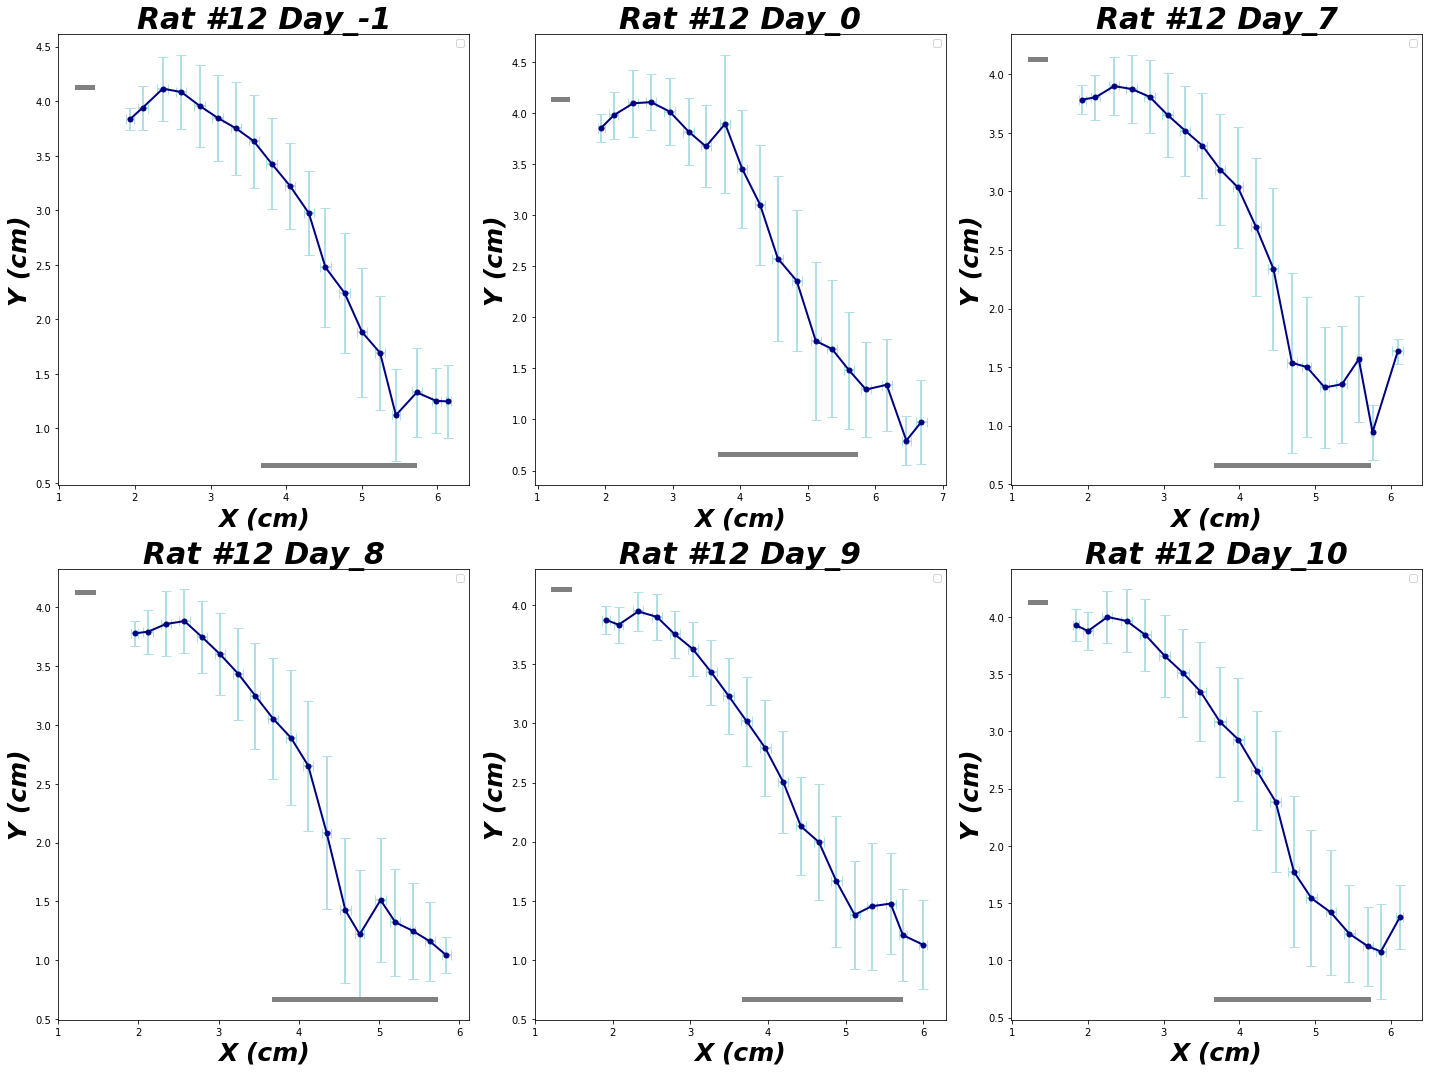

In [47]:
rat_no = 12; folder = "Day_-1"
r_or_l = 'L'
folder_list = ['Day_-1','Day_0','Day_7','Day_8','Day_9','Day_10']
direct = pre_direct +'/6OHDA'+'/Rat_' +str(rat_no)+ '/'  # directory to the folder for each mouse
contain_laser = False ; laser_protocol='None'; laser_pulse='None'; laser_intensity='None'
path = direct + folder
files_list_DLC = list_all_files(path + '/DLC/','.csv')
files_list_LED = list_all_files(path + '/LED/','.csv')
R_or_L_list = [r_or_l]*len(files_list_DLC)
where_plot,what_plot = [0],0
body_part = body_part_list[where_plot]
# all_sessions = extract_epochs_over_sessions(R_or_L_list, files_list_DLC, files_list_LED, folder, fp_trial,
#                                  laser_protocol, laser_pulse, laser_intensity,contain_laser,body_part,frame_height,n_timebin,
#                         velocity_mask,p_cutoff,pad_thresh,max_allowed_v,pad_length_cm,t_s,jitter_threshold)

# failed = Failed(all_sessions)
# successful = Successful(all_sessions)
# print(" succeeded = ", successful.n_trials,"\n failed = ", failed.n_trials, "\n pad miss detections = ", session.n_pad_miss_detection)
# print(" max trial time = ", successful.max_time/fps*1000 ," ms", "\n min trial time = ", successful.min_time/fps*1000 ," ms")
def run_one_folder(rat_no, folder_list):
    ''' run data over all mice of one group and one intensity and 
    save data of epochs and individal rats to a npz file'''
    plt.figure(2)
    fig = plt.figure(figsize=(20,15))
    nrows=2;ncols=3
    r_or_l = 'L'
    direct = pre_direct +'/6OHDA'+'/Rat_' +str(rat_no)+ '/'  # directory to the folder for each mouse
    contain_laser = False ; laser_protocol='None'; laser_pulse='None'; laser_intensity='None'
    count = 0
    for day in folder_list: # Run over all the mice
        print(day)
        count +=1
        start = timeit.default_timer()
        
        folder = day

        path = direct + folder
        files_list_DLC = list_all_files(path + '/DLC/','.csv')
        files_list_LED = list_all_files(path + '/LED/','.csv')
        R_or_L_list = [r_or_l]*len(files_list_DLC)
        where_plot,what_plot = [0],0
        body_part = body_part_list[where_plot]
        all_sessions = extract_epochs_over_sessions(R_or_L_list, files_list_DLC, files_list_LED, folder, fp_trial,
                                         laser_protocol, laser_pulse, laser_intensity,contain_laser,body_part,frame_height,n_timebin,
                                velocity_mask,p_cutoff,pad_thresh,max_allowed_v,pad_length_cm,t_s,jitter_threshold)

        failed = Failed(all_sessions)
        successful = Successful(all_sessions)
        print(" succeeded = ", successful.n_trials,"\n failed = ", failed.n_trials, "\n pad miss detections = ", session.n_pad_miss_detection)
        print(" max trial time = ", successful.max_time/fps*1000 ," ms", "\n min trial time = ", successful.min_time/fps*1000 ," ms")


        if len(files_list_DLC)==0 :
            print("No files for ",day)
            continue
        elif len(files_list_LED)==0 :
            print("No LED detection")
            continue
        else:

            ax = fig.add_subplot(nrows,ncols,count)
            plot_mean_trajectory(all_sessions,folder)
            stop = timeit.default_timer()
            print('run time = ',stop-start)

    plt.tight_layout()

#     plt.savefig(pre_direct+'/Subplots'+'/All_days_'+'Rat_'+str(rat_no)+'.png',bbox_inches='tight',orientation='landscape',dpi=200)
#     plt.show()

#     save_npz(mouse_type,exp_par,folder,folder, window,n_timebin,"",
#              epochs_all_mice, epochs_mean_each_mouse, epochs_spont_all_mice)


def plot_mean_trajectory(session,folder):
    trials = find_mean_trajectory(n_grid, session)
    plt.errorbar(trials.x,trials.y,  trials.err_y, trials.err_x,  marker = 'o',
             markersize=5, linewidth=2, capsize=5, capthick=1, color = 'navy', ecolor='powderblue')
    plt.plot([session.lever_x[0] - 0.1, session.lever_x[0] + 0.1],[session.lever_y[0],session.lever_y[0]],lw = 5, c = 'grey')
    plt.plot([session.pad_left_x[0],session.pad_right_x[0]],[session.pad_y[0],session.pad_y[0]],lw = 5, c = 'grey')

    plt.title("Rat #"+str(rat_no)+" "+folder).set_fontproperties(font)
    plt.ylabel("Y (cm)").set_fontproperties(font_label)
    plt.xlabel("X (cm)").set_fontproperties(font_label)
    plt.legend(fontsize = 10)
    
run_one_folder(rat_no, folder_list)   
# plt.savefig(pre_direct+'/Subplots/'+'Rat_'+str(rat_no)+'_'+folder+'_mean_trajectory'+
#              '.png',bbox_inches='tight',orientation='landscape',dpi=200)


## plot fastest and slowest trials

t_s 10
# jitter in DLC  =  413
t_s 10
# jitter in DLC  =  240
 succeeded =  41 
 failed =  0 
 pad miss detections =  0
 max trial time =  776.0  ms 
 min trial time =  96.0  ms


<Figure size 432x288 with 0 Axes>

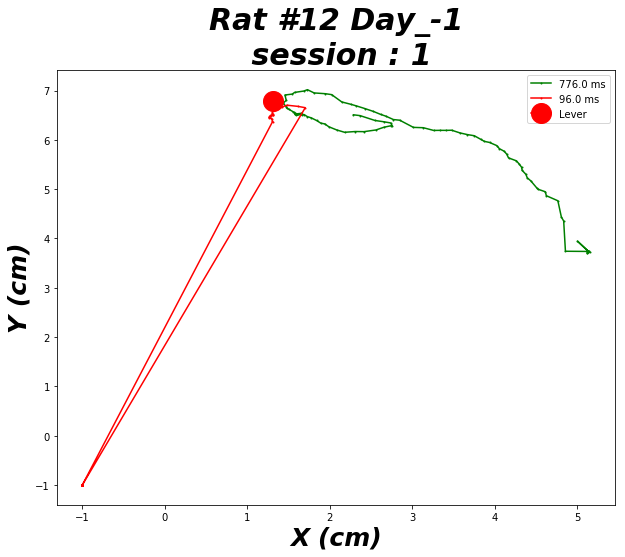

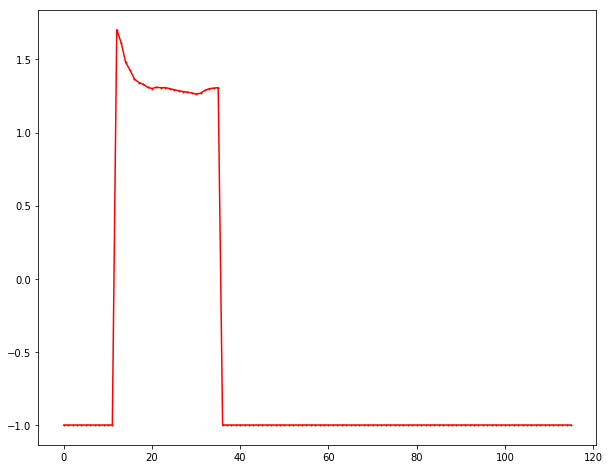

In [11]:
rat_no = 12; spont = "n"; folder = "Day_-1"
folder_list = ['Day_-1','Day_0','Day_7','Day_8','Day_9','Day_10']
direct = pre_direct +'/Rat_' +str(rat_no)+ '/'  # directory to the folder for each mouse

i = 0
files_list_DLC = list_all_files(direct+folder+'/DLC','.csv')
files_list_LED = list_all_files(direct+folder+'/LED','.csv')
path = direct+folder+'/DLC/'+files_list_DLC[i]
df = read_DLC_csv(direct+folder+'/DLC/'+files_list_DLC[i],fp_trial)
df_LED = read_LED_csv(direct+folder+'/LED/'+files_list_LED[i],len(df.index))
body_part,what_plot = [0],0

session = extract_opto_epochs(df,df_LED,path,folder,fp_trial,body_part,frame_height)
session.discard_unacceptable_trials()

failed = Failed(session)
successful = Successful(session)
print(" succeeded = ", successful.n_trials,"\n failed = ", failed.n_trials, "\n pad miss detections = ", session.n_pad_miss_detection)
print(" max trial time = ", successful.max_time/fps*1000 ," ms", "\n min trial time = ", successful.min_time/fps*1000 ," ms")
plt.figure(1)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8), sharey=True)

ind, = np.where(successful.epochs_x[j,:] != -1 ) 
plt.plot(successful.epochs_x[successful.trial_no_max_time,ind],successful.epochs_y[successful.trial_no_max_time,ind],c='g', marker='o',markersize=1, label = str(successful.max_time/fps*1000)+" ms")

ind, = np.where(successful.epochs_x[j,:] != -1 ) 
plt.plot(successful.epochs_x[successful.trial_no_min_time,ind],successful.epochs_y[successful.trial_no_min_time,ind],c='r', marker='o',markersize=1, label = str(successful.min_time/fps*1000)+" ms")
plt.plot([lever_x],[lever_y], marker='o',markersize=20,c = 'r',label = "Lever")
plt.title("Rat #"+str(rat_no)+" "+folder+"\n session : "+str(i+1)).set_fontproperties(font)
plt.ylabel("Y (cm)").set_fontproperties(font_label)
plt.xlabel("X (cm)").set_fontproperties(font_label)
plt.legend(fontsize = 10)
plt.figure(2)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8), sharey=True)
plt.plot(successful.epochs_x[successful.trial_no_min_time,ind],c='r', marker='o',markersize=1, label = str(successful.min_time/fps*1000)+" ms")



# check one session

In [48]:
rat_no = 1; exp_par = 'Laser_ChR2'
n = 0
# folder = "Square_2-5_mW_partial-MT_Nf_375"
# folder = "Square_5_mW_all-RT_Nf_500"
# folder = "Beta_20_mW_all-RT_Nf_375"
# folder = "Beta_15_mW_all-MT_Nf_500"
folder = "Beta_10_mW_all-RT_Nf_375"
prop = folder.split('_')
laser_protocol = prop[3] ; laser_pulse = prop[0]; laser_intensity = prop[1]; fp_trial = int(prop[5])
direct = pre_direct +'/'+exp_par+'/Rat_' +str(rat_no)+ '/'  # directory to the folder for each mouse
R_L_folder = [ f.name for f in os.scandir(direct+folder) if f.is_dir() ][0]
path = direct+folder + '/'+ R_L_folder
r_or_l = R_L_folder[0] # right or left hand

files_list_DLC = list_all_files(path +'/DLC/','.csv')
files_list_LED = list_all_files(path +'/LED/','.csv')
file_name = files_list_DLC[n]
print(file_name)
df = read_DLC_csv(files_list_DLC[n],fp_trial)
df_LED = read_LED_csv(files_list_LED[n],len(df.index))
where_plot,what_plot = [0],0
body_part = body_part_list[where_plot]
t = t_s
session = extract_opto_epochs(df,df_LED, r_or_l,path,folder,fp_trial,body_part,frame_height,n_timebin,
                             velocity_mask,p_cutoff,pad_thresh,max_allowed_v,pad_length_cm,t_s,jitter_threshold,
                       laser_protocol, laser_pulse, laser_intensity)
laser = Laser(session)
failed = Failed(laser)
successful = Successful(laser)
# non_laser = Non_Laser(session)
# failed = Failed(non_laser)
# print("starts" , failed.starts)

print("reward",successful.got_reward_t - successful.pad_off_t)
# print("laser duration" , laser.laser_duration/fps*1000)
# print("reward",laser.got_reward_t)
# R_or_L_list, files_list_DLC, files_list_LED = find_all_files_same_protocol(direct, folder)
# # print(files_list_LED[0])
# all_sessions = extract_epochs_over_sessions(R_or_L_list,files_list_DLC,files_list_LED,folder,fp_trial,max_allowed_v)


# laser = Laser(all_sessions)
# laser_failed = Failed(laser)
# laser_successful = Successful(laser)
# print("laser duration" , laser.laser_duration/fps*1000)
# print(np.average(laser.laser_duration/fps*1000),len(laser.laser_duration/fps*1000))
# # non_laser = Non_Laser(all_sessions)
# # normal_failed = Failed(non_laser)
# # normal_successful = Successful(non_laser)


/home/shiva/Desktop/Rat_Lever_Analysis/Laser_ChR2/Rat_1/Beta_10_mW_all-RT_Nf_375/Left/DLC/Rat1_beta_10mW_20190529_160543_C001H001S0001DLC_resnet50_Rat_lever_Sophie_Rat_1Apr26shuffle1_250000.csv
to discard  0
# second order jitter : 4
n trials =  43
reward [ 57  75  82  71  93  75  67  71  72 101  81  68  75  69  68 100  77  57]


/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:420: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [129]:
# import itertools
# flatten = itertools.chain.from_iterable
# c = []
# m = [c+(np.arange(n).tolist()) for n in np.array([5,5,5])]
# print(list(flatten(m)))
b = np.arange(25).reshape(5,5)

# print(np.where(b>5))
# b[np.where(b>5)] = 0
# print(b)


np.any(b == 5)

True

# Laser

## Trajectory successful and failed

0.4
R
/home/shiva/Desktop/Rat_Lever_Analysis/Laser_ChR2/Rat_102/Square_5_mW_partial-MT_Nf_375/Right/DLC/Rat102_partialMT-5mW_21072017_2camera_chrono_20170721_160420_C001H001S0001DLC_resnet50_Rat_lever_Velentin_Rat_102May13shuffle1_250000.csv
to discard  10
# second order jitter : 1
n trials =  31
 succeeded =  7 
 failed =  1 
 pad miss detections =  0
 max trial time =  1456.0  ms 
 min trial time =  724.0  ms


/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:435: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


<Figure size 432x288 with 0 Axes>

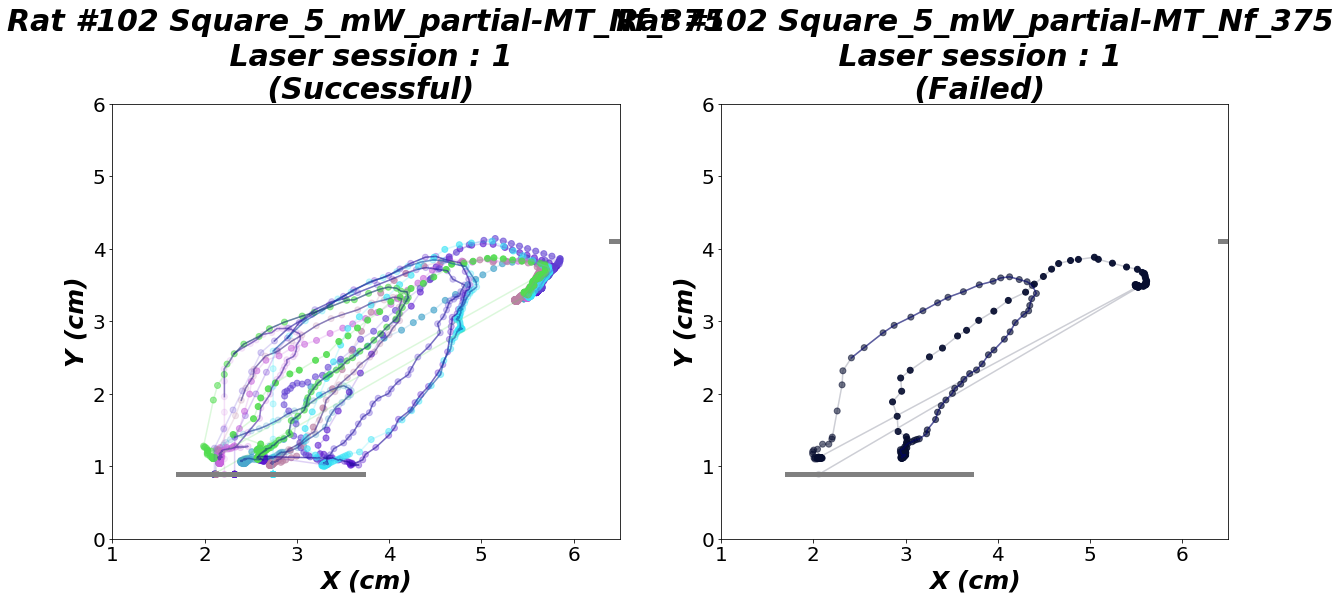

In [132]:

def plot_laser_trajectory(n,files_list_DLC,files_list_LED,path,folder):

    file_name = files_list_DLC[n]
    print(file_name)

    df = read_DLC_csv(files_list_DLC[n],fp_trial)
    df_LED = read_LED_csv(files_list_LED[n],len(df.index))
    where_plot,what_plot = [0],0
    body_part = body_part_list[where_plot]
    i = 0
    j = 0
    session = extract_opto_epochs(df,df_LED, r_or_l,path,folder,fp_trial,body_part,frame_height,n_timebin,
                        velocity_mask,p_cutoff,pad_thresh,max_allowed_v,pad_length_cm,t_s,jitter_threshold,
                       laser_protocol, laser_pulse, laser_intensity)

    laser = Laser(session)
    failed = Failed(laser)
    successful = Successful(laser)
    print(" succeeded = ", successful.n_trials,"\n failed = ", failed.n_trials, "\n pad miss detections = ", session.n_pad_miss_detection)
    print(" max trial time = ", successful.max_time/fps*1000 ," ms", "\n min trial time = ", successful.min_time/fps*1000 ," ms")
    plt.figure(1)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), sharey=True)
    ax[0] = plt.subplot(121)
#     for j in range (m,m+1):
    for j in range (0,successful.n_trials):
#         successful.epochs_x, successful.epochs_y = correct_labeling_jitter(successful.epochs_x, successful.epochs_y,
#                                                 successful.likelihood,max_v_per_frame, t_s)
#         successful.epochs_x, successful.epochs_y,session.to_keep = correct_lasting_labeling_jitter(successful.epochs_x, successful.epochs_y,
#                                                 successful.likelihood,session.to_keep,jitter_threshold, t_s,fp_trial)
#         print("low prob",(sum(successful.likelihood[j] < p_cutoff)))
#         successful.epochs_x[j,successful.likelihood[j] < p_cutoff] = -1
        overall_ind, = np.where(successful.epochs_x[j,:] != -1 )
        ind = np.arange(successful.laser_duration[j],dtype = int)+int(successful.laser_start[j])
#         print("epoch",successful.epochs_x[j,:])
#         print("pad" ,successful.pad_off_t[j])
        alphas = np.linspace(0.1, 1, len(overall_ind))
        rgba_colors = np.zeros((len(overall_ind),4))
        rgba_colors[:,:-1] = np.random.random((3))
        rgba_colors[:, 3] = alphas
        plt.scatter(successful.epochs_x[j,overall_ind],successful.epochs_y[j,overall_ind], color = rgba_colors )
        plt.plot(successful.epochs_x[j,ind],successful.epochs_y[j,ind], c = 'navy', alpha = 0.5 )
        plt.plot(successful.epochs_x[j,overall_ind],successful.epochs_y[j,overall_ind],alpha = 0.2, color = rgba_colors[0,:-1] )

    plt.plot(successful.epochs_x[j,ind],successful.epochs_y[j,ind], c = 'navy', alpha = 0.1, label= "Laser-ON" )
    plt.plot([session.lever_x[0] - 0.1, session.lever_x[0] + 0.1],[session.lever_y[0],session.lever_y[0]],lw = 5, c = 'grey')
    plt.plot([session.pad_left_x[0],session.pad_right_x[0]],[session.pad_y[0],session.pad_y[0]],lw = 5, c = 'grey')

    plt.title("Rat #"+str(rat_no)+" "+folder+"\n Laser session : "+str(n+1)+"\n (Successful)").set_fontproperties(font)
    plt.ylabel("Y (cm)").set_fontproperties(font_label)
    plt.xlabel("X (cm)").set_fontproperties(font_label)
#     plt.legend(fontsize = 10)
    plt.xlim(1,6.5)
    plt.ylim(0,6)
    set_ticks(ax[0])
    ax[1] = plt.subplot(122)

    for i in range (0,failed.n_trials):
#         failed.epochs_x[i,failed.likelihood[i] < p_cutoff] = -1
        overall_ind, = np.where(failed.epochs_x[i,:] != -1 )
        ind = np.arange(failed.laser_duration[i],dtype = int)+int(failed.laser_start[i]) 
        alphas = np.linspace(0.1, 1, len(overall_ind))
        rgba_colors = np.zeros((len(overall_ind),4))
        rgba_colors[:,:-1] = np.random.random((3))
        rgba_colors[:, 3] = alphas
        plt.scatter(failed.epochs_x[i,overall_ind],failed.epochs_y[i,overall_ind], color = rgba_colors )
        plt.plot(failed.epochs_x[i,ind],failed.epochs_y[i,ind], c = 'navy', alpha = 0.5 )
        plt.plot(failed.epochs_x[i,overall_ind],failed.epochs_y[i,overall_ind],alpha = 0.2, color = rgba_colors[0,:-1] )

    if failed.n_trials > 0:
        plt.plot(failed.epochs_x[i,ind],failed.epochs_y[i,ind], c = 'navy', alpha = 0.1, label= "Laser-ON" )

    plt.plot([session.lever_x[0] - 0.1, session.lever_x[0] + 0.1],[session.lever_y[0],session.lever_y[0]],lw = 5, c = 'grey')
    plt.plot([session.pad_left_x[0],session.pad_right_x[0]],[session.pad_y[0],session.pad_y[0]],lw = 5, c = 'grey')

    plt.title("Rat #"+str(rat_no)+" "+folder+"\n Laser session : "+str(n+1)+'\n (Failed)').set_fontproperties(font)
    plt.ylabel("Y (cm)").set_fontproperties(font_label)
    plt.xlabel("X (cm)").set_fontproperties(font_label)
    plt.xlim(1,6.5)
    plt.ylim(0,6)
    set_ticks(ax[1])
    plt.savefig(pre_direct+'/Subplots/'+'Rat_'+str(rat_no)+'_'+folder+'_session = '+str(n+1)+
                 '.png',bbox_inches='tight',orientation='landscape',dpi=200)

    
max_speed = 100 # cm/s # the max speed of the rat derived from average trajectory 
max_allowed_v = max_speed/fps
print(max_allowed_v)
jitter_threshold =max_allowed_v
jitter_proximity_thresh_rho = 0.2 # the acceptable jitter in r coordinate to be considered as the samr jump
thresh_adjust = 1/5 # if there are 5 jemped points the threshold is <jitter_proximity_thresh_rho>
jitter_proximity_thresh_phi = 30/180*np.pi    
m = 2
rat_no = 102; 
contain_laser = True
# folder = "Square_2-5_mW_partial-MT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Square_5_mW_all-RT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_20_mW_all-RT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_15_mW_all-MT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_10_mW_all-RT_Nf_375" ; exp_par = 'Laser_ChR2' ; frame_height = 400
folder = "Square_5_mW_partial-MT_Nf_375" ; exp_par = 'Laser_ChR2' ; frame_height = 300
p_cutoff = 0.8
prop = folder.split('_')
laser_protocol = prop[3] ; laser_pulse = prop[0]; laser_intensity = prop[1]; fp_trial = int(prop[5])
direct = pre_direct +'/'+exp_par+'/Rat_' +str(rat_no)+ '/'  # directory to the folder for each mouse
R_L_folder = [ f.name for f in os.scandir(direct+folder) if f.is_dir() ][0]
path = direct+folder + '/'+ R_L_folder
r_or_l = R_L_folder[0] # right or left hand
print(r_or_l)
files_list_DLC = list_all_files(path +'/DLC/','.csv')
files_list_LED = list_all_files(path +'/LED/','.csv')
for n in range(0,1):#len(files_list_DLC)):
    plot_laser_trajectory(n,files_list_DLC,files_list_LED,path,folder)


## Velocity

/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:427: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
No handles with labels found to put in legend.


/home/shiva/Desktop/Rat_Lever_Analysis/Laser_ChR2/Rat_102/Square_5_mW_partial-MT_Nf_375/Right/DLC/Rat102_partialMT-5mW_21072017_2camera_chrono_20170721_160420_C001H001S0001DLC_resnet50_Rat_lever_Velentin_Rat_102May13shuffle1_250000.csv
to discard  9
# second order jitter : 4
n trials =  32
[ 58.86830319 122.72449831  51.49592828 113.9686749  124.2819504
  52.845518   118.49633931 120.1957088   47.93118369 121.77871339
 130.21602972  55.5740948  129.76920355 122.87054744  57.83719852
 115.57317305 110.23460221  60.21830883 124.05995024 121.59926362
  52.54035234 118.25246025 104.32576806  49.78473305 117.83016756
 123.91578072  45.63592894  60.74597499 116.64576137 110.22615036
  59.01626619 120.56621145]
[122.72449831  51.49592828  52.845518    47.93118369  55.5740948
  57.83719852  60.21830883  59.01626619 120.56621145]
[ 51.49592828  52.845518    47.93118369  55.5740948   57.83719852
  60.21830883  59.01626619 120.56621145]
51.495928276943935
52.84551799889159
47.9311836881636
55.574

<Figure size 432x288 with 0 Axes>

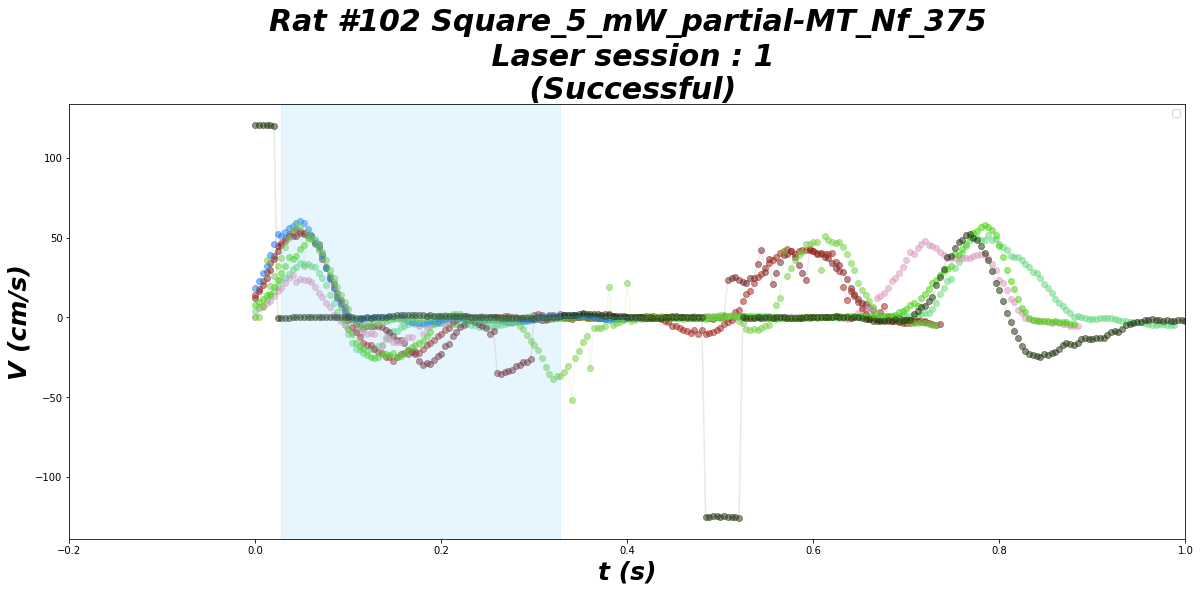

In [60]:
def plot_laser_velocity(n,files_list_DLC,files_list_LED,path,folder):


    file_name = files_list_DLC[n]
    print(file_name)

    df = read_DLC_csv(files_list_DLC[n],fp_trial)
    df_LED = read_LED_csv(files_list_LED[n],len(df.index))
    where_plot,what_plot = [0],0
    body_part = body_part_list[where_plot]
    i = 0
    j = 0
    session = extract_opto_epochs(df,df_LED, r_or_l,path,folder,fp_trial,body_part,frame_height,n_timebin,
                             velocity_mask,p_cutoff,pad_thresh,max_allowed_v,pad_length_cm,t_s,jitter_threshold,
                       laser_protocol, laser_pulse, laser_intensity)  
    print(np.max(session.velocity_r , axis = 1))
    laser = Laser(session)
    print(np.max(laser.velocity_r , axis = 1))
#     print(laser.starts)
    failed = Failed(laser)
    successful = Successful(laser)
    print(np.max(successful.velocity_r , axis = 1))
    plt.figure(1)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 8), sharey=True)
    for j in range (0,successful.n_trials):
        overall_ind, = np.where(successful.velocity_r[j,:] != velocity_mask )
        print(np.max(successful.velocity_r[j,:]))
        ind = np.arange(successful.laser_duration[j],dtype = int)+int(successful.laser_start[j])
        rgba_colors = np.zeros((4))
        rgba_colors[:-1] = np.random.random((3))
        rgba_colors[3] = 0.5
        time_series_overall = (np.arange(successful.pad_off_t[j],successful.got_reward_t[j])-successful.pad_off_t[j])/fps

        plt.scatter(time_series_overall,successful.velocity_r[j,overall_ind], color = rgba_colors )
        plt.plot(time_series_overall,successful.velocity_r[j,overall_ind], color = rgba_colors[:-1],alpha = 0.1 )
        if len(ind) != 0: # it could be possible that the hand doesn't leave the pad during laser
            time_series_laser = (np.arange(successful.laser_duration[j])+successful.laser_start[j]-successful.pad_off_t[j])/fps
#             plt.plot(time_series_laser,-successful.velocity_r[j,ind], c = 'navy', alpha = 0.5 )

#     print("laser start" , successful.laser_start) 
#     print(" pad off :" , successful.pad_off_t)
#     print("laser off :", successful.laser_duration+successful.laser_start)
#     print("reward", successful.got_reward_t )
    plt.axvspan(min(successful.laser_start)/fps, min(successful.laser_start)/fps+ max(successful.laser_duration)/fps, alpha=0.2, color='lightskyblue')
    plt.title("Rat #"+str(rat_no)+" "+folder+"\n Laser session : "+str(n+1)+"\n (Successful)").set_fontproperties(font)
    plt.ylabel("V (cm/s)").set_fontproperties(font_label)
    plt.xlabel("t (s)").set_fontproperties(font_label)
    plt.legend(fontsize = 10)
    plt.xlim(-0.2,1)
#     plt.ylim(-20,70)
#     plt.xlim(0.2,0.3)
    plt.savefig(pre_direct+'/Subplots/'+'Velocity_Rat_'+str(rat_no)+'_'+folder+'_session = '+str(n+1)+
                     '.png',bbox_inches='tight',orientation='landscape',dpi=200)
    

rat_no = 102;
where_plot,what_plot = [0],0
body_part = body_part_list[where_plot]
contain_laser = True
p_cutoff = 0.2
# folder = "Square_2-5_mW_partial-MT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Square_5_mW_all-RT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_20_mW_all-RT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_15_mW_all-MT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_10_mW_all-RT_Nf_375" ; exp_par = 'Laser_ChR2' ; frame_height = 400
folder = "Square_5_mW_partial-MT_Nf_375" ; exp_par = 'Laser_ChR2' ; frame_height = 300
prop = folder.split('_')
laser_protocol = prop[3] ; laser_pulse = prop[0]; laser_intensity = prop[1]; fp_trial = int(prop[5])
direct = pre_direct +'/'+exp_par+'/Rat_' +str(rat_no)+ '/'  # directory to the folder for each mouse
R_L_folder = [ f.name for f in os.scandir(direct+folder) if f.is_dir() ][0]
path = direct+folder + '/'+ R_L_folder
r_or_l = R_L_folder[0] # right or left hand

files_list_DLC = list_all_files(path +'/DLC/','.csv')
files_list_LED = list_all_files(path +'/LED/','.csv') 
for n in range(0,len(files_list_DLC)):
    plot_laser_velocity(n,files_list_DLC,files_list_LED,path,folder)




# Non Laser 

## Trajectory

R
/home/shiva/Desktop/Rat_Lever_Analysis/Laser_ChR2/Rat_102/Square_5_mW_partial-MT_Nf_375/Right/DLC/Rat102_partialMT-5mW_21072017_2camera_chrono_20170721_160420_C001H001S0001DLC_resnet50_Rat_lever_Velentin_Rat_102May13shuffle1_250000.csv
to discard  10
# second order jitter : 1
n trials =  31
low prob 5
low prob 5
low prob 1
low prob 10
low prob 11
low prob 3
low prob 7
low prob 8
low prob 1
low prob 12
low prob 7


/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:435: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


low prob 2
low prob 4
low prob 14
low prob 5
low prob 5
low prob 2
low prob 3
low prob 2
low prob 5


<Figure size 432x288 with 0 Axes>

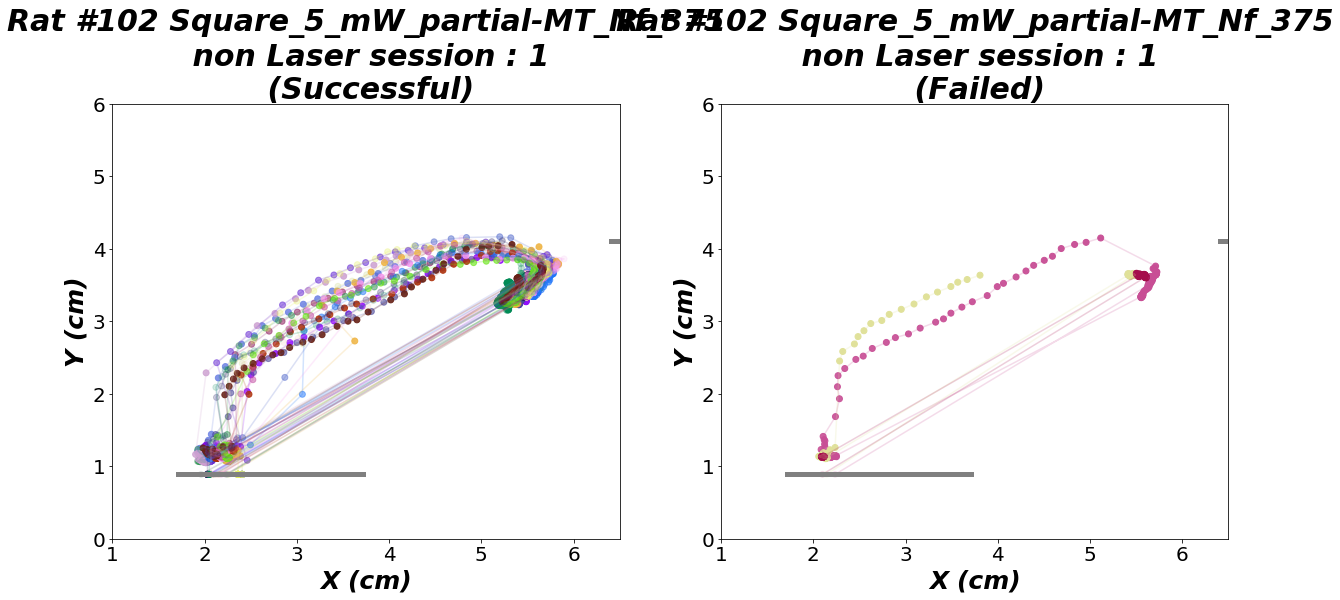

In [134]:

def plot_non_laser_trajectory(n,files_list_DLC,files_list_LED,path,folder):


    file_name = files_list_DLC[n]
    print(file_name)
    df = read_DLC_csv(files_list_DLC[n],fp_trial)
    df_LED = read_LED_csv(files_list_LED[n],len(df.index))
    where_plot,what_plot = [0],0
    body_part = body_part_list[where_plot]
    i = 0
    j = 0
    session = extract_opto_epochs(df,df_LED, r_or_l,path,folder,fp_trial,body_part,frame_height,n_timebin,
                             velocity_mask,p_cutoff,pad_thresh,max_allowed_v,pad_length_cm,t_s,jitter_threshold,
                       laser_protocol, laser_pulse, laser_intensity)

    non_laser = Non_Laser(session)
#     print(non_laser.laser_trial)
    failed = Failed(non_laser)
    successful = Successful(non_laser)
#     print("succ distace:",successful.distance)
#     print("fail distace:",failed.distance)
#     print(" succeeded = ", successful.n_trials,"\n failed = ", failed.n_trials, "\n pad miss detections = ", session.n_pad_miss_detection)
#     print(" max trial time = ", successful.max_time/fps*1000 ," ms", "\n min trial time = ", successful.min_time/fps*1000 ," ms")
    plt.figure(1)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), sharey=True)
    ax[0] = plt.subplot(121)
    for j in range (0,successful.n_trials):
#     for j in range (m,m+1):
        print("low prob",(sum(successful.likelihood[j] < p_cutoff)))
        successful.epochs_x[j,successful.likelihood[j] < p_cutoff] = -1
        overall_ind, = np.where(successful.epochs_x[j,:] != -1 )
        ind = np.arange(successful.laser_duration[j],dtype = int)+int(successful.laser_start[j])
#         print("epoch",successful.epochs_x[j,:])
#         print("pad" ,successful.pad_off_t[j])
        alphas = np.linspace(0.1, 1, len(overall_ind))
        rgba_colors = np.zeros((len(overall_ind),4))
        rgba_colors[:,:-1] = np.random.random((3))
        rgba_colors[:, 3] = alphas
        plt.scatter(successful.epochs_x[j,overall_ind],successful.epochs_y[j,overall_ind], color = rgba_colors )
        plt.plot(successful.epochs_x[j,overall_ind],successful.epochs_y[j,overall_ind],alpha = 0.2, color = rgba_colors[0,:-1] )

    plt.plot([session.lever_x[0] - 0.1, session.lever_x[0] + 0.1],[session.lever_y[0],session.lever_y[0]],lw = 5, c = 'grey')
    plt.plot([session.pad_left_x[0],session.pad_right_x[0]],[session.pad_y[0],session.pad_y[0]],lw = 5, c = 'grey')

    plt.title("Rat #"+str(rat_no)+" "+folder+"\n non Laser session : "+str(n+1)+"\n (Successful)").set_fontproperties(font)
    plt.ylabel("Y (cm)").set_fontproperties(font_label)
    plt.xlabel("X (cm)").set_fontproperties(font_label)
#     plt.legend(fontsize = 10)
    plt.xlim(1,6.5)
    plt.ylim(0,6)
    set_ticks(ax[0])
    ax[1] = plt.subplot(122)

    for i in range (0,failed.n_trials):
        failed.epochs_x[i,failed.likelihood[i] < p_cutoff] = -1
        overall_ind, = np.where(failed.epochs_x[i,:] != -1 )
        ind = np.arange(failed.laser_duration[i],dtype = int)+int(failed.laser_start[i]) 
        alphas = np.linspace(0.1, 1, len(overall_ind))
        rgba_colors = np.zeros((len(overall_ind),4))
        rgba_colors[:,:-1] = np.random.random((3))
        rgba_colors[:, 3] = alphas
        plt.scatter(failed.epochs_x[i,overall_ind],failed.epochs_y[i,overall_ind], color = rgba_colors )
        plt.plot(failed.epochs_x[i,overall_ind],failed.epochs_y[i,overall_ind],alpha = 0.2, color = rgba_colors[0,:-1] )

    plt.plot([session.lever_x[0] - 0.1, session.lever_x[0] + 0.1],[session.lever_y[0],session.lever_y[0]],lw = 5, c = 'grey')
    plt.plot([session.pad_left_x[0],session.pad_right_x[0]],[session.pad_y[0],session.pad_y[0]],lw = 5, c = 'grey')

    plt.title("Rat #"+str(rat_no)+" "+folder+"\n non Laser session : "+str(n+1)+'\n (Failed)').set_fontproperties(font)
    plt.ylabel("Y (cm)").set_fontproperties(font_label)
    plt.xlabel("X (cm)").set_fontproperties(font_label)
    plt.xlim(1,6.5)
    plt.ylim(0,6)
    set_ticks(ax[1])
    plt.savefig(pre_direct+'/Subplots/'+'Rat_'+str(rat_no)+'_'+folder+'_non_laser_session = '+str(n+1)+
                 '.png',bbox_inches='tight',orientation='landscape',dpi=200)

    
    return session


rat_no = 102; exp_par = 'Laser_ChR2'
contain_laser = True
# folder = "Square_2-5_mW_partial-MT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Square_5_mW_all-RT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_20_mW_all-RT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_15_mW_all-MT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_10_mW_all-RT_Nf_375" ; exp_par = 'Laser_ChR2' ; frame_height = 400
folder = "Square_5_mW_partial-MT_Nf_375" ; exp_par = 'Laser_ChR2' ; frame_height = 300
m = 1
p_cutoff = 0.5
prop = folder.split('_')
laser_protocol = prop[3] ; laser_pulse = prop[0]; laser_intensity = prop[1]; fp_trial = int(prop[5])
direct = pre_direct +'/'+exp_par+'/Rat_' +str(rat_no)+ '/'  # directory to the folder for each mouse
R_L_folder = [ f.name for f in os.scandir(direct+folder) if f.is_dir() ][0]
path = direct+folder + '/'+ R_L_folder
r_or_l = R_L_folder[0] # right or left hand
print(r_or_l)
files_list_DLC = list_all_files(path +'/DLC/','.csv')
files_list_LED = list_all_files(path +'/LED/','.csv')
for n in range(0,1):#len(files_list_DLC)):
    plot_non_laser_trajectory(n,files_list_DLC,files_list_LED,path,folder)


/home/shiva/Desktop/Rat_Lever_Analysis/ChR2/Rat_1/Beta_10_mW_all-RT_Nf_375/Left/DLC/Rat1_beta_10mW_20190529_162228_C001H001S0001DLC_resnet50_Rat_lever_Sophie_Rat_1Apr26shuffle1_250000.csv
# jitter in DLC  =  179
# jitter in DLC  =  108
jitter  [8]
jitter  [3]
jitter  []
jitter  [6]
jitter  []
jitter  [5]
jitter  []
jitter  [2]
jitter  [6]
jitter  [6]
jitter  []
jitter  [7]
jitter  []
jitter  []
jitter  [6]
jitter  []
jitter  []
jitter  []
jitter  [7]
jitter  []
jitter  [5]
jitter  [6]
jitter  [4 6]
jitter  []
jitter  []
jitter  []
jitter  [6]
jitter  []
jitter  []
start 1500


/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:310: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


<Figure size 432x288 with 0 Axes>

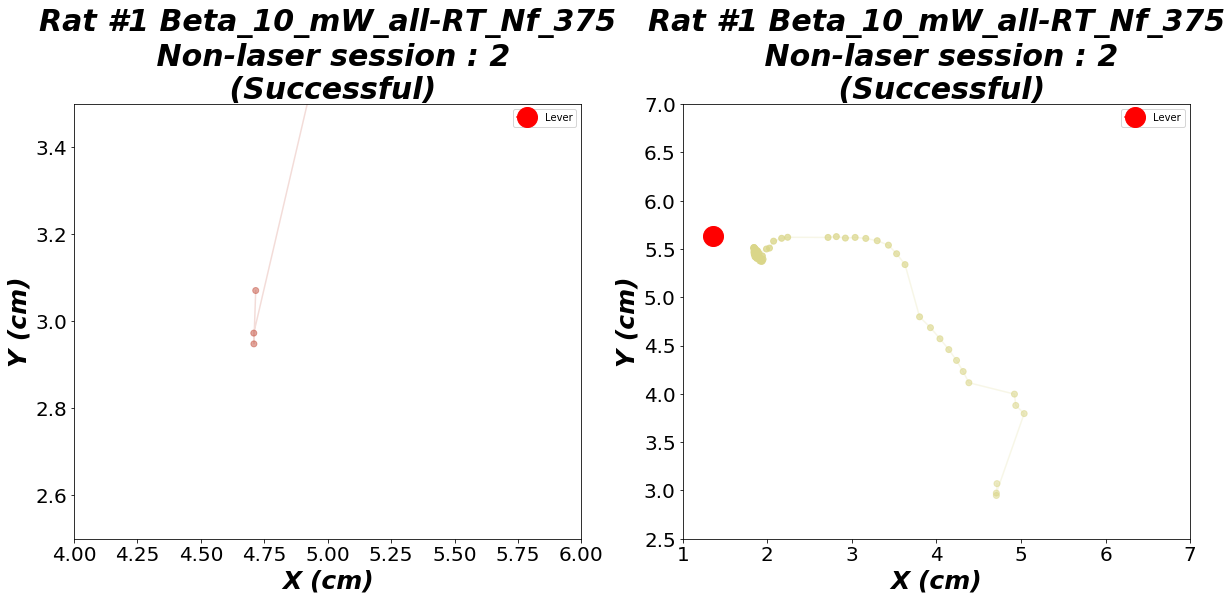

In [22]:
jitter_threshold = 30/fps
def plot_non_laser_trajectory(n,files_list_DLC,files_list_LED,path,folder):


    file_name = files_list_DLC[n]
    print(file_name)
    df = read_DLC_csv(files_list_DLC[n],fp_trial)
    df_LED = read_LED_csv(files_list_LED[n],len(df.index))
    body_part,what_plot = [0],0
    i = 0
    j = 0
    session = extract_opto_epochs(df,df_LED, r_or_l,path,folder,fp_trial,body_part,frame_height,n_timebin,
                             velocity_mask,p_cutoff,pad_thresh,max_allowed_v,pad_length_cm,t_s,jitter_threshold,
                       laser_protocol, laser_pulse, laser_intensity)
    non_laser = Non_Laser(session)
#     print(non_laser.laser_trial)
    failed = Failed(non_laser)
    successful = Successful(non_laser)
#     print("succ distace:",successful.distance)
#     print("fail distace:",failed.distance)
#     print(" succeeded = ", successful.n_trials,"\n failed = ", failed.n_trials, "\n pad miss detections = ", session.n_pad_miss_detection)
#     print(" max trial time = ", successful.max_time/fps*1000 ," ms", "\n min trial time = ", successful.min_time/fps*1000 ," ms")
    plt.figure(1)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), sharey=True)
    ax[0] = plt.subplot(121)
    for j in range (1,2):#successful.n_trials-1):
        print("start",successful.starts[j])
#         print("lever", successful.got_reward_t[j])
        overall_ind, = np.where(successful.epochs_x[j,:] != -1 )
        alphas = np.linspace(0.5, 1, len(overall_ind))
        rgba_colors = np.zeros((len(overall_ind),4))
        rgba_colors[:,:-1] = np.random.random((3))
        rgba_colors[:, 3] = alphas
        plt.scatter(successful.epochs_x[j,overall_ind],successful.epochs_y[j,overall_ind], color = rgba_colors )
        plt.plot(successful.epochs_x[j,overall_ind],successful.epochs_y[j,overall_ind],alpha = 0.2, color = rgba_colors[0,:-1] )

    plt.plot([lever_x],[lever_y], marker='o',markersize=20,c = 'r',label = "Lever")
    plt.title("Rat #"+str(rat_no)+" "+folder+"\n Non-laser session : "+str(n+1)+"\n (Successful)").set_fontproperties(font)
    plt.ylabel("Y (cm)").set_fontproperties(font_label)
    plt.xlabel("X (cm)").set_fontproperties(font_label)
    plt.legend(fontsize = 10)
    plt.xlim(4,6)
    plt.ylim(2.5,3.5)
    set_ticks(ax[0])
    ax[1] = plt.subplot(122)
    for j in range (1,2):#successful.n_trials-1):
#         print("start",successful.starts[j])
#         print("lever", successful.got_reward_t[j])
        overall_ind, = np.where(successful.epochs_x[j,:] != -1 )
        alphas = np.linspace(0.5, 1, len(overall_ind))
        rgba_colors = np.zeros((len(overall_ind),4))
        rgba_colors[:,:-1] = np.random.random((3))
        rgba_colors[:, 3] = alphas
        plt.scatter(successful.epochs_x[j,overall_ind],successful.epochs_y[j,overall_ind], color = rgba_colors )
        plt.plot(successful.epochs_x[j,overall_ind],successful.epochs_y[j,overall_ind],alpha = 0.2, color = rgba_colors[0,:-1] )

    plt.plot([lever_x],[lever_y], marker='o',markersize=20,c = 'r',label = "Lever")
    plt.title("Rat #"+str(rat_no)+" "+folder+"\n Non-laser session : "+str(n+1)+"\n (Successful)").set_fontproperties(font)
    plt.ylabel("Y (cm)").set_fontproperties(font_label)
    plt.xlabel("X (cm)").set_fontproperties(font_label)
    plt.legend(fontsize = 10)
    plt.xlim(1,7)
    plt.ylim(2.5,7)
#     for i in range (0,1):#failed.n_trials):
#         overall_ind, = np.where(failed.epochs_x[i,:] != -1 )
#         alphas = np.linspace(0.1, 1, len(overall_ind))
#         rgba_colors = np.zeros((len(overall_ind),4))
#         rgba_colors[:,:-1] = np.random.random((3))
#         rgba_colors[:, 3] = alphas
#         plt.scatter(failed.epochs_x[i,overall_ind],failed.epochs_y[i,overall_ind], color = rgba_colors )


#     plt.plot([lever_x],[lever_y], marker='o',markersize=20,c = 'r',label = "Lever")
#     plt.title("Rat #"+str(rat_no)+" "+folder+"\n Non-Laser session : "+str(n+1)+'\n (Failed)').set_fontproperties(font)
#     plt.ylabel("Y (cm)").set_fontproperties(font_label)
#     plt.xlabel("X (cm)").set_fontproperties(font_label)
#     plt.legend(fontsize = 10)
#     plt.xlim(1,7)
#     plt.ylim(2.5,7)
    set_ticks(ax[1])
#     plt.savefig(pre_direct+'/Subplots/'+'Rat_'+str(rat_no)+'_'+folder+'_Non_Laser_session = '+str(n+1)+
#                  '.png',bbox_inches='tight',orientation='landscape',dpi=200)

    return session


rat_no = 1; exp_par = 'Laser_ChR2'
r_or_l = 'L'
# folder = "Square_2-5_mW_partial-MT_Nf_375"
# folder = "Square_5_mW_all-RT_Nf_500"
# folder = "Beta_20_mW_all-RT_Nf_375"
# folder = "Beta_15_mW_all-MT_Nf_500"
folder = "Beta_10_mW_all-RT_Nf_375"
frame_width_crop = 0 ; frame_height_crop = 0
lever_x = 77*scale_pix_to_cm ; lever_y = frame_height - (194-frame_height_crop)*scale_pix_to_cm
prop = folder.split('_')
laser_protocol = prop[3] ; laser_pulse = prop[0]; laser_intensity = prop[1]; fp_trial = int(prop[5])
direct = pre_direct +'/'+exp_par+'/Rat_' +str(rat_no)+ '/'  # directory to the folder for each mouse
R_L_folder = 'Left'
path = direct+folder+ '/'+R_L_folder
r_or_l = R_L_folder[0]
files_list_DLC = list_all_files(path +'/DLC/','.csv')
files_list_LED = list_all_files(path +'/LED/','.csv')
for n in range(1,2):#len(files_list_DLC)):
    plot_non_laser_trajectory(n,files_list_DLC,files_list_LED,path,folder)


## Velocity

/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:420: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
No handles with labels found to put in legend.


to discard  10
# second order jitter : 5
n trials =  31


<Figure size 432x288 with 0 Axes>

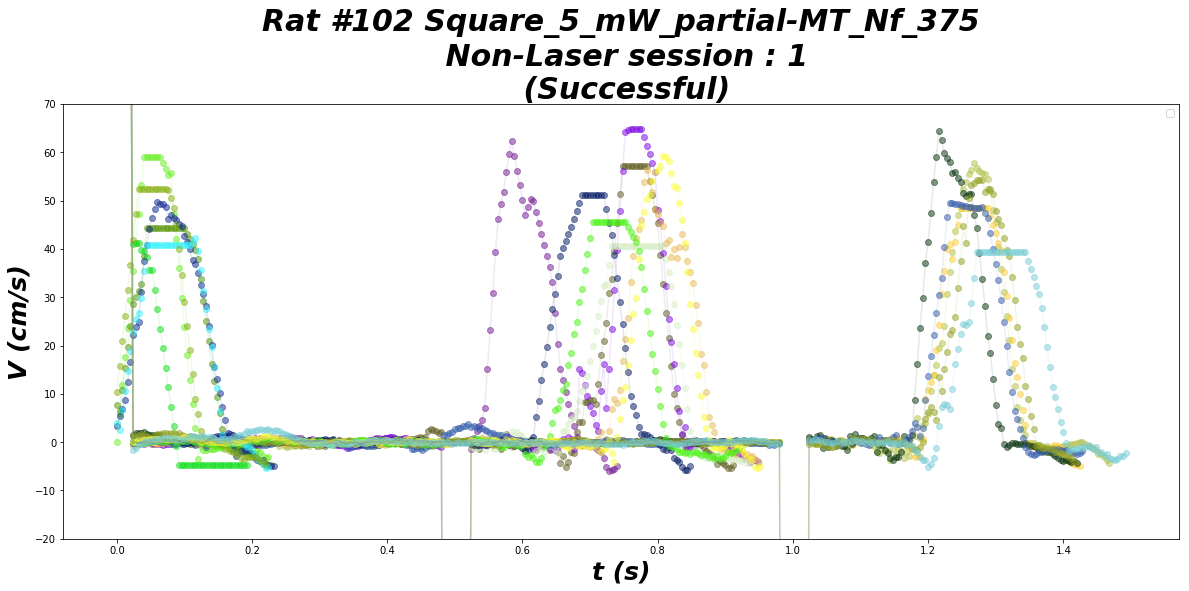

In [114]:

def plot_non_laser_velocity(n,files_list_DLC,files_list_LED,path,folder):


    file_name = files_list_DLC[n]
    df = read_DLC_csv(files_list_DLC[n],fp_trial)
    df_LED = read_LED_csv(files_list_LED[n],len(df.index))
    body_part = body_part_list[where_plot]
    i = 0
    j = 0
    session = extract_opto_epochs(df,df_LED, r_or_l,path,folder,fp_trial,body_part,frame_height,n_timebin,
                             velocity_mask,p_cutoff,pad_thresh,max_allowed_v,pad_length_cm,t_s,jitter_threshold,
                       laser_protocol, laser_pulse, laser_intensity)  

    laser = Non_Laser(session)
    failed = Failed(laser)
    successful = Successful(laser)
    plt.figure(1)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 8), sharey=True)
    for j in range (0,successful.n_trials):
        overall_ind, = np.where(successful.velocity_r[j,:] != velocity_mask )
        rgba_colors = np.zeros((4))
        rgba_colors[:-1] = np.random.random((3))
        rgba_colors[3] = 0.5
        time_series_overall = np.arange(len(overall_ind))/fps
        plt.scatter(time_series_overall,successful.velocity_r[j,overall_ind], color = rgba_colors )
        plt.plot(time_series_overall,successful.velocity_r[j,overall_ind], color = rgba_colors[:-1],alpha = 0.1 )

    plt.title("Rat #"+str(rat_no)+" "+folder+"\n Non-Laser session : "+str(n+1)+"\n (Successful)").set_fontproperties(font)
    plt.ylabel("V (cm/s)").set_fontproperties(font_label)
    plt.xlabel("t (s)").set_fontproperties(font_label)
    plt.legend(fontsize = 10)
    # plt.xlim(2,7)
    plt.ylim(-20,70)
    plt.savefig(pre_direct+'/Subplots/'+'Velocity_Rat_'+str(rat_no)+'_'+folder+'_Non-Laser_session = '+str(n+1)+
                     '.png',bbox_inches='tight',orientation='landscape',dpi=200)
    

rat_no = 102;
where_plot,what_plot = [0],0
body_part = body_part_list[where_plot]
contain_laser = True
# folder = "Square_2-5_mW_partial-MT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Square_5_mW_all-RT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_20_mW_all-RT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_15_mW_all-MT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_10_mW_all-RT_Nf_375" ; exp_par = 'Laser_ChR2' ; frame_height = 400
folder = "Square_5_mW_partial-MT_Nf_375" ; exp_par = 'Laser_ChR2' ; frame_height = 300
prop = folder.split('_')
laser_protocol = prop[3] ; laser_pulse = prop[0]; laser_intensity = prop[1]; fp_trial = int(prop[5])
direct = pre_direct +'/'+exp_par+'/Rat_' +str(rat_no)+ '/'  # directory to the folder for each mouse
R_L_folder = [ f.name for f in os.scandir(direct+folder) if f.is_dir() ][0]
path = direct+folder + '/'+ R_L_folder
r_or_l = R_L_folder[0] # right or left hand

files_list_DLC = list_all_files(path +'/DLC/','.csv')
files_list_LED = list_all_files(path +'/LED/','.csv') 
for n in range(0,len(files_list_DLC)):
    plot_non_laser_velocity(n,files_list_DLC,files_list_LED,path,folder)



# Compare $Traveled\: distance$ laser vs. non laser

/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:646: RuntimeWarning: invalid value encountered in multiply


to discard  0
# second order jitter : 0
n trials =  32
to discard  0
# second order jitter : 0
n trials =  32
to discard  0
# second order jitter : 0
n trials =  32
to discard  0
# second order jitter : 0
n trials =  32
to discard  0
# second order jitter : 0
n trials =  5
to discard  0
# second order jitter : 0
n trials =  32
to discard  0
# second order jitter : 1
n trials =  32
to discard  0
# second order jitter : 0
n trials =  32
to discard  0
# second order jitter : 0
n trials =  32
to discard  0
# second order jitter : 0
n trials =  19
to discard  0
# second order jitter : 0
n trials =  32
to discard  0
# second order jitter : 0
n trials =  32
to discard  0
# second order jitter : 0
n trials =  32
to discard  0
# second order jitter : 0
n trials =  32
to discard  0
# second order jitter : 0
n trials =  31
to discard  0
# second order jitter : 0
n trials =  2
x (8,)
y (8,)
dis (8,)
tor (8,)
x (155,)
y (155,)
dis (155,)
tor (155,)
laser success trials =  155
laser failed trials = 

/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:435: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


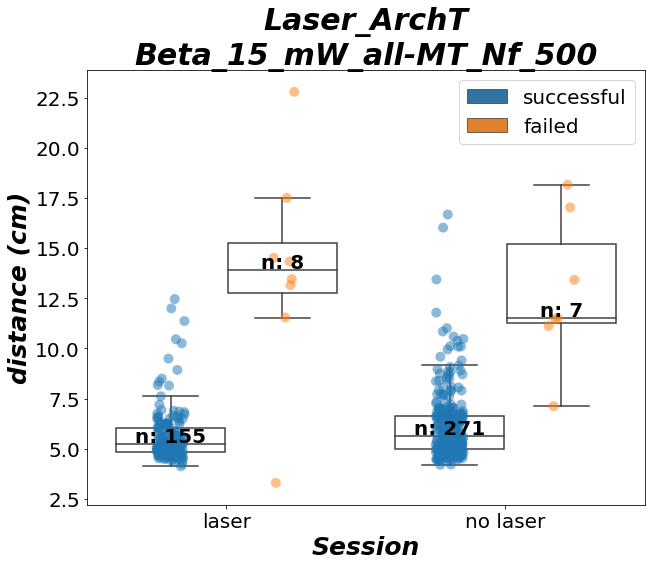

In [209]:
where_plot,what_plot = [0],0
body_part = body_part_list[where_plot]
contain_laser = True
p_cutoff = 0.8
# folder = "Square_2-5_mW_partial-MT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Square_5_mW_all-RT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_20_mW_all-RT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
folder = "Beta_15_mW_all-MT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_10_mW_all-RT_Nf_375" ; exp_par = 'Laser_ChR2' ; frame_height = 400
# folder = "Square_5_mW_partial-MT_Nf_375" ; exp_par = 'Laser_ChR2' ; frame_height = 300
pre_direct_chosen = pre_direct + '/' +exp_par
prop = folder.split('_')
laser_protocol = prop[3] ; laser_pulse = prop[0]; laser_intensity = prop[1]; fp_trial = int(prop[5])
# exp_par = 'Laser_ChR2'
exp_par = 'Laser_ArchT'
R_or_L_list, files_list_DLC, files_list_LED = find_all_files_same_protocol(pre_direct, folder)

all_sessions = extract_epochs_over_sessions(R_or_L_list, files_list_DLC, files_list_LED, folder, fp_trial,
                                 laser_protocol, laser_pulse, laser_intensity,contain_laser,body_part,frame_height,n_timebin,
                        velocity_mask,p_cutoff,pad_thresh,max_allowed_v,pad_length_cm,t_s,jitter_threshold)
laser = Laser(all_sessions)
laser_failed = Failed(laser)
laser_successful = Successful(laser)
print("laser success trials = ",laser_successful.n_trials)
print("laser failed trials = ",laser_failed.n_trials)
non_laser = Non_Laser(all_sessions)
print(non_laser.path.shape)
normal_failed = Failed(non_laser)
normal_successful = Successful(non_laser)
print("normal success trials = ",normal_successful.n_trials)
print("normal failed trials = ",normal_failed.n_trials)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))

col_names =  ['distance', 'trial', 'laser']
result = pd.DataFrame(columns = col_names)
print(laser_successful.distance.shape)
df = pd.DataFrame(({'distance':laser_successful.distance, 'trial':['successful']*len(laser_successful.pad_off_t), 'laser':['laser']*len(laser_successful.pad_off_t)}))
df1 = pd.DataFrame(({'distance':laser_failed.distance, 'trial':['failed']*len(laser_failed.pad_off_t), 'laser':['laser']*len(laser_failed.pad_off_t)}))
df2 = pd.DataFrame(({'distance':normal_successful.distance, 'trial':['successful']*len(normal_successful.pad_off_t), 'laser':['no laser']*len(normal_successful.pad_off_t)}))
df3 = pd.DataFrame(({'distance':normal_failed.distance, 'trial':['failed']*len(normal_failed.pad_off_t), 'laser':['no laser']*len(normal_failed.pad_off_t)}))

# print("out",np.where(laser_successful.distance < 2))
n = 11
# ind, = np.where(laser_successful.likelihood[n] > p_cutoff) 
# ind_bad, = np.where(laser_successful.likelihood[n] < p_cutoff)
# print(len(ind),len(laser_successful.likelihood[n]))
# # plt.plot(laser_successful.epochs_x[n,ind],laser_successful.epochs_y[11,ind],'-o')
# plt.plot(laser_successful.epochs_x[n],laser_successful.epochs_y[11],'-o',c = 'g')
# plt.plot(laser_successful.epochs_x[n,ind_bad],laser_successful.epochs_y[11,ind_bad],'-o',c = 'r')
# plt.plot([laser_successful.lever_x[n] - 0.1, laser_successful.lever_x[n] + 0.1],[laser_successful.lever_y[n],laser_successful.lever_y[n]],lw = 5, c = 'grey')
# plt.plot([laser_successful.pad_left_x[n],laser_successful.pad_right_x[n]],[laser_successful.pad_y[n],laser_successful.pad_y[0]],lw = 5, c = 'grey')

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))

result = pd.concat([result, df, df1, df2, df3],ignore_index=True)
# print((normal_failed.path))
# print(normal_failed.starts)

set_ticks(ax)
ax = sns.stripplot(x="laser", y="distance", order=["laser", "no laser"],hue="trial",dodge=True, data=result,jitter=True, 
                   marker='o', size = 10,
                   alpha=0.5)
ax = sns.boxplot(x="laser", y="distance", order=["laser", "no laser"],hue="trial",dodge=True, 
            data=result, boxprops={'facecolor':'None'}, fliersize = 0)

medians = result.groupby(['laser','trial'])['distance'].median()
nobs =  result.groupby(['laser','trial']).apply(lambda x: 'n: {}'.format(len(x)))
for tick, label in enumerate(ax.get_xticklabels()):
    ax_laser = label.get_text()
    for j, ax_trial in enumerate(ax.get_legend_handles_labels()[1][:2]):
        x_offset = (j - 0.5) * 2/5
        med_val = medians[ ax_laser, ax_trial]
        num = nobs[ax_laser, ax_trial]
        
        ax.text(tick + x_offset, med_val + 0.1, num,
                horizontalalignment='center', size=20, color='k', weight='semibold')
# get legend information from the plot object
handles, labels = ax.get_legend_handles_labels()
# specify just one legend
plt.legend(handles[0:2], labels[0:2], fontsize = 20)
plt.ylabel('distance (cm)').set_fontproperties(font_label)
plt.xlabel('Session').set_fontproperties(font_label)

plt.title(exp_par+'\n'+folder).set_fontproperties(font)
plt.savefig(pre_direct+'/Subplots/'+'Distance_Rat_'+folder+'_'+exp_par+
                     '.png',bbox_inches='tight',orientation='landscape',dpi=200)


# Compare $MT$ laser vs. non laser

/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:598: RuntimeWarning: invalid value encountered in multiply
/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:600: RuntimeWarning: invalid value encountered in multiply
/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:602: RuntimeWarning: invalid value encountered in multiply
/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:621: RuntimeWarning: invalid value encountered in multiply


to discard  0
# second order jitter : 0
n trials =  32
to discard  0
# second order jitter : 0
n trials =  32
to discard  0
# second order jitter : 0
n trials =  32
to discard  0
# second order jitter : 0
n trials =  32
to discard  0
# second order jitter : 0
n trials =  5
to discard  0
# second order jitter : 0
n trials =  32
to discard  0
# second order jitter : 1
n trials =  32
to discard  0
# second order jitter : 0
n trials =  32
to discard  0
# second order jitter : 0
n trials =  32
to discard  0
# second order jitter : 0
n trials =  19
to discard  0
# second order jitter : 2
n trials =  32
to discard  0
# second order jitter : 0
n trials =  32
to discard  0
# second order jitter : 0
n trials =  32
to discard  0
# second order jitter : 0
n trials =  32
to discard  0
# second order jitter : 2
n trials =  32
to discard  0
# second order jitter : 0
n trials =  2
laser success trials =  155
laser failed trials =  8
(279,)
normal success trials =  271
normal failed trials =  8


/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:427: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


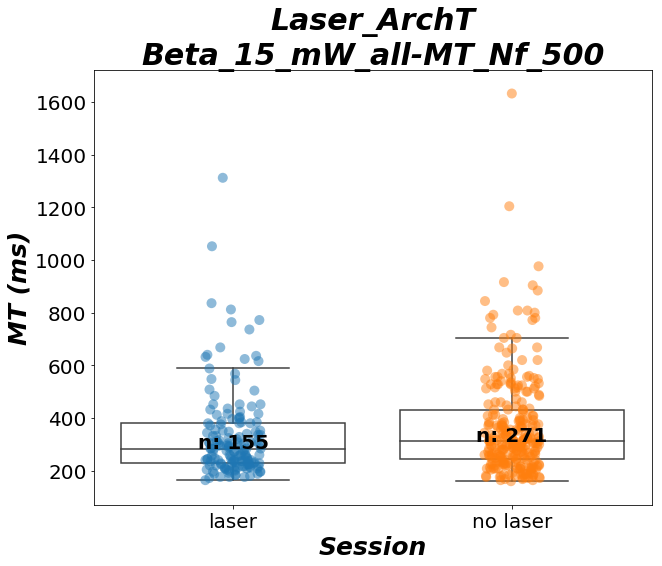

In [61]:
where_plot,what_plot = [0],0
body_part = body_part_list[where_plot]
contain_laser = True
# folder = "Square_2-5_mW_partial-MT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Square_5_mW_all-RT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_20_mW_all-RT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
folder = "Beta_15_mW_all-MT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_10_mW_all-RT_Nf_375" ; exp_par = 'Laser_ChR2' ; frame_height = 400
# folder = "Square_5_mW_partial-MT_Nf_375" ; exp_par = 'Laser_ChR2' ; frame_height = 300
prop = folder.split('_')
laser_protocol = prop[3] ; laser_pulse = prop[0]; laser_intensity = prop[1]; fp_trial = int(prop[5])
# exp_par = 'Laser_ChR2'
# exp_par = 'Laser_ArchT'
pre_direct_chosen = pre_direct + '/' +exp_par
R_or_L_list, files_list_DLC, files_list_LED = find_all_files_same_protocol(pre_direct_chosen, folder)
all_sessions = extract_epochs_over_sessions(R_or_L_list, files_list_DLC, files_list_LED, folder, fp_trial,
                                 laser_protocol, laser_pulse, laser_intensity,contain_laser,body_part,frame_height,n_timebin,
                        velocity_mask,p_cutoff,pad_thresh,max_allowed_v,pad_length_cm,t_s,jitter_threshold)
laser = Laser(all_sessions)
laser_failed = Failed(laser)
laser_successful = Successful(laser)
print("laser success trials = ",laser_successful.n_trials)
print("laser failed trials = ",laser_failed.n_trials)
non_laser = Non_Laser(all_sessions)
print(non_laser.path.shape)
normal_failed = Failed(non_laser)
normal_successful = Successful(non_laser)
print("normal success trials = ",normal_successful.n_trials)
print("normal failed trials = ",normal_failed.n_trials)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))

col_names =  ['MT', 'trial', 'laser']
result = pd.DataFrame(columns = col_names)
df = pd.DataFrame(({'MT':laser_successful.got_reward_t- laser_successful.pad_off_t, 'trial':['successful']*len(laser_successful.pad_off_t), 'laser':['laser']*len(laser_successful.pad_off_t)}))
# df1 = pd.DataFrame(({'MT':laser_failed.pad_off_t, 'trial':['failed']*len(laser_failed.pad_off_t), 'laser':['laser']*len(laser_failed.pad_off_t)}))
df2 = pd.DataFrame(({'MT':normal_successful.got_reward_t - normal_successful.pad_off_t, 'trial':['successful']*len(normal_successful.pad_off_t), 'laser':['no laser']*len(normal_successful.pad_off_t)}))
# df3 = pd.DataFrame(({'MT':normal_failed.pad_off_t, 'trial':['failed']*len(normal_failed.pad_off_t), 'laser':['no laser']*len(normal_failed.pad_off_t)}))


result = pd.concat([result, df, df2],ignore_index=True)
result['MT'] = result['MT']*4
# print((normal_failed.path))
# print(normal_failed.starts)

set_ticks(ax)
ax = sns.stripplot(x="laser", y="MT", order=["laser", "no laser"], data=result,jitter=True, 
                   marker='o', size = 10,
                   alpha=0.5)
ax = sns.boxplot(x="laser", y="MT", order=["laser", "no laser"], 
            data=result, boxprops={'facecolor':'None'}, fliersize = 0)

medians = result.groupby(['laser'])['MT'].median()
nobs =  result.groupby(['laser']).apply(lambda x: 'n: {}'.format(len(x)))
for tick, label in enumerate(ax.get_xticklabels()):
    ax_laser = label.get_text()
    x_offset = tick
    med_val = medians[ ax_laser]
    num = nobs[ax_laser]
        
    ax.text(tick, med_val + 0.1, num,
                horizontalalignment='center', size=20, color='k', weight='semibold')
# get legend information from the plot object
# handles, labels = ax.get_legend_handles_labels()
# specify just one legend
# plt.legend(handles[0:2], labels[0:2], fontsize = 20)
plt.ylabel('MT (ms)').set_fontproperties(font_label)
plt.xlabel('Session').set_fontproperties(font_label)

plt.title(exp_par+'\n'+folder).set_fontproperties(font)
plt.savefig(pre_direct+'/Subplots/'+'MT_Rat_'+folder+'_'+exp_par+
                     '.png',bbox_inches='tight',orientation='landscape',dpi=200)
    
# plt.show()


# print(result.head())
# ax = sns.swarmplot(x="day", y="total_bill", hue="smoker",

#                    data=tips, palette="Set2", dodge=True)

# Compare $RT$ laser vs. non laser

## all sessions of all rats for one protocol

number of sessionsf for Beta_15_mW_all-MT_Nf_500protocol  16
 number of session = 1 out of 16
/home/shiva/Desktop/Rat_Lever_Analysis/Laser_ArchT/Rat_3/Beta_15_mW_all-MT_Nf_500/Left/DLC/Rat3_Beta_15mW_20190516_201300_C001H001S0001DLC_resnet50_Rat_lever_Sophie_Rat_3avr28shuffle1_250000.csv
to discard  0
# second order jitter : 0
n trials =  32
 number of session = 2 out of 16
/home/shiva/Desktop/Rat_Lever_Analysis/Laser_ArchT/Rat_3/Beta_15_mW_all-MT_Nf_500/Left/DLC/Rat3_Beta_15mW_20190516_201945_C001H001S0001DLC_resnet50_Rat_lever_Sophie_Rat_3avr28shuffle1_250000.csv
to discard  0
# second order jitter : 0
n trials =  32
 number of session = 3 out of 16
/home/shiva/Desktop/Rat_Lever_Analysis/Laser_ArchT/Rat_3/Beta_15_mW_all-MT_Nf_500/Left/DLC/Rat3_Beta_15mW_20190516_202854_C001H001S0001DLC_resnet50_Rat_lever_Sophie_Rat_3avr28shuffle1_250000.csv
to discard  0
# second order jitter : 0
n trials =  32
 number of session = 4 out of 16
/home/shiva/Desktop/Rat_Lever_Analysis/Laser_ArchT/Rat_3/

/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:420: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


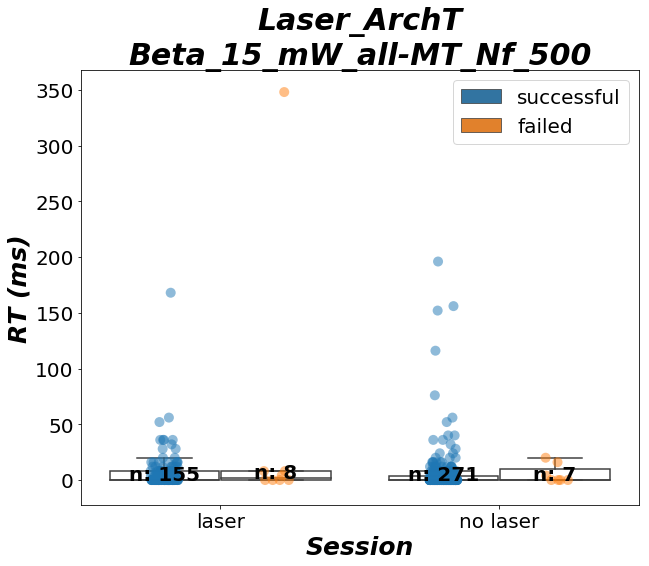

In [59]:
where_plot,what_plot = [0],0
body_part = body_part_list[where_plot]
contain_laser = True
# folder = "Square_2-5_mW_partial-MT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Square_5_mW_all-RT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_20_mW_all-RT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
folder = "Beta_15_mW_all-MT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_10_mW_all-RT_Nf_375" ; exp_par = 'Laser_ChR2' ; frame_height = 400
# folder = "Square_5_mW_partial-MT_Nf_375" ; exp_par = 'Laser_ChR2' ; frame_height = 300
prop = folder.split('_')
laser_protocol = prop[3] ; laser_pulse = prop[0]; laser_intensity = prop[1]; fp_trial = int(prop[5])
# exp_par = 'Laser_ChR2'
# exp_par = 'Laser_ArchT'
pre_direct_chosen = pre_direct + '/' +exp_par
R_or_L_list, files_list_DLC, files_list_LED = find_all_files_same_protocol(pre_direct_chosen, folder)
all_sessions = extract_epochs_over_sessions(R_or_L_list, files_list_DLC, files_list_LED, folder, fp_trial,
                                 laser_protocol, laser_pulse, laser_intensity,contain_laser,body_part,frame_height,n_timebin,
                        velocity_mask,p_cutoff,pad_thresh,max_allowed_v,pad_length_cm,t_s,jitter_threshold)
laser = Laser(all_sessions)
laser_failed = Failed(laser)
laser_successful = Successful(laser)
print("laser success trials = ",laser_successful.n_trials)
print("laser failed trials = ",laser_failed.n_trials)
non_laser = Non_Laser(all_sessions)
print(non_laser.path.shape)
normal_failed = Failed(non_laser)
normal_successful = Successful(non_laser)
print("normal success trials = ",normal_successful.n_trials)
print("normal failed trials = ",normal_failed.n_trials)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))

col_names =  ['RT', 'trial', 'laser']
result = pd.DataFrame(columns = col_names)
df = pd.DataFrame(({'RT':laser_successful.pad_off_t, 'trial':['successful']*len(laser_successful.pad_off_t), 'laser':['laser']*len(laser_successful.pad_off_t)}))
df1 = pd.DataFrame(({'RT':laser_failed.pad_off_t, 'trial':['failed']*len(laser_failed.pad_off_t), 'laser':['laser']*len(laser_failed.pad_off_t)}))
df2 = pd.DataFrame(({'RT':normal_successful.pad_off_t, 'trial':['successful']*len(normal_successful.pad_off_t), 'laser':['no laser']*len(normal_successful.pad_off_t)}))
df3 = pd.DataFrame(({'RT':normal_failed.pad_off_t, 'trial':['failed']*len(normal_failed.pad_off_t), 'laser':['no laser']*len(normal_failed.pad_off_t)}))


result = pd.concat([result, df, df1, df2, df3],ignore_index=True)
result['RT'] = result['RT']*4
# print((normal_failed.path))
# print(normal_failed.starts)

set_ticks(ax)
ax = sns.stripplot(x="laser", y="RT", order=["laser", "no laser"],hue="trial",dodge=True, data=result,jitter=True, 
                   marker='o', size = 10,
                   alpha=0.5)
ax = sns.boxplot(x="laser", y="RT", order=["laser", "no laser"],hue="trial",dodge=True, 
            data=result, boxprops={'facecolor':'None'}, fliersize = 0)

medians = result.groupby(['laser','trial'])['RT'].median()
nobs =  result.groupby(['laser','trial']).apply(lambda x: 'n: {}'.format(len(x)))
for tick, label in enumerate(ax.get_xticklabels()):
    ax_laser = label.get_text()
    for j, ax_trial in enumerate(ax.get_legend_handles_labels()[1][:2]):
        x_offset = (j - 0.5) * 2/5
        med_val = medians[ ax_laser, ax_trial]
        num = nobs[ax_laser, ax_trial]
        
        ax.text(tick + x_offset, med_val + 0.1, num,
                horizontalalignment='center', size=20, color='k', weight='semibold')
# get legend information from the plot object
handles, labels = ax.get_legend_handles_labels()
# specify just one legend
plt.legend(handles[0:2], labels[0:2], fontsize = 20)
plt.ylabel('RT (ms)').set_fontproperties(font_label)
plt.xlabel('Session').set_fontproperties(font_label)

plt.title(exp_par+'\n'+folder).set_fontproperties(font)
plt.savefig(pre_direct+'/Subplots/'+'RT_Rat_'+folder+'_'+exp_par+
                     '.png',bbox_inches='tight',orientation='landscape',dpi=200)
    
# plt.show()


# print(result.head())
# ax = sns.swarmplot(x="day", y="total_bill", hue="smoker",

#                    data=tips, palette="Set2", dodge=True)

## all sessions one rat

['/home/shiva/Desktop/Rat_Lever_Analysis/Laser_ArchT/Rat_2/Beta_15_mW_all-MT_Nf_500/Right/DLC/Rat2_Beta_15mW_20190516_171706_C001H002S0001DLC_resnet50_Rat_lever_Sophie_Rat_2Apr12shuffle1_250000.csv', '/home/shiva/Desktop/Rat_Lever_Analysis/Laser_ArchT/Rat_2/Beta_15_mW_all-MT_Nf_500/Right/DLC/Rat2_Beta_15mW_20190516_174513_C001H002S0001DLC_resnet50_Rat_lever_Sophie_Rat_2Apr12shuffle1_250000.csv', '/home/shiva/Desktop/Rat_Lever_Analysis/Laser_ArchT/Rat_2/Beta_15_mW_all-MT_Nf_500/Right/DLC/Rat2_Beta_15mW_20190516_180348_C001H002S0001DLC_resnet50_Rat_lever_Sophie_Rat_2Apr12shuffle1_250000.csv', '/home/shiva/Desktop/Rat_Lever_Analysis/Laser_ArchT/Rat_2/Beta_15_mW_all-MT_Nf_500/Right/DLC/Rat2_Beta_15mW_20190516_182118_C001H002S0001DLC_resnet50_Rat_lever_Sophie_Rat_2Apr12shuffle1_250000.csv', '/home/shiva/Desktop/Rat_Lever_Analysis/Laser_ArchT/Rat_2/Beta_15_mW_all-MT_Nf_500/Right/DLC/Rat2_Beta_15mW_20190516_184100_C001H002S0001DLC_resnet50_Rat_lever_Sophie_Rat_2Apr12shuffle1_250000.csv']
 num

/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:614: RuntimeWarning: invalid value encountered in multiply


to discard  0
# second order jitter : 0
n trials =  32
 number of session = 5 out of 5
to discard  0
# second order jitter : 0
n trials =  19
laser success trials =  58
laser failed trials =  4
(85,)
normal success trials =  83
normal failed trials =  2


/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:420: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


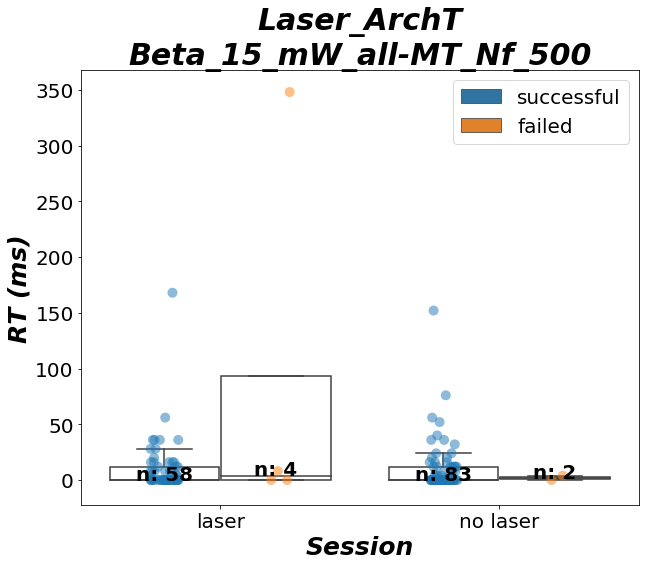

In [63]:
where_plot,what_plot = [0],0
body_part = body_part_list[where_plot]
rat_no = 2; 
where_plot,what_plot = [0],0
body_part = body_part_list[where_plot]
contain_laser = True
# folder = "Square_2-5_mW_partial-MT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Square_5_mW_all-RT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_20_mW_all-RT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
folder = "Beta_15_mW_all-MT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_10_mW_all-RT_Nf_375" ; exp_par = 'Laser_ChR2' ; frame_height = 400
# folder = "Square_5_mW_partial-MT_Nf_375" ; exp_par = 'Laser_ChR2' ; frame_height = 300
prop = folder.split('_')
laser_protocol = prop[3] ; laser_pulse = prop[0]; laser_intensity = prop[1]; fp_trial = int(prop[5])
direct = pre_direct +'/'+exp_par+'/Rat_' +str(rat_no)+ '/'  # directory to the folder for each mouse
R_L_folder = [ f.name for f in os.scandir(direct+folder) if f.is_dir() ][0]
path = direct+folder + '/'+ R_L_folder
r_or_l = R_L_folder[0] # right or left hand

files_list_DLC = list_all_files(path +'/DLC/','.csv')
files_list_LED = list_all_files(path +'/LED/','.csv')
R_or_L_list =np.array( [r_or_l]*len(files_list_DLC))
all_sessions = extract_epochs_over_sessions(R_or_L_list, files_list_DLC, files_list_LED, folder, fp_trial,
                                 laser_protocol, laser_pulse, laser_intensity,contain_laser,body_part,frame_height,n_timebin,
                        velocity_mask,p_cutoff,pad_thresh,max_allowed_v,pad_length_cm,t_s,jitter_threshold)
laser = Laser(all_sessions)
laser_failed = Failed(laser)
laser_successful = Successful(laser)
print("laser success trials = ",laser_successful.n_trials)
print("laser failed trials = ",laser_failed.n_trials)
non_laser = Non_Laser(all_sessions)
print(non_laser.path.shape)
normal_failed = Failed(non_laser)
normal_successful = Successful(non_laser)
print("normal success trials = ",normal_successful.n_trials)
print("normal failed trials = ",normal_failed.n_trials)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))

col_names =  ['RT', 'trial', 'laser']
result = pd.DataFrame(columns = col_names)
df = pd.DataFrame(({'RT':laser_successful.pad_off_t, 'trial':['successful']*len(laser_successful.pad_off_t), 'laser':['laser']*len(laser_successful.pad_off_t)}))
df1 = pd.DataFrame(({'RT':laser_failed.pad_off_t, 'trial':['failed']*len(laser_failed.pad_off_t), 'laser':['laser']*len(laser_failed.pad_off_t)}))
df2 = pd.DataFrame(({'RT':normal_successful.pad_off_t, 'trial':['successful']*len(normal_successful.pad_off_t), 'laser':['no laser']*len(normal_successful.pad_off_t)}))
df3 = pd.DataFrame(({'RT':normal_failed.pad_off_t, 'trial':['failed']*len(normal_failed.pad_off_t), 'laser':['no laser']*len(normal_failed.pad_off_t)}))


result = pd.concat([result, df, df1, df2, df3],ignore_index=True)
result['RT'] = result['RT']*4
# print((normal_failed.path))
# print(normal_failed.starts)

set_ticks(ax)
ax = sns.stripplot(x="laser", y="RT", order=["laser", "no laser"],hue="trial",dodge=True, data=result,jitter=True, 
                   marker='o', size = 10,
                   alpha=0.5)
ax = sns.boxplot(x="laser", y="RT", order=["laser", "no laser"],hue="trial",dodge=True, 
            data=result, boxprops={'facecolor':'None'}, fliersize = 0)

medians = result.groupby(['laser','trial'])['RT'].median()
nobs =  result.groupby(['laser','trial']).apply(lambda x: 'n: {}'.format(len(x)))
for tick, label in enumerate(ax.get_xticklabels()):
    ax_laser = label.get_text()
    for j, ax_trial in enumerate(ax.get_legend_handles_labels()[1][:2]):
        x_offset = (j - 0.5) * 2/5
        med_val = medians[ ax_laser, ax_trial]
        num = nobs[ax_laser, ax_trial]
        
        ax.text(tick + x_offset, med_val + 0.1, num,
                horizontalalignment='center', size=20, color='k', weight='semibold')
# get legend information from the plot object
handles, labels = ax.get_legend_handles_labels()
# specify just one legend
plt.legend(handles[0:2], labels[0:2], fontsize = 20)
plt.ylabel('RT (ms)').set_fontproperties(font_label)
plt.xlabel('Session').set_fontproperties(font_label)

plt.title(exp_par+'\n'+folder).set_fontproperties(font)
plt.savefig(pre_direct+'/Subplots/'+'RT_Rat_'+folder+'_'+exp_par+
                     '.png',bbox_inches='tight',orientation='landscape',dpi=200)
    
# plt.show()


# print(result.head())
# ax = sns.swarmplot(x="day", y="total_bill", hue="smoker",

#                    data=tips, palette="Set2", dodge=True)


## All trials in one plot  No-Laser

<class 'int'>
# jitter in DLC  =  2711
L
# second order jitter : 0
n trials =  43
 succeeded =  43 
 failed =  0 
 pad miss detections =  0
 max trial time =  404.0  ms 
 min trial time =  188.0  ms


/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:349: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


NameError: name 'lever_x' is not defined

<Figure size 432x288 with 0 Axes>

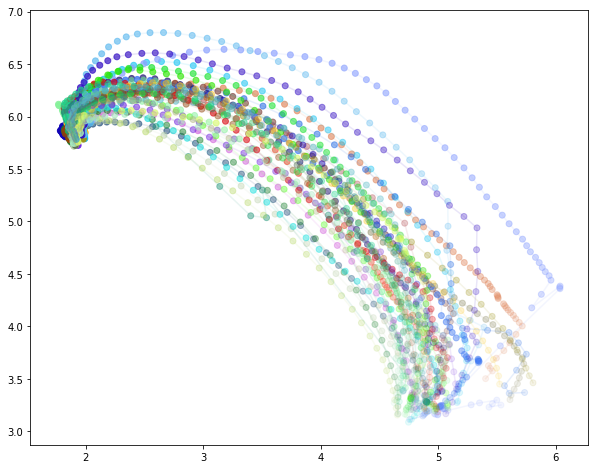

In [17]:
where_plot,what_plot = [0],0
body_part = body_part_list[where_plot]
rat_no = 1; 
contain_laser = True
# folder = "Square_2-5_mW_partial-MT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Square_5_mW_all-RT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_20_mW_all-RT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
folder = "Beta_15_mW_all-MT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_10_mW_all-RT_Nf_375" ; exp_par = 'Laser_ChR2' ; frame_height = 400
# folder = "Square_5_mW_partial-MT_Nf_375" ; exp_par = 'Laser_ChR2' ; frame_height = 300
prop = folder.split('_')
laser_protocol = prop[3] ; laser_pulse = prop[0]; laser_intensity = prop[1]; fp_trial = int(prop[5])
direct = pre_direct +'/'+exp_par+'/Rat_' +str(rat_no)+ '/'  # directory to the folder for each mouse
R_L_folder = [ f.name for f in os.scandir(direct+folder) if f.is_dir() ][0]
path = direct+folder + '/'+ R_L_folder
r_or_l = R_L_folder[0] # right or left hand


files_list_DLC = list_all_files(path +'/DLC/','.csv')
files_list_LED = list_all_files(path +'/LED/','.csv')
i = 0

df = read_DLC_csv(files_list_DLC[i],fp_trial)
df_LED = read_LED_csv(files_list_LED[i],len(df.index))
body_part,what_plot = [0],0

session = extract_opto_epochs(df,df_LED, r_or_l,path,folder,fp_trial,body_part,frame_height,n_timebin,velocity_mask,
                             p_cutoff,pad_thresh,max_allowed_v,pad_length_cm,t_s,jitter_threshold,
                       laser_protocol, laser_pulse, laser_intensity)

laser_tr = Laser(session)
failed = Failed(session)
successful = Successful(session)
print(" succeeded = ", successful.n_trials,"\n failed = ", failed.n_trials, "\n pad miss detections = ", session.n_pad_miss_detection)
print(" max trial time = ", successful.max_time/fps*1000 ," ms", "\n min trial time = ", successful.min_time/fps*1000 ," ms")
plt.figure(1)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8), sharey=True)

for j in range (1,successful.n_trials-1):

    ind, = np.where(successful.epochs_x[j,:] != -1 ) 
    alphas = np.linspace(0.1, 1, len(ind))
    rgba_colors = np.zeros((len(ind),4))
    rgba_colors[:,:-1] = np.random.random((3))
    rgba_colors[:, 3] = alphas
    plt.scatter(successful.epochs_x[j,ind],successful.epochs_y[j,ind], color = rgba_colors)

    plt.plot(successful.epochs_x[j,ind],successful.epochs_y[j,ind],  c = rgba_colors[0,:-1], alpha = 0.1)

# for j in range (1,failed.n_trials-1):

#     ind, = np.where(failed.epochs_x[j,:] != -1 ) 
#     alphas = np.linspace(0.1, 1, len(ind))
#     rgba_colors = np.zeros((len(ind),4))
#     rgba_colors[:,:-1] = np.random.random((3))
#     rgba_colors[:, 3] = alphas
#     plt.scatter(failed.epochs_x[j,ind],failed.epochs_y[j,ind], color = rgba_colors )
#     plt.plot(failed.epochs_x[j,ind],failed.epochs_y[j,ind], c = rgba_colors[0,:-1], alpha = 0.1 )

plt.title("Rat #"+str(rat_no)+" "+folder+"\n session : "+str(i+1)).set_fontproperties(font)
plt.ylabel("Y (cm)").set_fontproperties(font_label)
plt.xlabel("X (cm)").set_fontproperties(font_label)
plt.legend(fontsize = 10)
# plt.savefig(pre_direct+'/Subplots/'+'Rat_'+str(rat_no)+'_'+folder+'_session = '+str(i+1)+
#              '.png',bbox_inches='tight',orientation='landscape',dpi=200)



## Mean trajectory 

t_s 10
# jitter in DLC  =  413
t_s 10
# jitter in DLC  =  240
 succeeded =  41 
 failed =  0 
 pad miss detections =  0
 max trial time =  776.0  ms 
 min trial time =  96.0  ms


<ErrorbarContainer object of 3 artists>

<Figure size 432x288 with 0 Axes>

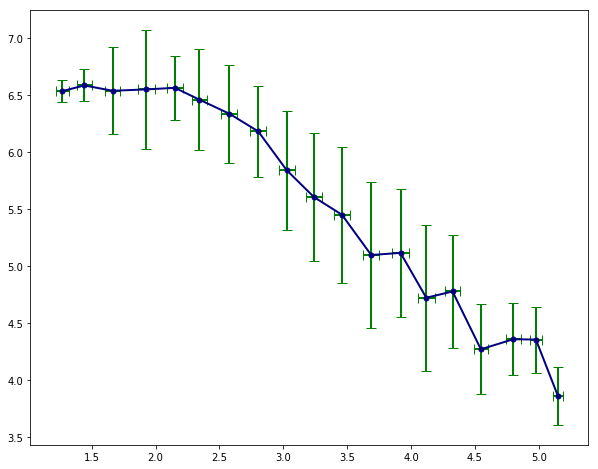

In [39]:
rat_no = 12; spont = "n"; folder = "Day_-1"
folder_list = ['Day_-1','Day_0','Day_7','Day_8','Day_9','Day_10']
direct = pre_direct +'/Rat_' +str(rat_no)+ '/'  # directory to the folder for each mouse

i = 0
files_list_DLC = list_all_files(direct+folder+'/DLC','.csv')
files_list_LED = list_all_files(direct+folder+'/LED','.csv')
path = direct+folder+'/DLC/'+files_list_DLC[i]
df = read_DLC_csv(direct+folder+'/DLC/'+files_list_DLC[i],fp_trial)
df_LED = read_LED_csv(direct+folder+'/LED/'+files_list_LED[i],len(df.index))
where_plot,what_plot = [0],0
body_part = body_part_list[where_plot]
session = extract_opto_epochs(df,df_LED,path,file_name,folder,fp_trial,body_part,frame_height)

failed = Failed(session)
successful = Successful(session)
print(" succeeded = ", successful.n_trials,"\n failed = ", failed.n_trials, "\n pad miss detections = ", session.n_pad_miss_detection)
print(" max trial time = ", successful.max_time/fps*1000 ," ms", "\n min trial time = ", successful.min_time/fps*1000 ," ms")

epochs_x = successful.epochs_x
epochs_y = successful.epochs_y
n_grid = 20

trials = find_mean_trajectory(n_grid, epochs_x, epochs_y)
plt.figure(2)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8), sharey=True)
        
plt.errorbar(trials.x,trials.y,  trials.err_y, trials.err_x,  marker = 'o',
             markersize=5, linewidth=2, capsize=5, capthick=1, color = 'navy', ecolor='g')
# plt.errorbar(trials.x,trials.y, trials.conf_inter_y.T, trials.conf_inter_x.T , marker = 'o',
#              markersize=5, linewidth=2, capsize=5, capthick=1, color = 'navy', ecolor='g')
plt.plot([lever_x],[lever_y], marker='o',markersize=20,c = 'r',label = "Lever")
plt.title("Rat #"+str(rat_no)+" "+folder+"\n session : "+str(i+1)).set_fontproperties(font)
plt.ylabel("Y (cm)").set_fontproperties(font_label)
plt.xlabel("X (cm)").set_fontproperties(font_label)
plt.legend(fontsize = 10)
plt.savefig(pre_direct+'/Subplots/'+'Rat_'+str(rat_no)+'_'+folder+'_session = '+str(i+1)+
             '.png',bbox_inches='tight',orientation='landscape',dpi=200)



# Compare $Tortuosity$ laser vs. non laser

## successfull + Failed

to discard  0
# second order jitter : 0
n trials =  32
to discard  0
# second order jitter : 0
n trials =  32
to discard  0
# second order jitter : 0
n trials =  32
to discard  0
# second order jitter : 0
n trials =  32
to discard  0
# second order jitter : 0
n trials =  5
to discard  0
# second order jitter : 0
n trials =  32
to discard  0
# second order jitter : 1
n trials =  32
to discard  0
# second order jitter : 0
n trials =  32
to discard  0
# second order jitter : 0
n trials =  32
to discard  0
# second order jitter : 0
n trials =  19
to discard  0
# second order jitter : 0
n trials =  32
to discard  0
# second order jitter : 0
n trials =  32
to discard  0
# second order jitter : 0
n trials =  32
to discard  0
# second order jitter : 0
n trials =  32
to discard  0
# second order jitter : 0
n trials =  31
to discard  0
# second order jitter : 0
n trials =  2
x (8,)
y (8,)
dis (8,)
tor (8,)
x (155,)
y (155,)
dis (155,)
tor (155,)
laser success trials =  155
laser failed trials = 

/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:435: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


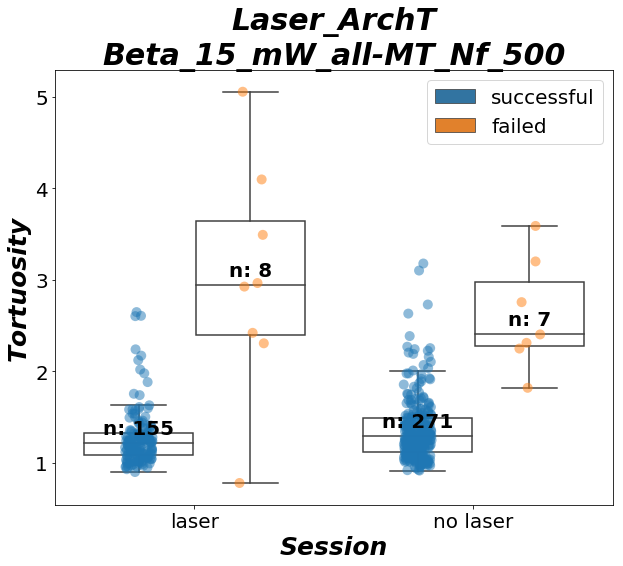

In [210]:
where_plot,what_plot = [0],0
body_part = body_part_list[where_plot]
contain_laser = True
# folder = "Square_2-5_mW_partial-MT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Square_5_mW_all-RT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_20_mW_all-RT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
folder = "Beta_15_mW_all-MT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_10_mW_all-RT_Nf_375" ; exp_par = 'Laser_ChR2' ; frame_height = 400
# folder = "Square_5_mW_partial-MT_Nf_375" ; exp_par = 'Laser_ChR2' ; frame_height = 300
prop = folder.split('_')
laser_protocol = prop[3] ; laser_pulse = prop[0]; laser_intensity = prop[1]; fp_trial = int(prop[5])
# exp_par = 'Laser_ChR2'
# exp_par = 'Laser_ArchT'
pre_direct_chosen = pre_direct + '/' +exp_par
R_or_L_list, files_list_DLC, files_list_LED = find_all_files_same_protocol(pre_direct_chosen, folder)
all_sessions = extract_epochs_over_sessions(R_or_L_list, files_list_DLC, files_list_LED, folder, fp_trial,
                                 laser_protocol, laser_pulse, laser_intensity,contain_laser,body_part,frame_height,n_timebin,
                        velocity_mask,p_cutoff,pad_thresh,max_allowed_v,pad_length_cm,t_s,jitter_threshold)

laser = Laser(all_sessions)
laser_failed = Failed(laser)
laser_successful = Successful(laser)
print("laser success trials = ",laser_successful.n_trials)
print("laser failed trials = ",laser_failed.n_trials)
non_laser = Non_Laser(all_sessions)
# print(non_laser.path.shape)
normal_failed = Failed(non_laser)
normal_successful = Successful(non_laser)
print("normal success trials = ",normal_successful.n_trials)
print("normal failed trials = ",normal_failed.n_trials)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
col_names =  ['tortuosity', 'trial', 'laser']
result = pd.DataFrame(columns = col_names)
print(laser_successful.tortuosity.shape)
df = pd.DataFrame(({'tortuosity':laser_successful.tortuosity, 'trial':['successful']*laser_successful.n_trials, 'laser':['laser']*laser_successful.n_trials}))
df1 = pd.DataFrame(({'tortuosity':laser_failed.tortuosity, 'trial':['failed']*len(laser_failed.tortuosity), 'laser':['laser']*len(laser_failed.tortuosity)}))
df2 = pd.DataFrame(({'tortuosity':normal_successful.tortuosity, 'trial':['successful']*len(normal_successful.tortuosity), 'laser':['no laser']*len(normal_successful.tortuosity)}))
df3 = pd.DataFrame(({'tortuosity':normal_failed.tortuosity, 'trial':['failed']*len(normal_failed.tortuosity), 'laser':['no laser']*len(normal_failed.tortuosity)}))


result = pd.concat([result, df, df1, df2, df3],ignore_index=True)
set_ticks(ax)
ax = sns.stripplot(x="laser", y="tortuosity", order=["laser", "no laser"],hue="trial",dodge=True, data=result,
                   jitter=True,marker='o', size = 10, alpha=0.5)
ax = sns.boxplot(x="laser", y="tortuosity", order=["laser", "no laser"],hue="trial",dodge=True, 
            data=result, boxprops={'facecolor':'None'}, fliersize = 0)

medians = result.groupby(['laser','trial'])['tortuosity'].median()
nobs =  result.groupby(['laser','trial']).apply(lambda x: 'n: {}'.format(len(x)))
for tick, label in enumerate(ax.get_xticklabels()):
    ax_laser = label.get_text()
    for j, ax_trial in enumerate(ax.get_legend_handles_labels()[1][:2]):
        x_offset = (j - 0.5) * 2/5
        med_val = medians[ ax_laser, ax_trial]
        num = nobs[ax_laser, ax_trial]
        
        ax.text(tick + x_offset, med_val + 0.1, num,
                horizontalalignment='center', size=20, color='k', weight='semibold')
# get legend information from the plot object
handles, labels = ax.get_legend_handles_labels()
# specify just one legend
plt.legend(handles[0:2], labels[0:2], fontsize = 20)
plt.ylabel('Tortuosity').set_fontproperties(font_label)
plt.xlabel('Session').set_fontproperties(font_label)

plt.title(exp_par+'\n'+folder).set_fontproperties(font)
plt.savefig(pre_direct+'/Subplots/'+'Tortuosity_Rat_'+folder+'_'+exp_par+
                     '.png',bbox_inches='tight',orientation='landscape',dpi=200)
    
# plt.show()


# print(result.head())
# ax = sns.swarmplot(x="day", y="total_bill", hue="smoker",

#                    data=tips, palette="Set2", dodge=True)

## Only successfull

number of sessionsf for Beta_15_mW_all-MT_Nf_500protocol  16
 number of session = 1 out of 16
to discard  0
# second order jitter : 0
n trials =  32
 number of session = 2 out of 16
to discard  0
# second order jitter : 0
n trials =  32
 number of session = 3 out of 16
to discard  0


/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:591: RuntimeWarning: invalid value encountered in multiply
/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:595: RuntimeWarning: invalid value encountered in multiply
/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:614: RuntimeWarning: invalid value encountered in multiply


# second order jitter : 0
n trials =  32
 number of session = 4 out of 16
to discard  0
# second order jitter : 0
n trials =  32
 number of session = 5 out of 16
to discard  0
# second order jitter : 0
n trials =  5
 number of session = 6 out of 16
to discard  0
# second order jitter : 0
n trials =  32
 number of session = 7 out of 16
to discard  0
# second order jitter : 1
n trials =  32
 number of session = 8 out of 16
to discard  0
# second order jitter : 0
n trials =  32
 number of session = 9 out of 16
to discard  0
# second order jitter : 0
n trials =  32
 number of session = 10 out of 16
to discard  0
# second order jitter : 0
n trials =  19
 number of session = 11 out of 16
to discard  0
# second order jitter : 2
n trials =  32
 number of session = 12 out of 16
to discard  0
# second order jitter : 0
n trials =  32
 number of session = 13 out of 16
to discard  0
# second order jitter : 0
n trials =  32
 number of session = 14 out of 16
to discard  0
# second order jitter : 0
n 

/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:420: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


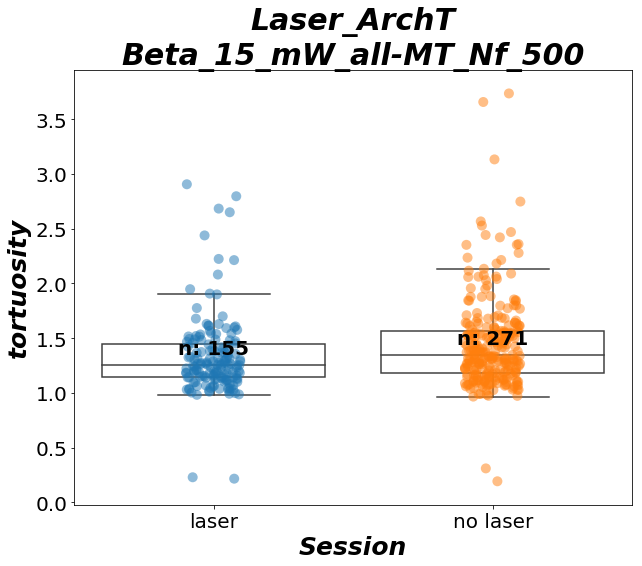

In [65]:
where_plot,what_plot = [0],0
body_part = body_part_list[where_plot]
contain_laser = True
# folder = "Square_2-5_mW_partial-MT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Square_5_mW_all-RT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_20_mW_all-RT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
folder = "Beta_15_mW_all-MT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_10_mW_all-RT_Nf_375" ; exp_par = 'Laser_ChR2' ; frame_height = 400
# folder = "Square_5_mW_partial-MT_Nf_375" ; exp_par = 'Laser_ChR2' ; frame_height = 300
prop = folder.split('_')
laser_protocol = prop[3] ; laser_pulse = prop[0]; laser_intensity = prop[1]; fp_trial = int(prop[5])
# exp_par = 'Laser_ChR2'
# exp_par = 'Laser_ArchT'
pre_direct_chosen = pre_direct + '/' +exp_par
R_or_L_list, files_list_DLC, files_list_LED = find_all_files_same_protocol(pre_direct_chosen, folder)
all_sessions = extract_epochs_over_sessions(R_or_L_list, files_list_DLC, files_list_LED, folder, fp_trial,
                                 laser_protocol, laser_pulse, laser_intensity,contain_laser,body_part,frame_height,n_timebin,
                        velocity_mask,p_cutoff,pad_thresh,max_allowed_v,pad_length_cm,t_s,jitter_threshold)

laser = Laser(all_sessions)
laser_failed = Failed(laser)
laser_successful = Successful(laser)
print("laser success trials = ",laser_successful.n_trials)
print("laser failed trials = ",laser_failed.n_trials)
non_laser = Non_Laser(all_sessions)
print(non_laser.path.shape)
normal_failed = Failed(non_laser)
normal_successful = Successful(non_laser)
print("normal success trials = ",normal_successful.n_trials)
print("normal failed trials = ",normal_failed.n_trials)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))

col_names =  ['tortuosity', 'trial', 'laser']
result = pd.DataFrame(columns = col_names)
df = pd.DataFrame(({'tortuosity':laser_successful.tortuosity, 'trial':['successful']*len(laser_successful.tortuosity), 'laser':['laser']*len(laser_successful.tortuosity)}))
# df1 = pd.DataFrame(({'tortuosity':laser_failed.tortuosity, 'trial':['failed']*len(laser_failed.tortuosity), 'laser':['laser']*len(laser_failed.tortuosity)}))
df2 = pd.DataFrame(({'tortuosity':normal_successful.tortuosity, 'trial':['successful']*len(normal_successful.tortuosity), 'laser':['no laser']*len(normal_successful.tortuosity)}))
# df3 = pd.DataFrame(({'tortuosity':normal_failed.tortuosity, 'trial':['failed']*len(normal_failed.tortuosity), 'laser':['no laser']*len(normal_failed.tortuosity)}))


result = pd.concat([result, df, df2],ignore_index=True)
# print((normal_failed.path))
# print(normal_failed.starts)

set_ticks(ax)
ax = sns.stripplot(x="laser", y="tortuosity", order=["laser", "no laser"], data=result,jitter=True, 
                   marker='o', size = 10,
                   alpha=0.5)
ax = sns.boxplot(x="laser", y="tortuosity", order=["laser", "no laser"], 
            data=result, boxprops={'facecolor':'None'}, fliersize = 0)

medians = result.groupby(['laser'])['tortuosity'].median()
nobs =  result.groupby(['laser']).apply(lambda x: 'n: {}'.format(len(x)))
for tick, label in enumerate(ax.get_xticklabels()):
    ax_laser = label.get_text()
    x_offset = tick
    med_val = medians[ ax_laser]
    num = nobs[ax_laser]
        
    ax.text(tick, med_val + 0.1, num,
                horizontalalignment='center', size=20, color='k', weight='semibold')
# get legend information from the plot object
# handles, labels = ax.get_legend_handles_labels()
# specify just one legend
# plt.legend(handles[0:2], labels[0:2], fontsize = 20)
plt.ylabel('tortuosity').set_fontproperties(font_label)
plt.xlabel('Session').set_fontproperties(font_label)

plt.title(exp_par+'\n'+folder).set_fontproperties(font)
plt.savefig(pre_direct+'/Subplots/'+'tortuosity_only_success_Rat_'+folder+'_'+exp_par+
                     '.png',bbox_inches='tight',orientation='landscape',dpi=200)
    
# plt.show()


# print(result.head())
# ax = sns.swarmplot(x="day", y="total_bill", hue="smoker",

#                    data=tips, palette="Set2", dodge=True)

# Compare $ V_{max}$ laser vs. non laser

/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:591: RuntimeWarning: invalid value encountered in multiply
/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:592: RuntimeWarning: invalid value encountered in multiply
/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:593: RuntimeWarning: invalid value encountered in multiply
/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:594: RuntimeWarning: invalid value encountered in multiply
/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:595: RuntimeWarning: invalid value encountered in multiply
/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:614: RuntimeWarning: invalid value encountered in multiply
/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:420: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In th

/home/shiva/Desktop/Rat_Lever_Analysis/Laser_ChR2/Rat_102/Square_5_mW_partial-MT_Nf_375/Right/DLC/Rat102_partialMT-5mW_21072017_2camera_chrono_20170721_160420_C001H001S0001DLC_resnet50_Rat_lever_Velentin_Rat_102May13shuffle1_250000.csv
to discard  10
# second order jitter : 6
n trials =  31
[ 58.86830319 122.72449831  51.49592828 113.9686749  124.2819504
  60.35060952 118.49633931 120.1957088   47.93118369 121.77871339
 130.21602972  23.95991304 129.76920355 122.87054744  57.7534599
 115.57317305 110.23460221 124.05995024 121.59926362  44.23801011
 118.25246025 102.77396126  49.78473305 117.83016756 123.91578072
  45.63592894  52.41832718 116.64576137 110.22615036  49.78862786
 120.56621145]
laser success trials =  7
laser failed trials =  1
(23,)
normal success trials =  20
normal failed trials =  3
[ 51.49592828  60.35060952  47.93118369  23.95991304  57.7534599
  49.78862786 120.56621145]


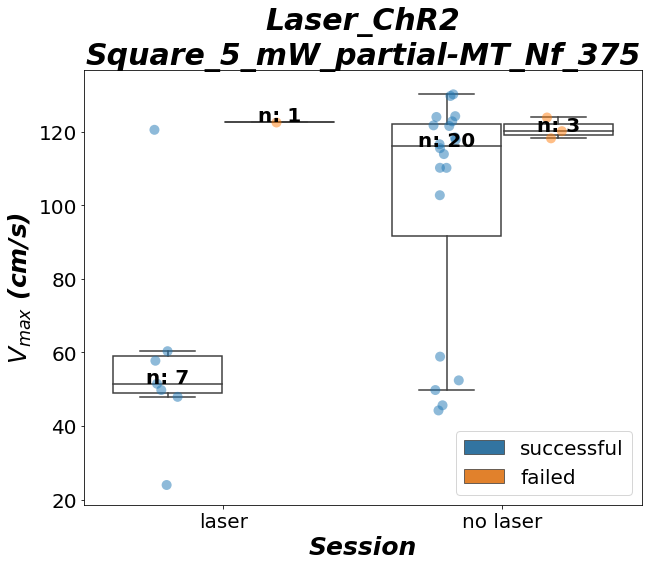

In [104]:
where_plot,what_plot = [0],0
body_part = body_part_list[where_plot]
contain_laser = True
p_cutoff = 0.4
# folder = "Square_2-5_mW_partial-MT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Square_5_mW_all-RT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_20_mW_all-RT_Nf_375" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_15_mW_all-MT_Nf_500" ; exp_par = 'Laser_ArchT' ; frame_height = 400
# folder = "Beta_10_mW_all-RT_Nf_375" ; exp_par = 'Laser_ChR2' ; frame_height = 400
folder = "Square_5_mW_partial-MT_Nf_375" ; exp_par = 'Laser_ChR2' ; frame_height = 300
prop = folder.split('_')
laser_protocol = prop[3] ; laser_pulse = prop[0]; laser_intensity = prop[1]; fp_trial = int(prop[5])

pre_direct_chosen = pre_direct + '/' +exp_par
R_or_L_list, files_list_DLC, files_list_LED = find_all_files_same_protocol(pre_direct_chosen, folder)
all_sessions = extract_epochs_over_sessions(R_or_L_list, files_list_DLC, files_list_LED, folder, fp_trial,
                                 laser_protocol, laser_pulse, laser_intensity,contain_laser,body_part,frame_height,n_timebin,
                        velocity_mask,p_cutoff,pad_thresh,max_allowed_v,pad_length_cm,t_s,jitter_threshold)

laser = Laser(all_sessions)
laser_failed = Failed(laser)
laser_successful = Successful(laser)
print("laser success trials = ",laser_successful.n_trials)
print("laser failed trials = ",laser_failed.n_trials)
non_laser = Non_Laser(all_sessions)
print(non_laser.path.shape)
normal_failed = Failed(non_laser)
normal_successful = Successful(non_laser)
print("normal success trials = ",normal_successful.n_trials)
print("normal failed trials = ",normal_failed.n_trials)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
col_names =  ['v_max', 'trial', 'laser']
result = pd.DataFrame(columns = col_names)
print(np.max(laser_successful.velocity_r,axis=1))
df = pd.DataFrame(({'v_max':np.max(laser_successful.velocity_r,axis=1), 'trial':['successful']*laser_successful.n_trials, 'laser':['laser']*laser_successful.n_trials}))
df1 = pd.DataFrame(({'v_max':np.max(laser_failed.velocity_r,axis=1), 'trial':['failed']*laser_failed.n_trials, 'laser':['laser']*laser_failed.n_trials}))
df2 = pd.DataFrame(({'v_max':np.max(normal_successful.velocity_r,axis=1), 'trial':['successful']*normal_successful.n_trials, 'laser':['no laser']*normal_successful.n_trials}))
df3 = pd.DataFrame(({'v_max':np.max(normal_failed.velocity_r,axis=1), 'trial':['failed']*normal_failed.n_trials, 'laser':['no laser']*normal_failed.n_trials}))


result = pd.concat([result, df, df1, df2, df3],ignore_index=True)
set_ticks(ax)
ax = sns.stripplot(x="laser", y="v_max", order=["laser", "no laser"],hue="trial",dodge=True, data=result,
                   jitter=True,marker='o', size = 10, alpha=0.5)
ax = sns.boxplot(x="laser", y="v_max", order=["laser", "no laser"],hue="trial",dodge=True, 
            data=result, boxprops={'facecolor':'None'}, fliersize = 0)

medians = result.groupby(['laser','trial'])['v_max'].median()
nobs =  result.groupby(['laser','trial']).apply(lambda x: 'n: {}'.format(len(x)))
for tick, label in enumerate(ax.get_xticklabels()):
    ax_laser = label.get_text()
    for j, ax_trial in enumerate(ax.get_legend_handles_labels()[1][:2]):
        x_offset = (j - 0.5) * 2/5
        med_val = medians[ ax_laser, ax_trial]
        num = nobs[ax_laser, ax_trial]
        
        ax.text(tick + x_offset, med_val + 0.1, num,
                horizontalalignment='center', size=20, color='k', weight='semibold')
# get legend information from the plot object
handles, labels = ax.get_legend_handles_labels()
# specify just one legend
plt.legend(handles[0:2], labels[0:2], fontsize = 20)
plt.ylabel(r'$V_{max}$ (cm/s)').set_fontproperties(font_label)
plt.xlabel('Session').set_fontproperties(font_label)

plt.title(exp_par+'\n'+folder).set_fontproperties(font)
plt.savefig(pre_direct+'/Subplots/'+'v_max_Rat_'+folder+'_'+exp_par+
                     '.png',bbox_inches='tight',orientation='landscape',dpi=200)
    
# plt.show()


# print(result.head())
# ax = sns.swarmplot(x="day", y="total_bill", hue="smoker",

#                    data=tips, palette="Set2", dodge=True)

# Loop to plot each session alone for all days

0.2
0.5235987755982988
/home/shiva/Desktop/Rat_Lever_Analysis/6OHDA/Rat_12/Day_0/DLC/Rat 12 head 1 6OHDA x2 04-06-19_20190604_180719_C001H001S0001DLC_resnet50_Rat_lever_Ana_Rat_12May6shuffle1_250000.csv
to discard  1
before [2.62567342 2.5087818 ]
after [2.75063486 2.72251548]
# second order jitter : 1
n trials =  42
[194 115  90 230 220 160  85 106  99 133 184 105 314 125  82 169  83  76
 108 130 100 153 154 113  67  58  54  96  67  99  49  61  61  55  78  64
  50  65  73 107  64]
[ 94  51  23 113  79  46  19   2  23  45 105  42   0  35   0  98   0  23
  41  10  29  41  47  42   0   0   0   1   0   0   0   0   0   0   0   0
   0   0   0   2   0]


/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:417: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


/home/shiva/Desktop/Rat_Lever_Analysis/6OHDA/Rat_12/Day_0/DLC/Rat 12 head 1 6OHDA x2 04-06-19_20190604_182008_C001H001S0001DLC_resnet50_Rat_lever_Ana_Rat_12May6shuffle1_250000.csv
to discard  1
before [1.9323854  1.93818054 1.91674369 1.93157087 1.91553853 1.91578456]
after [5.63831903 5.63831903 5.63831903 5.63831903 5.63831903 5.63831903]
before [2.7091233]
after [3.93897792]
before [2.79551886]
after [3.75852647]
# second order jitter : 3
n trials =  42
[200 148 311 124 154 303  78 149 107 168 106 124  80 222  60  73 144  50
  61  55  83 134  62  96  78  68 108 244  66  77 142 153  86  91  66 109
 117 216 184]
[ 92  38 218   0  46  71   8  60  42  88   1  10   0  80   0   0   2   0
   0   0   1   0   0   0   0   0  52   2   0   1   0   2  27   0   0   1
   4  27  89]
/home/shiva/Desktop/Rat_Lever_Analysis/6OHDA/Rat_12/Day_0/DLC/Rat 12 head 1 6OHDA x2 04-06-19_20190604_182821_C001H001S0001DLC_resnet50_Rat_lever_Ana_Rat_12May6shuffle1_250000.csv
to discard  1
# second order jitter : 0

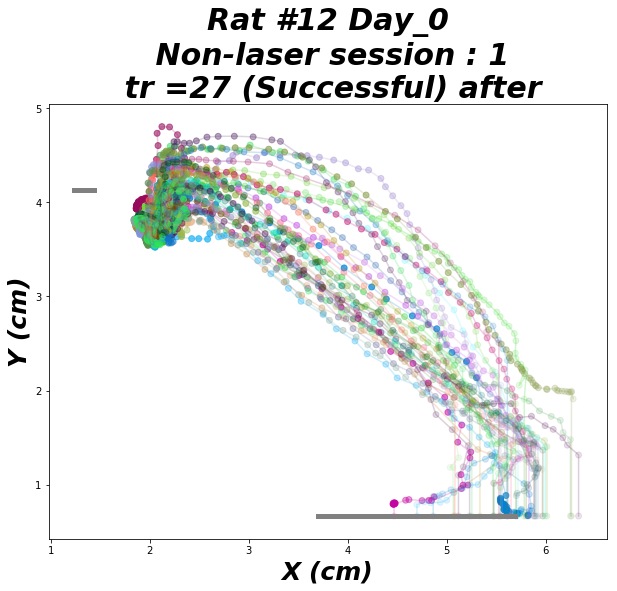

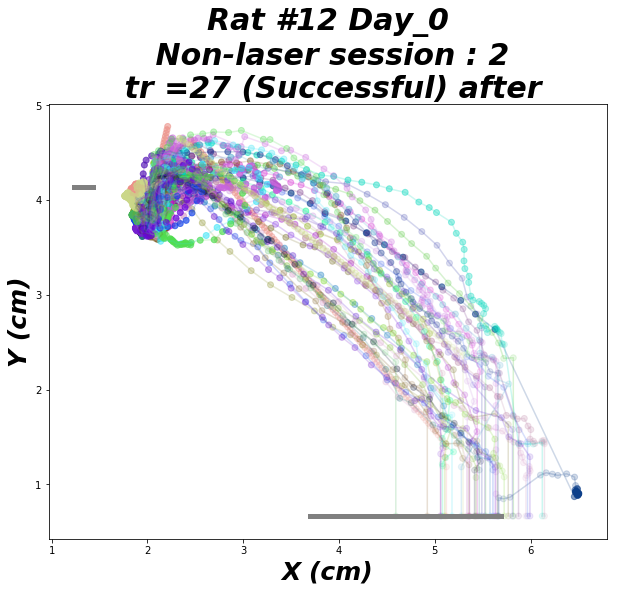

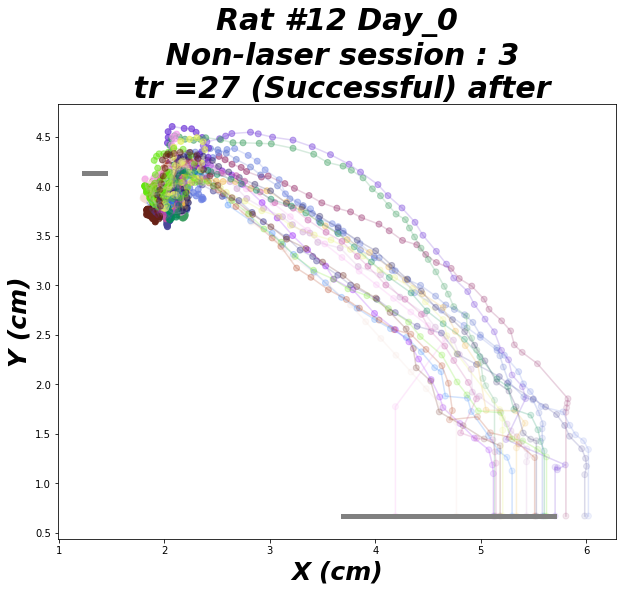

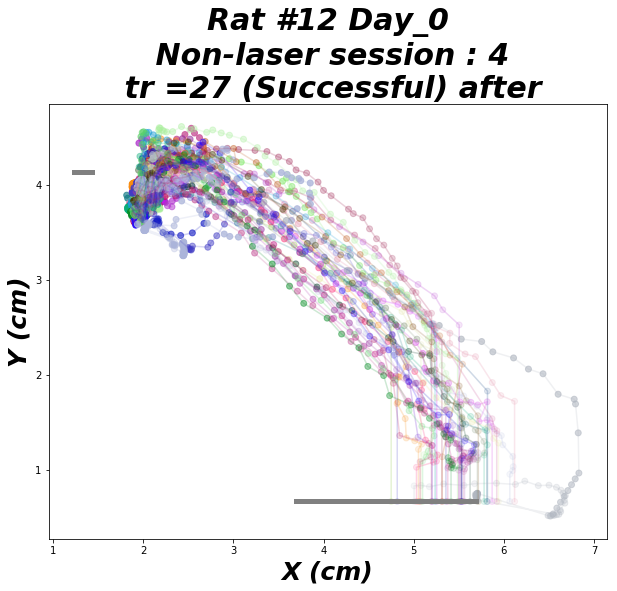

In [9]:

fp_trial = 375 # number of frames per trial
np.random.seed(10)
rat_no = 12
r_or_l = 'L'
# folder_list = ['Day_-1','Day_0','Day_7','Day_8','Day_9','Day_10']
folder_list = ['Day_0']
direct = pre_direct +'/6OHDA'+'/Rat_' +str(rat_no)+ '/'  # directory to the folder for each mouse
extension = ".csv"
p_cutoff = 0.8
max_speed = 50 # cm/s # the max speed of the rat derived from average trajectory 
max_allowed_v = max_speed/fps
print(max_allowed_v)
jitter_threshold =max_allowed_v
jitter_proximity_thresh_rho = 0.7 # the acceptable jitter in r coordinate to be considered as the samr jump
thresh_adjust = 1/5 # if there are 5 jemped points the threshold is <jitter_proximity_thresh_rho>
jitter_proximity_thresh_phi = 30/180*np.pi
print(jitter_proximity_thresh_phi)
m = 27
for folder in folder_list:
    files_list_DLC = list_all_files(direct+folder+'/DLC/','.csv')
    files_list_LED = list_all_files(direct+folder+'/LED/','.csv')
    for i in range(len(files_list_DLC)):
#     for i in range(1,2):
        print(files_list_DLC[i])
        df = read_DLC_csv(files_list_DLC[i],fp_trial)
        df_LED = read_LED_csv(files_list_LED[i],len(df.index))
        where_plot,what_plot = [0],0
        body_part = body_part_list[where_plot]
        path = direct+folder
        session = extract_epochs(df,df_LED, r_or_l,path,folder,fp_trial,body_part,frame_height,n_timebin,
                                 velocity_mask,p_cutoff,pad_thresh,max_allowed_v,pad_length_cm,t_s,jitter_threshold)

        failed = Failed(session)
        successful = Successful(session)    

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8), sharey=True)
        ax = plt.subplot(111)
        
        for j in range (successful.n_trials-1):
#         for j in range (m,m+1):

            successful.epochs_x[j,successful.likelihood[j] < p_cutoff] = -1
            overall_ind, = np.where(successful.epochs_x[j,:] != -1 )
            alphas = np.linspace(0.1, 1, len(overall_ind))
            rgba_colors = np.zeros((len(overall_ind),4))
            rgba_colors[:,:-1] = np.random.random((3))
            rgba_colors[:, 3] = alphas
            plt.scatter(successful.epochs_x[j,overall_ind],successful.epochs_y[j,overall_ind], color = rgba_colors )
            plt.plot(successful.epochs_x[j,overall_ind],successful.epochs_y[j,overall_ind],alpha = 0.2, color = rgba_colors[0,:-1] )
        plt.plot([session.lever_x[0] - 0.1, session.lever_x[0] + 0.1],[session.lever_y[0],session.lever_y[0]],lw = 5, c = 'grey')
        plt.plot([session.pad_left_x[0],session.pad_right_x[0]],[session.pad_y[0],session.pad_y[0]],lw = 5, c = 'grey')

        plt.title("Rat #"+str(rat_no)+" "+folder+"\n Non-laser session : "+str(i+1)+"\n tr ="+str(m)+" (Successful) after").set_fontproperties(font)
        plt.ylabel("Y (cm)").set_fontproperties(font_label)
        plt.xlabel("X (cm)").set_fontproperties(font_label)
#         plt.legend(fontsize = 10)
#         plt.xlim(1,6)
#         plt.ylim(3.5,7)
#         ax[1] = plt.subplot(122)
#         set_ticks(ax[1])
#         for i in range (0,failed.n_trials):
#             failed.epochs_x[i,failed.likelihood[i] < p_cutoff] = -1 # remove frames with small likelihood
#             overall_ind, = np.where(failed.epochs_x[i,:] != -1 )
#             alphas = np.linspace(0.1, 1, len(overall_ind))
#             rgba_colors = np.zeros((len(overall_ind),4))
#             rgba_colors[:,:-1] = np.random.random((3))
#             rgba_colors[:, 3] = alphas
#             plt.scatter(failed.epochs_x[i,overall_ind],failed.epochs_y[i,overall_ind], color = rgba_colors )
#             plt.plot(failed.epochs_x[i,overall_ind],failed.epochs_y[i,overall_ind],alpha = 0.2, color = rgba_colors[0,:-1] )

#         plt.plot([session.lever_x[0] - 0.1, session.lever_x[0] + 0.1],[session.lever_y[0],session.lever_y[0]],lw = 5, c = 'grey')
#         plt.plot([session.pad_left_x[0],session.pad_right_x[0]],[session.pad_y[0],session.pad_y[0]],lw = 5, c = 'grey')

#         plt.title("Rat #"+str(rat_no)+" "+folder+"\n Non-Laser session : "+str(i+1)+'\n (Failed)').set_fontproperties(font)
#         plt.ylabel("Y (cm)").set_fontproperties(font_label)
#         plt.xlabel("X (cm)").set_fontproperties(font_label)
# #         plt.legend(fontsize = 10)
# #         plt.xlim(1,7)
# #         plt.ylim(3.5,7.5)
#         set_ticks(ax[1])
        plt.savefig(pre_direct+'/Subplots/'+'Rat_'+str(rat_no)+'_'+folder+'_successful_session = '+str(i+1)+
                     '.png',bbox_inches='tight',orientation='landscape',dpi=200)

# jitter removal using likelihood

0.2
0.5235987755982988
/home/shiva/Desktop/Rat_Lever_Analysis/6OHDA/Rat_12/Day_0/DLC/Rat 12 head 1 6OHDA x2 04-06-19_20190604_182008_C001H001S0001DLC_resnet50_Rat_lever_Ana_Rat_12May6shuffle1_250000.csv
to discard  1
n trials =  43


/home/shiva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:435: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


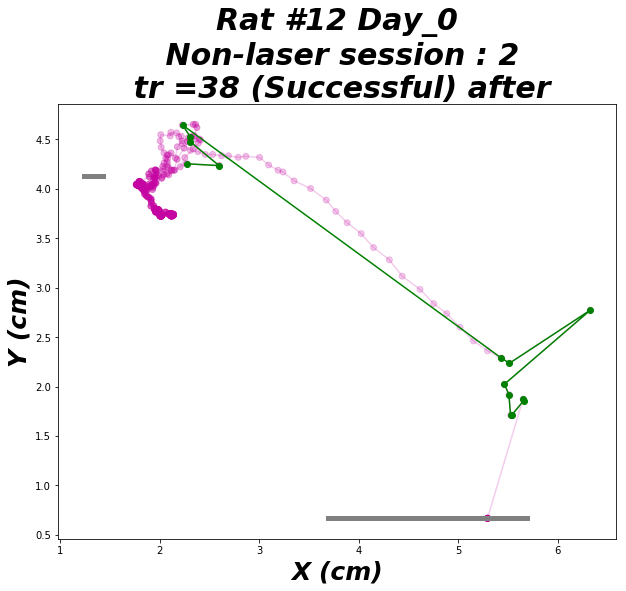

In [92]:

def correct_lasting_labeling_jitter(epochs_x, epochs_y,likelihood,to_keep, jitter_threshold,t,fp_trial):
    ''' correct the detections exceeding the max speed of the mouse (chekcing for r) with
        extrapolation with a straight line. Thus enforcing corrections to be dependent on early detections.
        for early jitters t extra points are provided before time zero if the paw is definitly at pad proximity by 
        <set_points_around_the_pad> function.
        '''
    count = 0
    for i in range(epochs_x.shape[0]): # go over trials
#     for i in range(m,m+1): # go over single trial
        x_copy = np.copy(epochs_x[i,likelihood[i] > p_cutoff]) 
        y_copy = np.copy(epochs_y[i,likelihood[i] > p_cutoff]) 
        if len(x_copy) < fp_trial/4: 
            to_keep[i] = False
            continue
        shifted_x = shift((x_copy), 1, cval=0) #  shifts in a periodic manner, hence the next line
        shifted_x[0] = shifted_x[1] # set the shifted value 
        deltas_before_x = np.copy(shifted_x - x_copy)

        shifted_y = shift((y_copy), 1, cval=0) # np.roll shifts in a periodic manner, hence the next line
        shifted_y[0] = shifted_y[1] # set the shifted value 
        deltas_before_y =  np.copy(shifted_y - y_copy)
        
        x,y,deltas_x,deltas_y = set_points_around_the_pad(x_copy,y_copy,
                                                        deltas_before_x, deltas_before_y,t)
#         print(epochs_x[i])
#         print(x)
        rho,phi = cart2pol(deltas_x,deltas_y) # we have the displacement vector in polar coordinates
        ind, = np.where(rho > jitter_threshold) # find the jumps
#         print("ind",ind)
        ind = ind[ind > t] # leave room for having reference before the jump
#         if len(ind) > 0: 
#             print("x",x[ind[0]-1:ind[-1]+1])
#             print("y",y[ind[0]-1:ind[-1]+1])
#             print("rho",rho[ind[0]-1:ind[-1]+1])
#         print("delta",deltas_before_x[m,ind[0]-1:ind[-1]+1])
        if len(ind) >= 2: # since we're checking for back and forths we need couples            
            for j in range (0,len(ind)-1):
#                 print("j",ind[j] , ind[j+1])
#                 print("delta rho",rho[ind[j]] - rho[ind[j+1]])
#                 print("delta phi",(abs(abs(phi[ind[j]] - phi[ind[j+1]])-np.pi))*180/np.pi)
                if abs(rho[ind[j]] - rho[ind[j+1]]) < jitter_proximity_thresh_rho and abs(abs(phi[ind[j]] - phi[ind[j+1]])-np.pi) < jitter_proximity_thresh_phi: 
                ## check to see if there is an approximatly same size backward jump to the correct path from this jump
                    print("in")
                    # referece provided by average of t points before the jump
                    ref_av_x = np.sum(x[ind[j]-t:ind[j]-1])/ len((x[ind[j]-t:ind[j]-1])) 
                    ref_av_y = np.sum(y[ind[j]-t:ind[j]-1])/ len((y[ind[j]-t:ind[j]-1]))
                    n_points_to_correct = len((x[ind[j]:ind[j+1]])) # number of points included in the jump
                    # average of jumped points provided by average of points included in the jump
                    av_x = np.sum(x[ind[j]:ind[j+1]])/ n_points_to_correct
                    av_y = np.sum(y[ind[j]:ind[j+1]])/n_points_to_correct
                    
                    r_ref,theta_ref = cart2pol(ref_av_x,ref_av_y)# get a vector pointing to reference average  
                    r_av,theta_av = cart2pol(av_x,av_y)# get a vector pointing to jump average 
#                     print("Rs",r_av,r_ref)
#                     print("thetas",theta_av,theta_ref)
                    print((n_points_to_correct*jitter_proximity_thresh_rho*thresh_adjust))
                    print((n_points_to_correct*jitter_proximity_thresh_phi*thresh_adjust/2))

                    # since points are corrected as we go. If this is not a forth and back, the reference and jump vectors would be almost the same
                    if abs(r_av - r_ref) <  (n_points_to_correct
                    *jitter_proximity_thresh_rho*thresh_adjust) and abs(theta_av - theta_ref) < (n_points_to_correct
                    *jitter_proximity_thresh_phi*thresh_adjust/2):
                        continue # if these criteria aren't met this not a forth and back of a jump but the back and forth of two consecutive jumps
                    
                    p1 = np.array([x[ind[j]-1],y[ind[j]-1]])
                    p2 = np.array([x[ind[j+1]],y[ind[j+1]]])
                    print("points", p1,p2)
                    correction_x,correction_y = equidistant_points_between(p1, p2, n_p_between = ind[j+1]- ind[j])# extrapolate the correction for jumped points using
                     
                    count += 1
                    ind = ind - t
#                     print(y_copy[ind[j]:ind[j+1]])
                    x_copy[ind[j]:ind[j+1]] = correction_x
                    y_copy[ind[j]:ind[j+1]] = correction_y
#                     print(y_copy[ind[j]:ind[j+1]])
        epochs_x[i,likelihood[i] > p_cutoff] = x_copy
#         print("epochs",epochs_x[i,likelihood[i] > p_cutoff])
        epochs_y[i,likelihood[i] > p_cutoff] = y_copy
    print("# second order jitter :", count)
    return epochs_x, epochs_y,to_keep
def extract_epochs(df,df_LED, r_or_l,path,folder,fp_trial,body_part,frame_height,n_timebin,velocity_mask,
                   p_cutoff,pad_thresh,max_allowed_v,pad_length_cm,t_s,jitter_threshold):
    '''extract epochs of one session 
        return the session class containing all the info for the session'''

    scale_pix_to_cm = set_pix_scale(df_LED,pad_length_cm)
#     variable_x , variable_y = average_position(df,body_part,r_or_l,fp_trial,scale_pix_to_cm)
    x , y, likelihood = position(df,body_part,r_or_l,scale_pix_to_cm)
    y = frame_height*scale_pix_to_cm - y # image has decreasing y instead of increasing

    session = Session(folder)
    session.set_epochs(x, y,likelihood, fp_trial) # reshapes to separate trials  
    session.set_properties(path,df_LED, r_or_l, fp_trial,pad_thresh)
    session.apply_pad_constraint(p_cutoff,r_or_l)
    session.epochs_x, session.epochs_y = correct_labeling_jitter(session.epochs_x, session.epochs_y,
                                                session.likelihood,max_v_per_frame, t_s)
#     session.epochs_x, session.epochs_y,session.to_keep = correct_lasting_labeling_jitter(session.epochs_x, session.epochs_y,
#                                                 session.likelihood,session.to_keep,jitter_threshold, t_s,fp_trial)
#     session.correct_small_likelihoods(p_cutoff,cor_t_prox_thresh)
    session.calculate_steps_traveled(max_allowed_v) # get the steps before masking 
    session.calculate_velocity(n_timebin)
#     session.discard_unacceptable_trials()
#     session.mask_beginnings_and_end_of_trials(velocity_mask,max_allowed_v)
    print("n trials = ",session.n_trials)
    return session

fp_trial = 375 # number of frames per trial
np.random.seed(10)
rat_no = 12
r_or_l = 'L'
# folder_list = ['Day_-1','Day_0','Day_7','Day_8','Day_9','Day_10']
folder_list = ['Day_0']
direct = pre_direct +'/6OHDA'+'/Rat_' +str(rat_no)+ '/'  # directory to the folder for each mouse
extension = ".csv"
p_cutoff = 0.8
max_speed = 50 # cm/s # the max speed of the rat derived from average trajectory 
max_allowed_v = max_speed/fps
print(max_allowed_v)
jitter_threshold =max_allowed_v
jitter_proximity_thresh_rho = 0.7 # the acceptable jitter in r coordinate to be considered as the samr jump
thresh_adjust = 1/5 # if there are 5 jemped points the threshold is <jitter_proximity_thresh_rho>
jitter_proximity_thresh_phi = 30/180*np.pi
print(jitter_proximity_thresh_phi)
m = 38
for folder in folder_list:
    files_list_DLC = list_all_files(direct+folder+'/DLC/','.csv')
    files_list_LED = list_all_files(direct+folder+'/LED/','.csv')
#     for i in range(len(files_list_DLC)):
    for i in range(1,2):
        print(files_list_DLC[i])
        df = read_DLC_csv(files_list_DLC[i],fp_trial)
        df_LED = read_LED_csv(files_list_LED[i],len(df.index))
        where_plot,what_plot = [0],0
        body_part = body_part_list[where_plot]
        path = direct+folder
        session = extract_epochs(df,df_LED, r_or_l,path,folder,fp_trial,body_part,frame_height,n_timebin,
                                 velocity_mask,p_cutoff,pad_thresh,max_allowed_v,pad_length_cm,t_s,jitter_threshold)
        
        failed = Failed(session)
        successful = Successful(session)
        
#         successful.epochs_x, successful.epochs_y = correct_lasting_labeling_jitter(successful.epochs_x, successful.epochs_y,
#                                                 successful.likelihood,jitter_threshold, t_s,fp_trial)
#         successful.mask_beginnings_and_end_of_trials(velocity_mask,max_allowed_v)

#         print(successful.n_trials, session.n_trials, failed.n_trials)

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8), sharey=True)
        ax = plt.subplot(111)
#         successful.correct_small_likelihoods(p_cutoff,cor_t_prox_thresh)

#         for j in range (successful.n_trials-1):
        for j in range (m,m+1):

#             successful.epochs_x[j,successful.likelihood[j] < p_cutoff] = -1
#             if len(np.where((successful.epochs_y[j,:] < session.lever_y[0]) & (successful.epochs_x[j,:] < 2.5)& (successful.epochs_x[j,:] > 1.5))[0]) != 0:
#                 print(j)

            overall_ind, = np.where(successful.epochs_x[j,:] != -1 )
            low_p_ind, = np.where(successful.likelihood[j] < p_cutoff )
            alphas = np.linspace(0.1, 1, len(overall_ind))
            rgba_colors = np.zeros((len(overall_ind),4))
            rgba_colors[:,:-1] = np.random.random((3))
            rgba_colors[:, 3] = alphas
            plt.scatter(successful.epochs_x[j,overall_ind],successful.epochs_y[j,overall_ind], color = rgba_colors )
            plt.plot(successful.epochs_x[j,overall_ind],successful.epochs_y[j,overall_ind],alpha = 0.2, color = rgba_colors[0,:-1] )
            plt.plot(successful.epochs_x[j,low_p_ind],successful.epochs_y[j,low_p_ind], '-o',color = 'g' )

#         print(successful.pad_off_t)
        plt.plot([session.lever_x[0] - 0.1, session.lever_x[0] + 0.1],[session.lever_y[0],session.lever_y[0]],lw = 5, c = 'grey')
        plt.plot([session.pad_left_x[0],session.pad_right_x[0]],[session.pad_y[0],session.pad_y[0]],lw = 5, c = 'grey')

        plt.title("Rat #"+str(rat_no)+" "+folder+"\n Non-laser session : "+str(i+1)+"\n tr ="+str(m)+" (Successful) after").set_fontproperties(font)
        plt.ylabel("Y (cm)").set_fontproperties(font_label)
        plt.xlabel("X (cm)").set_fontproperties(font_label)
#         plt.legend(fontsize = 10)
#         plt.xlim(1,6)
#         plt.ylim(3.5,7)
#         ax[1] = plt.subplot(122)
#         set_ticks(ax[1])
#         for i in range (0,failed.n_trials):
#             failed.epochs_x[i,failed.likelihood[i] < p_cutoff] = -1 # remove frames with small likelihood
#             overall_ind, = np.where(failed.epochs_x[i,:] != -1 )
#             alphas = np.linspace(0.1, 1, len(overall_ind))
#             rgba_colors = np.zeros((len(overall_ind),4))
#             rgba_colors[:,:-1] = np.random.random((3))
#             rgba_colors[:, 3] = alphas
#             plt.scatter(failed.epochs_x[i,overall_ind],failed.epochs_y[i,overall_ind], color = rgba_colors )
#             plt.plot(failed.epochs_x[i,overall_ind],failed.epochs_y[i,overall_ind],alpha = 0.2, color = rgba_colors[0,:-1] )

#         plt.plot([session.lever_x[0] - 0.1, session.lever_x[0] + 0.1],[session.lever_y[0],session.lever_y[0]],lw = 5, c = 'grey')
#         plt.plot([session.pad_left_x[0],session.pad_right_x[0]],[session.pad_y[0],session.pad_y[0]],lw = 5, c = 'grey')

#         plt.title("Rat #"+str(rat_no)+" "+folder+"\n Non-Laser session : "+str(i+1)+'\n (Failed)').set_fontproperties(font)
#         plt.ylabel("Y (cm)").set_fontproperties(font_label)
#         plt.xlabel("X (cm)").set_fontproperties(font_label)
# #         plt.legend(fontsize = 10)
# #         plt.xlim(1,7)
# #         plt.ylim(3.5,7.5)
#         set_ticks(ax[1])
        plt.savefig(pre_direct+'/Subplots/'+'Rat_'+str(rat_no)+'_'+folder+'_successful_session = '+str(i+1)+
                     '.png',bbox_inches='tight',orientation='landscape',dpi=200)

# jitter removal without likelihood

In [57]:
def set_points_around_the_pad(x,y,delta_x,delta_y,pad_off_t,t,pad_x,pad_y):
    ''' concatenate t elements before pad off  '''
    t_start = 0
    if pad_off_t < t:
        
#         print("paw at pad off",x[pad_off_t], y[pad_off_t])
        # check to see if the paw leaves the pad at the pad proximity
        if (pad_x[0] < x[pad_off_t] < pad_x[1]) and (pad_y[0] < y[pad_off_t] < pad_y[1]):
#             print("voila")
            x = np.hstack((np.repeat(x[0],t),x)) 
            y = np.hstack((np.repeat(y[0],t),y)) 
            delta_x = np.hstack((np.zeros((t)),delta_x)) 
            delta_y = np.hstack((np.zeros((t)),delta_y)) 
            
            t_start = t
    return x,y,delta_x,delta_y,t_start
def correct_lasting_labeling_jitter(epochs_x, epochs_y,pad_off_t, jitter_threshold,t,fp_trial,pad_x,pad_y):
    ''' correct the detections exceeding the max speed of the mouse (chekcing for r) with
        extrapolation of previous time step velocities. Thus enforcing corrections to be dependent on early detections.
        for early jitters t extra points are provided before time zero if the paw is definitly at pad proximity by 
        <set_points_around_the_pad> function. This function was written before using likelihoods.
        '''
#     epochs_x = epochs_x.reshape(int(len(epochs_x)/fp_trial),fp_trial)# reshape to separate trials
#     epochs_y = epochs_y.reshape(int(len(epochs_y)/fp_trial),fp_trial)
    x_copy = np.copy(epochs_x) 
    y_copy = np.copy(epochs_y) 
    shifted_x = np.roll((x_copy), 1, axis=1) # np.roll shifts in a periodic manner, hence the next line
    shifted_x[:,0] = shifted_x[:,1] # set the shifted value 
    deltas_before_x = np.copy(shifted_x - x_copy)

    shifted_y = np.roll((y_copy), 1, axis=1) # np.roll shifts in a periodic manner, hence the next line
    shifted_y[:,0] = shifted_y[:,1] # set the shifted value 
    deltas_before_y =  np.copy(shifted_y - y_copy)
    count = 0
#     for i in range(epochs_x.shape[0]): # go over trials
    for i in range(m,m+1): # go over single trial
#         print(deltas_before_y.shape,pad_off_t.shape)
        x,y,deltas_x,deltas_y,t_start = set_points_around_the_pad(epochs_x[i],epochs_y[i],
                                                        deltas_before_x[i], deltas_before_y[i],pad_off_t[i],t,pad_x,pad_y)
        
        rho,phi = cart2pol(deltas_x,deltas_y) # we have the displacement vector in polar coordinates
#         rho,phi = cart2pol(deltas_before_x[i],deltas_before_y[i]) # we have the displacement vector in polar coordinates

        ind, = np.where(rho > jitter_threshold) # find the jumps
#         print("ind",ind)
        ind = ind[ind > t] # leave room for having velocity reference before the jump
#         if len(ind)>0: 
#             print("x",x[ind[0]-1:ind[-1]+1])
#             print("rho",rho[ind[0]-1:ind[-1]+1])
#         print("delta",deltas_before_x[m,ind[0]-1:ind[-1]+1])
        if len(ind) > 2: # since we're checking for back and forths we need couples            
            for j in range (0,len(ind)-1):
                print("j",ind[j] , ind[j+1])
                print("delta rho",rho[ind[j]] - rho[ind[j+1]])
                print("delta phi",(abs(abs(phi[ind[j]] - phi[ind[j+1]])-np.pi))*180/np.pi)
                if abs(rho[ind[j]] - rho[ind[j+1]]) < jitter_proximity_thresh_rho and abs(abs(phi[ind[j]] - phi[ind[j+1]])-np.pi) < jitter_proximity_thresh_phi: 
                ## check to see if there is an approximatly same size backward jump to the correct path from this jump
                    print("in")
                    # referece provided by average of t points before the jump
                    ref_av_x = np.sum(x[ind[j]-t:ind[j]-1])/ len((x[ind[j]-t:ind[j]-1])) 
                    ref_av_y = np.sum(y[ind[j]-t:ind[j]-1])/ len((y[ind[j]-t:ind[j]-1]))
                    n_points_to_correct = len((x[ind[j]:ind[j+1]])) # number of points included in the jump
                    # average of jumped points provided by average of points included in the jump
                    av_x = np.sum(x[ind[j]:ind[j+1]])/ n_points_to_correct
                    av_y = np.sum(y[ind[j]:ind[j+1]])/n_points_to_correct
                    
                    r_ref,theta_ref = cart2pol(ref_av_x,ref_av_y)# get a vector pointing to reference average  
                    r_av,theta_av = cart2pol(av_x,av_y)# get a vector pointing to jump average 
#                     print("Rs",r_av,r_ref)
#                     print("thetas",theta_av,theta_ref)
#                     print((n_points_to_correct*jitter_proximity_thresh_phi*thresh_adjust))
                    # since points are corrected as we go. If this is not a forth and back, the reference and jump vectors would be almost the same
                    if abs(r_av - r_ref) <  (n_points_to_correct
                    *jitter_proximity_thresh_rho*thresh_adjust) and abs(theta_av - theta_ref) < (n_points_to_correct
                    *jitter_proximity_thresh_phi*thresh_adjust/2):
                        print("dismiss")
                        continue # if these criteria aren't met this not a forth and back of a jump but the back and forth of two consecutive jumps
                    # provide a velocity reference from reference points before the jump
                    velocity_x = np.sum(deltas_before_x[ind[j]-t:ind[j]-1])/(t-1)
                    velocity_y = np.sum(deltas_before_y[ind[j]-t:ind[j]-1])/(t-1)
                    # extrapolate the correction for jumped points using the reference velocity
                    correction_x = (np.arange(ind[j+1]-ind[j])+1)*velocity_x + x[ind[j]-1]
                    correction_y = (np.arange(ind[j+1]-ind[j])+1)*velocity_y + y[ind[j]-1]
#                     print("wrong",x[ind[j]:ind[j+1]],y[ind[j]:ind[j+1]])
                    count += 1
                    ind = ind - t_start
                    epochs_x[i,ind[j]:ind[j+1]] = correction_x
                    epochs_y[i,ind[j]:ind[j+1]] = correction_y
#                     print("Correct",epochs_x[i,ind[j]:ind[j+1]],correction_y)
#         print(epochs_x[m,ind[0]-1:ind[-1]+1])
    print("# second order jitter :", count)
#     return epochs_x.flatten().reshape(-1,1), epochs_y.flatten().reshape(-1,1)
    return epochs_x, epochs_y

def correct_labeling_jitter(x, y, jitter_threshold,t_s,fp_trial):
    ''' correct the single point jitters in detections exceeding the max speed of the mouse with
        the average of before and after time stamps 
        '''

    x_copy = np.copy(x)
    y_copy = np.copy(y)
    xx = np.concatenate((np.repeat(x_copy[:,0].reshape(-1,1),t_s+1,axis = 1),x_copy,
                         np.repeat(x_copy[:,-1].reshape(-1,1),t_s+1,axis = 1)),axis = 1) # repeat boundaries to avoid boundary condition
    yy = np.concatenate((np.repeat(y_copy[:,0].reshape(-1,1),t_s+1,axis = 1),y_copy,
                         np.repeat(y_copy[:,-1].reshape(-1,1),t_s+1,axis = 1)),axis = 1) # repeat boundaries to avoid boundary condition

    
    shifted_x = np.roll(np.copy(x_copy), 1, axis=1) # np.roll shifts in a periodic manner, hence the next line
    shifted_x[:,0] = shifted_x[:,1] # set the shifted value 
    deltas_before_x = shifted_x - x_copy
    shifted_x = np.roll(np.copy(x_copy), -1, axis=1) # np.roll shifts in a periodic manner, hence the next line
    shifted_x[:,-1] = shifted_x[:,-2] # set the shifted value equal to the boundary
    deltas_after_x = x_copy -  shifted_x

    shifted_y = np.roll(np.copy(y_copy), 1, axis=1) # np.roll shifts in a periodic manner, hence the next line
    shifted_y[:,0] = shifted_y[:,1] # set the shifted value 
    deltas_before_y = shifted_y - y_copy
    shifted_y = np.roll(np.copy(y_copy), -1, axis=1) # np.roll shifts in a periodic manner, hence the next line
    shifted_y[:,-1] = shifted_y[:,-2] # set the shifted value equal to the boundary
    deltas_after_y = y_copy -  shifted_y

    deltas_after = np.sqrt(np.power(deltas_after_x,2)+np.power(deltas_after_y,2))
    deltas_before = np.sqrt(np.power(deltas_before_x,2)+np.power(deltas_before_y,2))
    ind_bef = np.where(np.absolute(deltas_before) > jitter_threshold)
    ind_aft = np.where(np.absolute(deltas_after) > jitter_threshold)


    bool_ind = np.logical_and(np.absolute(deltas_after) > jitter_threshold,np.absolute(deltas_before) > jitter_threshold)
    ind_row,ind_col = np.where(bool_ind == True)
    ind = np.vstack((ind_row,ind_col+t_s+1)).T # tuples of indices (col+t_s+1 bc the array is sandwitched to avoid boundary prob)
    if len(ind_row) > 0: # if jumped in detection set to the mean of <t_s> previous and next detections
        x_copy[ind_row,ind_col] = np.hstack([np.average(xx[i,j-t_s-1:j-1])+np.average(xx[i,j+1:j+t_s+1]) for i,j in ind])/2
        y_copy[ind_row,ind_col] = np.hstack([np.average(yy[i,j-t_s-1:j-1])+np.average(yy[i,j+1:j+t_s+1]) for i,j in ind])/2
        print("# jitter in DLC  = ", len(ind_row))                                     

    return x_copy,y_copy

max_speed = 50 # cm/s # the max speed of the rat derived from average trajectory 
max_allowed_v = max_speed/fps
print(max_allowed_v)
jitter_threshold =max_allowed_v
jitter_proximity_thresh_rho = 0.2 # the acceptable jitter in r coordinate to be considered as the samr jump
thresh_adjust = 1/5 # if there are 5 jemped points the threshold is <jitter_proximity_thresh_rho>
jitter_proximity_thresh_phi = 30/180*np.pi


fp_trial = 375 # number of frames per trial
np.random.seed(10)
rat_no = 12
r_or_l = 'L'
# folder_list = ['Day_-1','Day_0','Day_7','Day_8','Day_9','Day_10']
folder_list = ['Day_0']
direct = pre_direct +'/6OHDA'+'/Rat_' +str(rat_no)+ '/'  # directory to the folder for each mouse
extension = ".csv"

m = 25
for folder in folder_list:
    files_list_DLC = list_all_files(direct+folder+'/DLC/','.csv')
    files_list_LED = list_all_files(direct+folder+'/LED/','.csv')
    for i in range(1,2):#len(files_list_DLC)):
#     for i in range(len(files_list_DLC)):

        print(files_list_DLC[i])
        df = read_DLC_csv(files_list_DLC[i],fp_trial)
        df_LED = read_LED_csv(files_list_LED[i],len(df.index))
        where_plot,what_plot = [0],0
        body_part = body_part_list[where_plot]
        path = direct+folder
        jitter_proximity_thresh_rho = 0.2
        jitter_threshold = max_allowed_v
        session = extract_opto_epochs(df,df_LED, r_or_l,path,folder,fp_trial,body_part,frame_height,n_timebin,
                                 velocity_mask)
        session.discard_unacceptable_trials()
        session.mask_beginnings_and_end_of_trials(velocity_mask,max_allowed_v)
        failed = Failed(session)
        successful = Successful(session)
#         print(successful.n_trials, session.n_trials, failed.n_trials)

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), sharey=True)
        ax[0] = plt.subplot(121)
        
        for j in range (m,m+1):#successful.n_trials-1):
#         for j in range (successful.n_trials-1):
#             print("pad off",successful.pad_off_t[j])
            overall_ind, = np.where(successful.epochs_x[j,:] != -1 )
            alphas = np.linspace(0.1, 1, len(overall_ind))
            rgba_colors = np.zeros((len(overall_ind),4))
            rgba_colors[:,:-1] = np.random.random((3))
            rgba_colors[:, 3] = alphas
            plt.scatter(successful.epochs_x[j,overall_ind],successful.epochs_y[j,overall_ind], color = rgba_colors )
            plt.plot(successful.epochs_x[j,overall_ind],successful.epochs_y[j,overall_ind],alpha = 0.2, color = rgba_colors[0,:-1] )

        plt.plot([session.lever_x[0] - 0.1, session.lever_x[0] + 0.1],[session.lever_y[0],session.lever_y[0]],lw = 5, c = 'grey')
        plt.plot([session.pad_left_x[0],session.pad_right_x[0]],[session.pad_y[0],session.pad_y[0]],lw = 5, c = 'grey')

        plt.title("Rat #"+str(rat_no)+" "+folder+"\n Non-laser session : "+str(i+1)+"\n tr ="+str(m)+" (Successful) after").set_fontproperties(font)
        plt.ylabel("Y (cm)").set_fontproperties(font_label)
        plt.xlabel("X (cm)").set_fontproperties(font_label)
#         plt.legend(fontsize = 10)
#         plt.xlim(1,6)
#         plt.ylim(3.5,7)
        set_ticks(ax[0])
        ax[1] = plt.subplot(122)
        jitter_threshold = 6000
#         jitter_proximity_thresh_rho = 10
        session = extract_opto_epochs(df,df_LED, r_or_l,path,folder,fp_trial,body_part,frame_height,n_timebin,velocity_mask)
        session.discard_unacceptable_trials()
        session.mask_beginnings_and_end_of_trials(velocity_mask,max_allowed_v)
        failed = Failed(session)
        successful = Successful(session)
#         print(successful.n_trials, session.n_trials, failed.n_trials)

        for j in range (m,m+1):#successful.n_trials-1):
#         for j in range (successful.n_trials-1):
#             print(successful.starts[j])
            overall_ind, = np.where(successful.epochs_x[j,:] != -1 )
            alphas = np.linspace(0.1, 1, len(overall_ind))
            rgba_colors = np.zeros((len(overall_ind),4))
            rgba_colors[:,:-1] = np.random.random((3))
            rgba_colors[:, 3] = alphas

            plt.scatter(successful.epochs_x[j,overall_ind],successful.epochs_y[j,overall_ind], color = rgba_colors )
            plt.plot(successful.epochs_x[j,overall_ind],successful.epochs_y[j,overall_ind],alpha = 0.2, color = rgba_colors[0,:-1] )

        plt.plot([session.lever_x[0] - 0.1, session.lever_x[0] + 0.1],[session.lever_y[0],session.lever_y[0]],lw = 5, c = 'grey')
        plt.plot([session.pad_left_x[0],session.pad_right_x[0]],[session.pad_y[0],session.pad_y[0]],lw = 5, c = 'grey')
        plt.title("Rat #"+str(rat_no)+" "+folder+"\n Non-laser session : "+str(i+1)+"\n tr ="+str(m)+" (Successful) before").set_fontproperties(font)
        plt.ylabel("Y (cm)").set_fontproperties(font_label)
        plt.xlabel("X (cm)").set_fontproperties(font_label)
#         plt.legend(fontsize = 10)
#         plt.xlim(1,6)
#         plt.ylim(3.5,7)
        set_ticks(ax[1])
#         for i in range (0,failed.n_trials):
#             overall_ind, = np.where(failed.epochs_x[i,:] != -1 )
#             alphas = np.linspace(0.1, 1, len(overall_ind))
#             rgba_colors = np.zeros((len(overall_ind),4))
#             rgba_colors[:,:-1] = np.random.random((3))
#             rgba_colors[:, 3] = alphas
#             plt.scatter(failed.epochs_x[i,overall_ind],failed.epochs_y[i,overall_ind], color = rgba_colors )


#         plt.plot([lever_x],[lever_y], marker='o',markersize=20,c = 'r',label = "Lever")
#         plt.title("Rat #"+str(rat_no)+" "+folder+"\n Non-Laser session : "+str(i+1)+'\n (Failed)').set_fontproperties(font)
#         plt.ylabel("Y (cm)").set_fontproperties(font_label)
#         plt.xlabel("X (cm)").set_fontproperties(font_label)
#         plt.legend(fontsize = 10)
#         plt.xlim(1,7)
#         plt.ylim(3.5,7.5)
#         set_ticks(ax[1])
#         plt.savefig(pre_direct+'/Subplots/'+'Rat_'+str(rat_no)+'_'+folder+'_successful_session = '+str(i+1)+
#                      '.png',bbox_inches='tight',orientation='landscape',dpi=200)

0.2
/home/shiva/Desktop/Rat_Lever_Analysis/6OHDA/Rat_12/Day_0/DLC/Rat 12 head 1 6OHDA x2 04-06-19_20190604_182008_C001H001S0001DLC_resnet50_Rat_lever_Ana_Rat_12May6shuffle1_250000.csv


TypeError: extract_epochs() missing 1 required positional argument: 'p_cutoff'

# Blah Blah

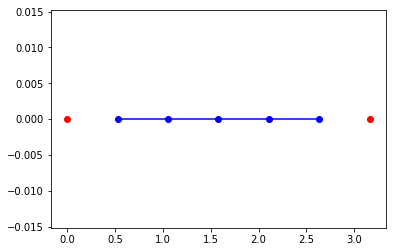

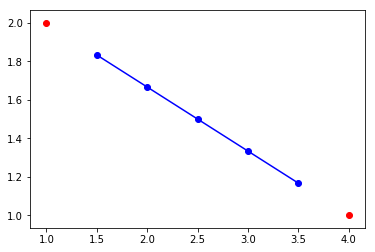

In [71]:
def R_rotation(phi): 
    ''' build rotation matrix R for rotaion of phi around z axis'''
    c, s = np.cos(phi), np.sin(phi)
    R = np.array(((c, s), (-s, c))) # rotation matrix
    return R
def put_n_points_in_between(p1,p2,n_p_between):
    ''' put n_p_between points between p1 and p2 points. Returns a set of x and ys. 
    The points are derived by rotation to put the line on x axis'''
    phi = np.arctan((p2[1]-p1[1])/(p2[0]-p1[0]))
    R = R_rotation(phi)
    p2_prime = np.matmul(R,p2-p1)
    x_p = np.linspace(0, p2_prime[0], num= n_p_between+1, endpoint=False) # produce n points on the line 
    plt.scatter([0,p2_prime[0]],[0,p2_prime[1]], c = 'r')

    points_prime = np.vstack((x_p[1:],np.zeros_like(x_p[1:])))
    plt.plot(points_prime[0,:],points_prime[1,:],'-o',c= 'b')

    points = np.matmul(R_rotation(-phi),points_prime)+p1.reshape(-1,1) # brings points to the original coordinate
    return points
def equidistant_points_between(p1, p2, n_p_between):
    x = np.linspace(p1[0], p2[0], n_p_between+1, endpoint=False)
    y = np.linspace(p1[1], p2[1], n_p_between+1, endpoint=False)
    return np.vstack((x[1:],y[1:]))
p1 = np.array([1,2])
p2 = np.array([4,1])
# plt.figure(1)
points = put_n_points_in_between(p1,p2,5)
# points = equidistant_points_between(p1, p2, 5)
plt.figure(2)
plt.scatter([p1[0],p2[0]],[p1[1],p2[1]], c = 'r')
plt.plot(points[0,:],points[1,:],'-o',c= 'b')





In [16]:
xx = np.arange(64).reshape(8,8)
print(xx)
mask = xx>5
print(mask)
print(xx[mask])
# conc_t = 2
# shifted_forward_x = np.concatenate((np.repeat(xx[:,0].reshape(-1,1),conc_t,axis = 1),xx[:,:-conc_t]),axis = 1) # repeat boundaries to avoid boundary condition
# print(shifted_forward_x)
# print(shifted_forward_x.shape)
# shifted_back_x = np.concatenate((xx[:,conc_t:],np.repeat(xx[:,-1].reshape(-1,1),conc_t,axis = 1)),axis = 1) # repeat boundaries to avoid boundary condition
# print(shifted_back_x)
# print(shifted_back_x.shape)
# velocity = (shifted_back_x - shifted_forward_x)
# print(velocity)

[[ 0  1  2  3  4  5  6  7]
 [ 8  9 10 11 12 13 14 15]
 [16 17 18 19 20 21 22 23]
 [24 25 26 27 28 29 30 31]
 [32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47]
 [48 49 50 51 52 53 54 55]
 [56 57 58 59 60 61 62 63]]
[[False False False False False False  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True]]
[ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59 60 61 62 63]
